Code for **"Inpainting"** figures $6$, $8$ and 7 (top) from the main paper. 

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

# Import libs

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

# Choose figure

In [3]:
## Fig 6
# img_path  = 'data/inpainting/vase.png'
# mask_path = 'data/inpainting/vase_mask.png'

## Fig 8
# img_path  = 'data/inpainting/library.png'
# mask_path = 'data/inpainting/library_mask.png'

## Fig 7 (top)
img_path  = 'data/inpainting/kate.png'
mask_path = 'data/inpainting/kate_mask.png'

# Another text inpainting example
# img_path  = 'data/inpainting/peppers.png'
# mask_path = 'data/inpainting/peppers_mask.png'

NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

# Load mask

In [4]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

### Center crop

In [5]:
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)

### Visualize

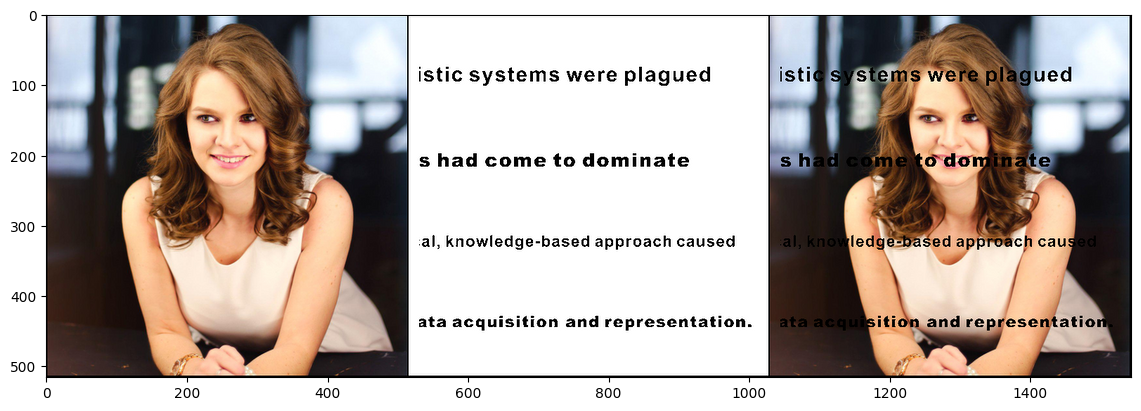

In [6]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

# Setup

In [7]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [8]:
if 'vase.png' in img_path:
    INPUT = 'meshgrid'
    input_depth = 2
    LR = 0.01 
    num_iter = 5001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up   = [128] * 5,
               num_channels_skip = [0] * 5,  
               upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif ('kate.png' in img_path) or ('peppers.png' in img_path):
    # Same params and net as in super-resolution and denoising
    INPUT = 'noise'
    input_depth = 32
    LR = 0.01 
    num_iter = 6001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up =   [128] * 5,
               num_channels_skip =    [128] * 5,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif 'library.png' in img_path:
    
    INPUT = 'noise'
    input_depth = 1
    
    num_iter = 3001
    show_every = 50
    figsize = 8
    reg_noise_std = 0.00
    param_noise = True
    
    if 'skip' in NET_TYPE:
        
        depth = int(NET_TYPE[-1])
        net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
               num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
               num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],  
               filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
               upsample_mode='nearest', # downsample_mode='avg',
               need1x1_up=False,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
        
        LR = 0.01 
        
    elif NET_TYPE == 'UNET':
        
        net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=8, more_layers=1, 
                   concat_x=False, upsample_mode='deconv', 
                   pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
        
        LR = 0.001
        param_noise = False
        
    elif NET_TYPE == 'ResNet':
        
        net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')
        
        LR = 0.001
        param_noise = False
        
    else:
        assert False
else:
    assert False

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [9]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 3002627


# Main loop

In [10]:
log_dir = 'logs'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# 打开日志文件
log_file_path = os.path.join(log_dir, 'inpaint_training_log.txt')
log_file = open(log_file_path, 'a')

i = 0
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
    log_message = ('Iteration %05d    Loss %f \n' % 
               (i, total_loss.item(),))
    print(log_message, '\r', end='')
    log_file.write(log_message)
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        # plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1, file_name=f"./output/inpaint/inpaint_{i:4d}.jpg")
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone() 
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Starting optimization with ADAM


  0%|          | 3/6001 [00:02<59:12,  1.69it/s]  

Iteration 00000    Loss 0.122426 
Iteration 00001    Loss 0.110398 
Iteration 00002    Loss 0.162965 


  0%|          | 7/6001 [00:02<20:26,  4.89it/s]

Iteration 00003    Loss 0.137089 
Iteration 00004    Loss 0.116360 
Iteration 00005    Loss 0.098208 
Iteration 00006    Loss 0.076369 


  0%|          | 11/6001 [00:02<11:25,  8.74it/s]

Iteration 00007    Loss 0.061255 
Iteration 00008    Loss 0.048462 
Iteration 00009    Loss 0.037832 
Iteration 00010    Loss 0.030804 


  0%|          | 15/6001 [00:02<08:04, 12.36it/s]

Iteration 00011    Loss 0.028577 
Iteration 00012    Loss 0.032091 
Iteration 00013    Loss 0.031858 
Iteration 00014    Loss 0.027483 


  0%|          | 19/6001 [00:03<06:36, 15.08it/s]

Iteration 00015    Loss 0.027711 
Iteration 00016    Loss 0.026662 
Iteration 00017    Loss 0.025963 
Iteration 00018    Loss 0.022630 


  0%|          | 23/6001 [00:03<05:56, 16.79it/s]

Iteration 00019    Loss 0.020618 
Iteration 00020    Loss 0.022453 
Iteration 00021    Loss 0.021879 
Iteration 00022    Loss 0.020988 


  0%|          | 27/6001 [00:03<05:36, 17.75it/s]

Iteration 00023    Loss 0.019468 
Iteration 00024    Loss 0.020210 
Iteration 00025    Loss 0.020326 
Iteration 00026    Loss 0.019131 


  1%|          | 31/6001 [00:03<05:27, 18.23it/s]

Iteration 00027    Loss 0.018463 
Iteration 00028    Loss 0.018371 
Iteration 00029    Loss 0.017083 
Iteration 00030    Loss 0.017609 


  1%|          | 35/6001 [00:03<05:22, 18.51it/s]

Iteration 00031    Loss 0.016025 
Iteration 00032    Loss 0.015888 
Iteration 00033    Loss 0.016521 
Iteration 00034    Loss 0.016563 


  1%|          | 39/6001 [00:04<05:19, 18.66it/s]

Iteration 00035    Loss 0.015702 
Iteration 00036    Loss 0.014868 
Iteration 00037    Loss 0.015292 
Iteration 00038    Loss 0.015094 


  1%|          | 43/6001 [00:04<05:18, 18.70it/s]

Iteration 00039    Loss 0.015070 
Iteration 00040    Loss 0.013646 
Iteration 00041    Loss 0.014026 
Iteration 00042    Loss 0.013443 


  1%|          | 47/6001 [00:04<05:17, 18.72it/s]

Iteration 00043    Loss 0.014880 
Iteration 00044    Loss 0.012962 
Iteration 00045    Loss 0.013619 
Iteration 00046    Loss 0.013351 


  1%|          | 51/6001 [00:04<05:18, 18.66it/s]

Iteration 00047    Loss 0.012801 
Iteration 00048    Loss 0.012523 
Iteration 00049    Loss 0.012238 
Iteration 00050    Loss 0.011561 


  1%|          | 55/6001 [00:05<05:17, 18.71it/s]

Iteration 00051    Loss 0.011295 
Iteration 00052    Loss 0.012151 
Iteration 00053    Loss 0.011226 
Iteration 00054    Loss 0.011259 


  1%|          | 59/6001 [00:05<05:17, 18.74it/s]

Iteration 00055    Loss 0.010494 
Iteration 00056    Loss 0.011267 
Iteration 00057    Loss 0.011420 
Iteration 00058    Loss 0.010304 


  1%|          | 63/6001 [00:05<05:17, 18.73it/s]

Iteration 00059    Loss 0.010850 
Iteration 00060    Loss 0.010009 
Iteration 00061    Loss 0.010164 
Iteration 00062    Loss 0.009839 


  1%|          | 67/6001 [00:05<05:16, 18.73it/s]

Iteration 00063    Loss 0.009930 
Iteration 00064    Loss 0.010859 
Iteration 00065    Loss 0.010187 
Iteration 00066    Loss 0.008859 


  1%|          | 71/6001 [00:05<05:16, 18.74it/s]

Iteration 00067    Loss 0.009375 
Iteration 00068    Loss 0.009413 
Iteration 00069    Loss 0.008948 
Iteration 00070    Loss 0.008943 


  1%|          | 75/6001 [00:06<05:16, 18.75it/s]

Iteration 00071    Loss 0.008962 
Iteration 00072    Loss 0.008486 
Iteration 00073    Loss 0.008240 
Iteration 00074    Loss 0.008275 


  1%|▏         | 79/6001 [00:06<05:15, 18.76it/s]

Iteration 00075    Loss 0.007910 
Iteration 00076    Loss 0.008265 
Iteration 00077    Loss 0.008138 
Iteration 00078    Loss 0.007807 


  1%|▏         | 83/6001 [00:06<05:15, 18.74it/s]

Iteration 00079    Loss 0.008041 
Iteration 00080    Loss 0.008365 
Iteration 00081    Loss 0.007990 
Iteration 00082    Loss 0.008363 


  1%|▏         | 87/6001 [00:06<05:15, 18.75it/s]

Iteration 00083    Loss 0.008569 
Iteration 00084    Loss 0.007135 
Iteration 00085    Loss 0.007479 
Iteration 00086    Loss 0.007445 


  2%|▏         | 91/6001 [00:06<05:15, 18.76it/s]

Iteration 00087    Loss 0.007145 
Iteration 00088    Loss 0.007083 
Iteration 00089    Loss 0.006793 
Iteration 00090    Loss 0.007701 


  2%|▏         | 95/6001 [00:07<05:14, 18.77it/s]

Iteration 00091    Loss 0.006977 
Iteration 00092    Loss 0.006953 
Iteration 00093    Loss 0.007123 
Iteration 00094    Loss 0.006678 


  2%|▏         | 99/6001 [00:07<05:14, 18.77it/s]

Iteration 00095    Loss 0.007112 
Iteration 00096    Loss 0.006747 
Iteration 00097    Loss 0.006536 
Iteration 00098    Loss 0.006730 


  2%|▏         | 103/6001 [00:07<05:14, 18.73it/s]

Iteration 00099    Loss 0.006138 
Iteration 00100    Loss 0.006588 
Iteration 00101    Loss 0.005882 
Iteration 00102    Loss 0.006318 


  2%|▏         | 107/6001 [00:07<05:14, 18.76it/s]

Iteration 00103    Loss 0.006722 
Iteration 00104    Loss 0.006047 
Iteration 00105    Loss 0.006832 
Iteration 00106    Loss 0.006775 


  2%|▏         | 111/6001 [00:07<05:13, 18.77it/s]

Iteration 00107    Loss 0.006093 
Iteration 00108    Loss 0.006184 
Iteration 00109    Loss 0.005995 
Iteration 00110    Loss 0.006342 


  2%|▏         | 115/6001 [00:08<05:13, 18.76it/s]

Iteration 00111    Loss 0.006230 
Iteration 00112    Loss 0.005927 
Iteration 00113    Loss 0.005814 
Iteration 00114    Loss 0.005887 


  2%|▏         | 119/6001 [00:08<05:13, 18.78it/s]

Iteration 00115    Loss 0.005705 
Iteration 00116    Loss 0.005418 
Iteration 00117    Loss 0.005594 
Iteration 00118    Loss 0.005972 


  2%|▏         | 123/6001 [00:08<05:13, 18.76it/s]

Iteration 00119    Loss 0.005558 
Iteration 00120    Loss 0.005328 
Iteration 00121    Loss 0.005261 
Iteration 00122    Loss 0.005654 


  2%|▏         | 127/6001 [00:08<05:13, 18.76it/s]

Iteration 00123    Loss 0.005734 
Iteration 00124    Loss 0.005245 
Iteration 00125    Loss 0.005654 
Iteration 00126    Loss 0.005191 


  2%|▏         | 131/6001 [00:09<05:13, 18.75it/s]

Iteration 00127    Loss 0.005489 
Iteration 00128    Loss 0.005045 
Iteration 00129    Loss 0.005084 
Iteration 00130    Loss 0.005732 


  2%|▏         | 135/6001 [00:09<05:12, 18.76it/s]

Iteration 00131    Loss 0.005045 
Iteration 00132    Loss 0.004851 
Iteration 00133    Loss 0.005318 
Iteration 00134    Loss 0.005407 


  2%|▏         | 139/6001 [00:09<05:12, 18.74it/s]

Iteration 00135    Loss 0.005002 
Iteration 00136    Loss 0.004913 
Iteration 00137    Loss 0.004872 
Iteration 00138    Loss 0.004897 


  2%|▏         | 143/6001 [00:09<05:13, 18.67it/s]

Iteration 00139    Loss 0.004901 
Iteration 00140    Loss 0.005105 
Iteration 00141    Loss 0.004715 
Iteration 00142    Loss 0.004708 


  2%|▏         | 147/6001 [00:09<05:13, 18.70it/s]

Iteration 00143    Loss 0.005094 
Iteration 00144    Loss 0.004592 
Iteration 00145    Loss 0.004692 
Iteration 00146    Loss 0.004860 


  3%|▎         | 151/6001 [00:10<05:13, 18.69it/s]

Iteration 00147    Loss 0.004651 
Iteration 00148    Loss 0.004685 
Iteration 00149    Loss 0.004311 
Iteration 00150    Loss 0.004508 


  3%|▎         | 155/6001 [00:10<05:12, 18.71it/s]

Iteration 00151    Loss 0.004852 
Iteration 00152    Loss 0.004514 
Iteration 00153    Loss 0.004314 
Iteration 00154    Loss 0.004457 


  3%|▎         | 159/6001 [00:10<05:12, 18.72it/s]

Iteration 00155    Loss 0.004478 
Iteration 00156    Loss 0.004434 
Iteration 00157    Loss 0.004434 
Iteration 00158    Loss 0.004245 


  3%|▎         | 163/6001 [00:10<05:11, 18.72it/s]

Iteration 00159    Loss 0.004556 
Iteration 00160    Loss 0.004296 
Iteration 00161    Loss 0.004167 
Iteration 00162    Loss 0.004262 


  3%|▎         | 167/6001 [00:10<05:11, 18.72it/s]

Iteration 00163    Loss 0.004040 
Iteration 00164    Loss 0.004332 
Iteration 00165    Loss 0.004143 
Iteration 00166    Loss 0.004049 


  3%|▎         | 171/6001 [00:11<05:11, 18.71it/s]

Iteration 00167    Loss 0.004158 
Iteration 00168    Loss 0.003853 
Iteration 00169    Loss 0.003983 
Iteration 00170    Loss 0.004230 


  3%|▎         | 175/6001 [00:11<05:11, 18.70it/s]

Iteration 00171    Loss 0.003881 
Iteration 00172    Loss 0.004054 
Iteration 00173    Loss 0.003890 
Iteration 00174    Loss 0.003893 


  3%|▎         | 179/6001 [00:11<05:11, 18.71it/s]

Iteration 00175    Loss 0.003729 
Iteration 00176    Loss 0.003872 
Iteration 00177    Loss 0.003898 
Iteration 00178    Loss 0.003794 


  3%|▎         | 183/6001 [00:11<05:10, 18.72it/s]

Iteration 00179    Loss 0.003830 
Iteration 00180    Loss 0.003768 
Iteration 00181    Loss 0.003708 
Iteration 00182    Loss 0.003641 


  3%|▎         | 187/6001 [00:12<05:10, 18.73it/s]

Iteration 00183    Loss 0.003463 
Iteration 00184    Loss 0.003497 
Iteration 00185    Loss 0.003624 
Iteration 00186    Loss 0.003478 


  3%|▎         | 191/6001 [00:12<05:10, 18.71it/s]

Iteration 00187    Loss 0.003802 
Iteration 00188    Loss 0.003603 
Iteration 00189    Loss 0.003456 
Iteration 00190    Loss 0.003581 


  3%|▎         | 195/6001 [00:12<05:10, 18.71it/s]

Iteration 00191    Loss 0.003646 
Iteration 00192    Loss 0.003558 
Iteration 00193    Loss 0.003385 
Iteration 00194    Loss 0.003533 


  3%|▎         | 199/6001 [00:12<05:10, 18.70it/s]

Iteration 00195    Loss 0.003597 
Iteration 00196    Loss 0.003373 
Iteration 00197    Loss 0.003371 
Iteration 00198    Loss 0.003375 


  3%|▎         | 203/6001 [00:12<05:10, 18.69it/s]

Iteration 00199    Loss 0.003444 
Iteration 00200    Loss 0.003696 
Iteration 00201    Loss 0.003417 
Iteration 00202    Loss 0.003456 


  3%|▎         | 207/6001 [00:13<05:09, 18.72it/s]

Iteration 00203    Loss 0.003556 
Iteration 00204    Loss 0.003161 
Iteration 00205    Loss 0.003210 
Iteration 00206    Loss 0.003176 


  4%|▎         | 211/6001 [00:13<05:09, 18.73it/s]

Iteration 00207    Loss 0.003451 
Iteration 00208    Loss 0.003338 
Iteration 00209    Loss 0.003285 
Iteration 00210    Loss 0.003568 


  4%|▎         | 215/6001 [00:13<05:08, 18.73it/s]

Iteration 00211    Loss 0.003376 
Iteration 00212    Loss 0.003085 
Iteration 00213    Loss 0.003392 
Iteration 00214    Loss 0.003161 


  4%|▎         | 219/6001 [00:13<05:08, 18.71it/s]

Iteration 00215    Loss 0.003351 
Iteration 00216    Loss 0.003086 
Iteration 00217    Loss 0.003218 
Iteration 00218    Loss 0.003293 


  4%|▎         | 223/6001 [00:13<05:08, 18.70it/s]

Iteration 00219    Loss 0.003350 
Iteration 00220    Loss 0.003220 
Iteration 00221    Loss 0.003159 
Iteration 00222    Loss 0.003052 


  4%|▍         | 227/6001 [00:14<05:08, 18.71it/s]

Iteration 00223    Loss 0.003262 
Iteration 00224    Loss 0.003122 
Iteration 00225    Loss 0.002890 
Iteration 00226    Loss 0.003056 


  4%|▍         | 231/6001 [00:14<05:08, 18.72it/s]

Iteration 00227    Loss 0.002984 
Iteration 00228    Loss 0.003149 
Iteration 00229    Loss 0.002904 
Iteration 00230    Loss 0.003072 


  4%|▍         | 235/6001 [00:14<05:08, 18.71it/s]

Iteration 00231    Loss 0.002966 
Iteration 00232    Loss 0.002952 
Iteration 00233    Loss 0.002943 
Iteration 00234    Loss 0.002994 


  4%|▍         | 239/6001 [00:14<05:07, 18.73it/s]

Iteration 00235    Loss 0.002962 
Iteration 00236    Loss 0.002801 
Iteration 00237    Loss 0.002963 
Iteration 00238    Loss 0.002837 


  4%|▍         | 243/6001 [00:15<05:08, 18.68it/s]

Iteration 00239    Loss 0.002811 
Iteration 00240    Loss 0.002923 
Iteration 00241    Loss 0.002678 
Iteration 00242    Loss 0.002857 


  4%|▍         | 247/6001 [00:15<05:07, 18.68it/s]

Iteration 00243    Loss 0.002890 
Iteration 00244    Loss 0.002757 
Iteration 00245    Loss 0.002630 
Iteration 00246    Loss 0.002677 


  4%|▍         | 251/6001 [00:15<05:08, 18.66it/s]

Iteration 00247    Loss 0.002783 
Iteration 00248    Loss 0.002685 
Iteration 00249    Loss 0.002624 
Iteration 00250    Loss 0.002934 


  4%|▍         | 255/6001 [00:15<05:07, 18.66it/s]

Iteration 00251    Loss 0.002679 
Iteration 00252    Loss 0.002891 
Iteration 00253    Loss 0.002677 
Iteration 00254    Loss 0.002702 


  4%|▍         | 259/6001 [00:15<05:07, 18.69it/s]

Iteration 00255    Loss 0.002636 
Iteration 00256    Loss 0.002724 
Iteration 00257    Loss 0.002617 
Iteration 00258    Loss 0.002692 


  4%|▍         | 263/6001 [00:16<05:07, 18.69it/s]

Iteration 00259    Loss 0.002608 
Iteration 00260    Loss 0.002584 
Iteration 00261    Loss 0.002667 
Iteration 00262    Loss 0.002791 


  4%|▍         | 267/6001 [00:16<05:06, 18.70it/s]

Iteration 00263    Loss 0.002587 
Iteration 00264    Loss 0.002564 
Iteration 00265    Loss 0.002512 
Iteration 00266    Loss 0.002625 


  5%|▍         | 271/6001 [00:16<05:06, 18.68it/s]

Iteration 00267    Loss 0.002552 
Iteration 00268    Loss 0.002464 
Iteration 00269    Loss 0.002686 
Iteration 00270    Loss 0.002628 


  5%|▍         | 275/6001 [00:16<05:06, 18.67it/s]

Iteration 00271    Loss 0.002496 
Iteration 00272    Loss 0.002390 
Iteration 00273    Loss 0.002398 
Iteration 00274    Loss 0.002539 


  5%|▍         | 279/6001 [00:16<05:06, 18.66it/s]

Iteration 00275    Loss 0.002443 
Iteration 00276    Loss 0.002434 
Iteration 00277    Loss 0.002379 
Iteration 00278    Loss 0.002418 


  5%|▍         | 283/6001 [00:17<05:06, 18.67it/s]

Iteration 00279    Loss 0.002543 
Iteration 00280    Loss 0.002353 
Iteration 00281    Loss 0.002236 
Iteration 00282    Loss 0.002453 


  5%|▍         | 287/6001 [00:17<05:05, 18.69it/s]

Iteration 00283    Loss 0.002426 
Iteration 00284    Loss 0.002552 
Iteration 00285    Loss 0.002269 
Iteration 00286    Loss 0.002316 


  5%|▍         | 291/6001 [00:17<05:05, 18.70it/s]

Iteration 00287    Loss 0.002235 
Iteration 00288    Loss 0.002372 
Iteration 00289    Loss 0.002354 
Iteration 00290    Loss 0.002390 


  5%|▍         | 295/6001 [00:17<05:05, 18.66it/s]

Iteration 00291    Loss 0.002270 
Iteration 00292    Loss 0.002288 
Iteration 00293    Loss 0.002246 
Iteration 00294    Loss 0.002258 


  5%|▍         | 299/6001 [00:18<05:05, 18.69it/s]

Iteration 00295    Loss 0.002358 
Iteration 00296    Loss 0.002312 
Iteration 00297    Loss 0.002183 
Iteration 00298    Loss 0.002186 


  5%|▌         | 303/6001 [00:18<05:05, 18.66it/s]

Iteration 00299    Loss 0.002252 
Iteration 00300    Loss 0.002308 
Iteration 00301    Loss 0.002232 
Iteration 00302    Loss 0.002293 


  5%|▌         | 307/6001 [00:18<05:04, 18.67it/s]

Iteration 00303    Loss 0.002357 
Iteration 00304    Loss 0.002268 
Iteration 00305    Loss 0.002184 
Iteration 00306    Loss 0.002235 


  5%|▌         | 311/6001 [00:18<05:04, 18.67it/s]

Iteration 00307    Loss 0.002199 
Iteration 00308    Loss 0.002169 
Iteration 00309    Loss 0.002141 
Iteration 00310    Loss 0.002161 


  5%|▌         | 315/6001 [00:18<05:04, 18.67it/s]

Iteration 00311    Loss 0.002221 
Iteration 00312    Loss 0.002148 
Iteration 00313    Loss 0.002268 
Iteration 00314    Loss 0.002170 


  5%|▌         | 319/6001 [00:19<05:04, 18.69it/s]

Iteration 00315    Loss 0.002125 
Iteration 00316    Loss 0.002105 
Iteration 00317    Loss 0.002226 
Iteration 00318    Loss 0.002083 


  5%|▌         | 323/6001 [00:19<05:03, 18.69it/s]

Iteration 00319    Loss 0.002200 
Iteration 00320    Loss 0.002174 
Iteration 00321    Loss 0.002072 
Iteration 00322    Loss 0.002157 


  5%|▌         | 327/6001 [00:19<05:03, 18.67it/s]

Iteration 00323    Loss 0.002120 
Iteration 00324    Loss 0.002031 
Iteration 00325    Loss 0.002068 
Iteration 00326    Loss 0.002164 


  6%|▌         | 331/6001 [00:19<05:03, 18.70it/s]

Iteration 00327    Loss 0.002121 
Iteration 00328    Loss 0.002064 
Iteration 00329    Loss 0.002072 
Iteration 00330    Loss 0.002168 


  6%|▌         | 335/6001 [00:19<05:02, 18.74it/s]

Iteration 00331    Loss 0.002111 
Iteration 00332    Loss 0.002033 
Iteration 00333    Loss 0.002147 
Iteration 00334    Loss 0.002052 


  6%|▌         | 339/6001 [00:20<05:01, 18.76it/s]

Iteration 00335    Loss 0.001998 
Iteration 00336    Loss 0.001997 
Iteration 00337    Loss 0.001942 
Iteration 00338    Loss 0.001978 


  6%|▌         | 343/6001 [00:20<05:01, 18.77it/s]

Iteration 00339    Loss 0.002009 
Iteration 00340    Loss 0.002007 
Iteration 00341    Loss 0.001935 
Iteration 00342    Loss 0.001948 


  6%|▌         | 347/6001 [00:20<05:01, 18.78it/s]

Iteration 00343    Loss 0.001952 
Iteration 00344    Loss 0.002007 
Iteration 00345    Loss 0.001957 
Iteration 00346    Loss 0.001987 


  6%|▌         | 351/6001 [00:20<05:01, 18.76it/s]

Iteration 00347    Loss 0.001966 
Iteration 00348    Loss 0.002044 
Iteration 00349    Loss 0.001968 
Iteration 00350    Loss 0.001830 


  6%|▌         | 355/6001 [00:21<05:00, 18.76it/s]

Iteration 00351    Loss 0.001956 
Iteration 00352    Loss 0.001835 
Iteration 00353    Loss 0.001902 
Iteration 00354    Loss 0.001918 


  6%|▌         | 359/6001 [00:21<05:01, 18.74it/s]

Iteration 00355    Loss 0.001818 
Iteration 00356    Loss 0.001894 
Iteration 00357    Loss 0.001906 
Iteration 00358    Loss 0.001837 


  6%|▌         | 363/6001 [00:21<05:00, 18.75it/s]

Iteration 00359    Loss 0.001950 
Iteration 00360    Loss 0.001830 
Iteration 00361    Loss 0.001855 
Iteration 00362    Loss 0.001825 


  6%|▌         | 367/6001 [00:21<05:00, 18.77it/s]

Iteration 00363    Loss 0.001739 
Iteration 00364    Loss 0.001772 
Iteration 00365    Loss 0.001851 
Iteration 00366    Loss 0.001761 


  6%|▌         | 371/6001 [00:21<05:00, 18.76it/s]

Iteration 00367    Loss 0.001854 
Iteration 00368    Loss 0.001686 
Iteration 00369    Loss 0.001855 
Iteration 00370    Loss 0.001826 


  6%|▌         | 375/6001 [00:22<04:59, 18.78it/s]

Iteration 00371    Loss 0.001882 
Iteration 00372    Loss 0.001879 
Iteration 00373    Loss 0.001769 
Iteration 00374    Loss 0.001743 


  6%|▋         | 379/6001 [00:22<04:59, 18.78it/s]

Iteration 00375    Loss 0.001766 
Iteration 00376    Loss 0.001757 
Iteration 00377    Loss 0.001814 
Iteration 00378    Loss 0.001810 


  6%|▋         | 383/6001 [00:22<04:59, 18.74it/s]

Iteration 00379    Loss 0.001786 
Iteration 00380    Loss 0.001813 
Iteration 00381    Loss 0.001772 
Iteration 00382    Loss 0.001730 


  6%|▋         | 387/6001 [00:22<04:59, 18.76it/s]

Iteration 00383    Loss 0.001766 
Iteration 00384    Loss 0.001795 
Iteration 00385    Loss 0.001756 
Iteration 00386    Loss 0.001760 


  7%|▋         | 391/6001 [00:22<04:58, 18.76it/s]

Iteration 00387    Loss 0.001742 
Iteration 00388    Loss 0.001794 
Iteration 00389    Loss 0.001672 
Iteration 00390    Loss 0.001772 


  7%|▋         | 395/6001 [00:23<04:59, 18.75it/s]

Iteration 00391    Loss 0.001656 
Iteration 00392    Loss 0.001936 
Iteration 00393    Loss 0.001649 
Iteration 00394    Loss 0.001798 


  7%|▋         | 399/6001 [00:23<04:58, 18.77it/s]

Iteration 00395    Loss 0.001672 
Iteration 00396    Loss 0.001738 
Iteration 00397    Loss 0.001681 
Iteration 00398    Loss 0.001666 


  7%|▋         | 403/6001 [00:23<04:58, 18.74it/s]

Iteration 00399    Loss 0.001650 
Iteration 00400    Loss 0.001644 
Iteration 00401    Loss 0.001774 
Iteration 00402    Loss 0.001749 


  7%|▋         | 407/6001 [00:23<04:58, 18.77it/s]

Iteration 00403    Loss 0.001692 
Iteration 00404    Loss 0.001586 
Iteration 00405    Loss 0.001591 
Iteration 00406    Loss 0.001549 


  7%|▋         | 411/6001 [00:24<04:57, 18.77it/s]

Iteration 00407    Loss 0.001645 
Iteration 00408    Loss 0.001597 
Iteration 00409    Loss 0.001679 
Iteration 00410    Loss 0.001581 


  7%|▋         | 415/6001 [00:24<04:57, 18.77it/s]

Iteration 00411    Loss 0.001714 
Iteration 00412    Loss 0.001658 
Iteration 00413    Loss 0.001663 
Iteration 00414    Loss 0.001579 


  7%|▋         | 419/6001 [00:24<04:57, 18.77it/s]

Iteration 00415    Loss 0.001636 
Iteration 00416    Loss 0.001598 
Iteration 00417    Loss 0.001609 
Iteration 00418    Loss 0.001630 


  7%|▋         | 423/6001 [00:24<04:57, 18.77it/s]

Iteration 00419    Loss 0.001633 
Iteration 00420    Loss 0.001572 
Iteration 00421    Loss 0.001541 
Iteration 00422    Loss 0.001619 


  7%|▋         | 427/6001 [00:24<04:57, 18.74it/s]

Iteration 00423    Loss 0.001564 
Iteration 00424    Loss 0.001643 
Iteration 00425    Loss 0.001540 
Iteration 00426    Loss 0.001585 


  7%|▋         | 431/6001 [00:25<04:57, 18.74it/s]

Iteration 00427    Loss 0.001635 
Iteration 00428    Loss 0.001585 
Iteration 00429    Loss 0.001566 
Iteration 00430    Loss 0.001537 


  7%|▋         | 435/6001 [00:25<04:56, 18.75it/s]

Iteration 00431    Loss 0.001506 
Iteration 00432    Loss 0.001552 
Iteration 00433    Loss 0.001507 
Iteration 00434    Loss 0.001543 


  7%|▋         | 439/6001 [00:25<04:56, 18.75it/s]

Iteration 00435    Loss 0.001540 
Iteration 00436    Loss 0.001553 
Iteration 00437    Loss 0.001541 
Iteration 00438    Loss 0.001483 


  7%|▋         | 443/6001 [00:25<04:56, 18.75it/s]

Iteration 00439    Loss 0.001557 
Iteration 00440    Loss 0.001543 
Iteration 00441    Loss 0.001492 
Iteration 00442    Loss 0.001455 


  7%|▋         | 447/6001 [00:25<04:56, 18.75it/s]

Iteration 00443    Loss 0.001544 
Iteration 00444    Loss 0.001450 
Iteration 00445    Loss 0.001563 
Iteration 00446    Loss 0.001471 


  8%|▊         | 451/6001 [00:26<04:56, 18.74it/s]

Iteration 00447    Loss 0.001488 
Iteration 00448    Loss 0.001486 
Iteration 00449    Loss 0.001474 
Iteration 00450    Loss 0.001411 


  8%|▊         | 455/6001 [00:26<04:55, 18.75it/s]

Iteration 00451    Loss 0.001486 
Iteration 00452    Loss 0.001537 
Iteration 00453    Loss 0.001536 
Iteration 00454    Loss 0.001558 


  8%|▊         | 459/6001 [00:26<04:55, 18.76it/s]

Iteration 00455    Loss 0.001598 
Iteration 00456    Loss 0.001523 
Iteration 00457    Loss 0.001483 
Iteration 00458    Loss 0.001492 


  8%|▊         | 463/6001 [00:26<04:55, 18.77it/s]

Iteration 00459    Loss 0.001425 
Iteration 00460    Loss 0.001575 
Iteration 00461    Loss 0.001409 
Iteration 00462    Loss 0.001549 


  8%|▊         | 467/6001 [00:27<04:54, 18.77it/s]

Iteration 00463    Loss 0.001445 
Iteration 00464    Loss 0.001559 
Iteration 00465    Loss 0.001416 
Iteration 00466    Loss 0.001477 


  8%|▊         | 471/6001 [00:27<04:55, 18.74it/s]

Iteration 00467    Loss 0.001445 
Iteration 00468    Loss 0.001558 
Iteration 00469    Loss 0.001445 
Iteration 00470    Loss 0.001606 


  8%|▊         | 475/6001 [00:27<04:54, 18.75it/s]

Iteration 00471    Loss 0.001361 
Iteration 00472    Loss 0.001677 
Iteration 00473    Loss 0.001363 
Iteration 00474    Loss 0.001483 


  8%|▊         | 479/6001 [00:27<04:54, 18.76it/s]

Iteration 00475    Loss 0.001395 
Iteration 00476    Loss 0.001462 
Iteration 00477    Loss 0.001409 
Iteration 00478    Loss 0.001405 


  8%|▊         | 483/6001 [00:27<04:54, 18.77it/s]

Iteration 00479    Loss 0.001406 
Iteration 00480    Loss 0.001483 
Iteration 00481    Loss 0.001368 
Iteration 00482    Loss 0.001339 


  8%|▊         | 487/6001 [00:28<04:53, 18.77it/s]

Iteration 00483    Loss 0.001492 
Iteration 00484    Loss 0.001412 
Iteration 00485    Loss 0.001340 
Iteration 00486    Loss 0.001358 


  8%|▊         | 491/6001 [00:28<04:53, 18.76it/s]

Iteration 00487    Loss 0.001396 
Iteration 00488    Loss 0.001387 
Iteration 00489    Loss 0.001334 
Iteration 00490    Loss 0.001284 


  8%|▊         | 495/6001 [00:28<04:53, 18.76it/s]

Iteration 00491    Loss 0.001376 
Iteration 00492    Loss 0.001365 
Iteration 00493    Loss 0.001309 
Iteration 00494    Loss 0.001317 


  8%|▊         | 499/6001 [00:28<04:53, 18.76it/s]

Iteration 00495    Loss 0.001314 
Iteration 00496    Loss 0.001341 
Iteration 00497    Loss 0.001329 
Iteration 00498    Loss 0.001278 


  8%|▊         | 503/6001 [00:28<04:53, 18.75it/s]

Iteration 00499    Loss 0.001319 
Iteration 00500    Loss 0.001345 
Iteration 00501    Loss 0.001303 
Iteration 00502    Loss 0.001327 


  8%|▊         | 507/6001 [00:29<04:52, 18.76it/s]

Iteration 00503    Loss 0.001313 
Iteration 00504    Loss 0.001364 
Iteration 00505    Loss 0.001332 
Iteration 00506    Loss 0.001265 


  9%|▊         | 511/6001 [00:29<04:52, 18.75it/s]

Iteration 00507    Loss 0.001399 
Iteration 00508    Loss 0.001280 
Iteration 00509    Loss 0.001309 
Iteration 00510    Loss 0.001284 


  9%|▊         | 515/6001 [00:29<04:52, 18.74it/s]

Iteration 00511    Loss 0.001268 
Iteration 00512    Loss 0.001315 
Iteration 00513    Loss 0.001280 
Iteration 00514    Loss 0.001296 


  9%|▊         | 519/6001 [00:29<04:52, 18.76it/s]

Iteration 00515    Loss 0.001343 
Iteration 00516    Loss 0.001280 
Iteration 00517    Loss 0.001297 
Iteration 00518    Loss 0.001263 


  9%|▊         | 523/6001 [00:29<04:51, 18.76it/s]

Iteration 00519    Loss 0.001268 
Iteration 00520    Loss 0.001310 
Iteration 00521    Loss 0.001252 
Iteration 00522    Loss 0.001273 


  9%|▉         | 527/6001 [00:30<04:51, 18.77it/s]

Iteration 00523    Loss 0.001296 
Iteration 00524    Loss 0.001263 
Iteration 00525    Loss 0.001303 
Iteration 00526    Loss 0.001253 


  9%|▉         | 531/6001 [00:30<04:51, 18.77it/s]

Iteration 00527    Loss 0.001352 
Iteration 00528    Loss 0.001244 
Iteration 00529    Loss 0.001274 
Iteration 00530    Loss 0.001222 


  9%|▉         | 535/6001 [00:30<04:51, 18.77it/s]

Iteration 00531    Loss 0.001237 
Iteration 00532    Loss 0.001286 
Iteration 00533    Loss 0.001244 
Iteration 00534    Loss 0.001251 


  9%|▉         | 539/6001 [00:30<04:51, 18.75it/s]

Iteration 00535    Loss 0.001259 
Iteration 00536    Loss 0.001186 
Iteration 00537    Loss 0.001253 
Iteration 00538    Loss 0.001216 


  9%|▉         | 543/6001 [00:31<04:51, 18.74it/s]

Iteration 00539    Loss 0.001202 
Iteration 00540    Loss 0.001246 
Iteration 00541    Loss 0.001210 
Iteration 00542    Loss 0.001231 


  9%|▉         | 547/6001 [00:31<04:51, 18.74it/s]

Iteration 00543    Loss 0.001202 
Iteration 00544    Loss 0.001300 
Iteration 00545    Loss 0.001243 
Iteration 00546    Loss 0.001195 


  9%|▉         | 551/6001 [00:31<04:51, 18.72it/s]

Iteration 00547    Loss 0.001240 
Iteration 00548    Loss 0.001205 
Iteration 00549    Loss 0.001214 
Iteration 00550    Loss 0.001190 


  9%|▉         | 555/6001 [00:31<04:50, 18.75it/s]

Iteration 00551    Loss 0.001214 
Iteration 00552    Loss 0.001199 
Iteration 00553    Loss 0.001239 
Iteration 00554    Loss 0.001230 


  9%|▉         | 559/6001 [00:31<04:50, 18.76it/s]

Iteration 00555    Loss 0.001208 
Iteration 00556    Loss 0.001214 
Iteration 00557    Loss 0.001213 
Iteration 00558    Loss 0.001210 


  9%|▉         | 563/6001 [00:32<04:49, 18.76it/s]

Iteration 00559    Loss 0.001175 
Iteration 00560    Loss 0.001225 
Iteration 00561    Loss 0.001172 
Iteration 00562    Loss 0.001232 


  9%|▉         | 567/6001 [00:32<04:49, 18.76it/s]

Iteration 00563    Loss 0.001198 
Iteration 00564    Loss 0.001156 
Iteration 00565    Loss 0.001119 
Iteration 00566    Loss 0.001160 


 10%|▉         | 571/6001 [00:32<04:49, 18.75it/s]

Iteration 00567    Loss 0.001135 
Iteration 00568    Loss 0.001197 
Iteration 00569    Loss 0.001138 
Iteration 00570    Loss 0.001150 


 10%|▉         | 575/6001 [00:32<04:49, 18.74it/s]

Iteration 00571    Loss 0.001137 
Iteration 00572    Loss 0.001156 
Iteration 00573    Loss 0.001137 
Iteration 00574    Loss 0.001157 


 10%|▉         | 579/6001 [00:32<04:50, 18.68it/s]

Iteration 00575    Loss 0.001165 
Iteration 00576    Loss 0.001115 
Iteration 00577    Loss 0.001123 
Iteration 00578    Loss 0.001112 


 10%|▉         | 583/6001 [00:33<04:50, 18.68it/s]

Iteration 00579    Loss 0.001106 
Iteration 00580    Loss 0.001144 
Iteration 00581    Loss 0.001129 
Iteration 00582    Loss 0.001131 


 10%|▉         | 587/6001 [00:33<04:49, 18.70it/s]

Iteration 00583    Loss 0.001165 
Iteration 00584    Loss 0.001158 
Iteration 00585    Loss 0.001107 
Iteration 00586    Loss 0.001122 


 10%|▉         | 591/6001 [00:33<04:49, 18.69it/s]

Iteration 00587    Loss 0.001127 
Iteration 00588    Loss 0.001170 
Iteration 00589    Loss 0.001133 
Iteration 00590    Loss 0.001096 


 10%|▉         | 595/6001 [00:33<04:49, 18.70it/s]

Iteration 00591    Loss 0.001100 
Iteration 00592    Loss 0.001146 
Iteration 00593    Loss 0.001161 
Iteration 00594    Loss 0.001101 


 10%|▉         | 599/6001 [00:34<04:49, 18.66it/s]

Iteration 00595    Loss 0.001154 
Iteration 00596    Loss 0.001107 
Iteration 00597    Loss 0.001074 
Iteration 00598    Loss 0.001051 


 10%|█         | 603/6001 [00:34<04:50, 18.61it/s]

Iteration 00599    Loss 0.001133 
Iteration 00600    Loss 0.001072 
Iteration 00601    Loss 0.001136 
Iteration 00602    Loss 0.001071 


 10%|█         | 607/6001 [00:34<04:49, 18.64it/s]

Iteration 00603    Loss 0.001117 
Iteration 00604    Loss 0.001091 
Iteration 00605    Loss 0.001042 
Iteration 00606    Loss 0.001075 


 10%|█         | 611/6001 [00:34<04:49, 18.64it/s]

Iteration 00607    Loss 0.001057 
Iteration 00608    Loss 0.001112 
Iteration 00609    Loss 0.001009 
Iteration 00610    Loss 0.001068 


 10%|█         | 615/6001 [00:34<04:48, 18.68it/s]

Iteration 00611    Loss 0.001064 
Iteration 00612    Loss 0.001095 
Iteration 00613    Loss 0.001071 
Iteration 00614    Loss 0.001128 


 10%|█         | 619/6001 [00:35<04:47, 18.70it/s]

Iteration 00615    Loss 0.001075 
Iteration 00616    Loss 0.001144 
Iteration 00617    Loss 0.001128 
Iteration 00618    Loss 0.001126 


 10%|█         | 623/6001 [00:35<04:47, 18.69it/s]

Iteration 00619    Loss 0.001106 
Iteration 00620    Loss 0.001046 
Iteration 00621    Loss 0.001117 
Iteration 00622    Loss 0.001080 


 10%|█         | 627/6001 [00:35<04:47, 18.67it/s]

Iteration 00623    Loss 0.001087 
Iteration 00624    Loss 0.001027 
Iteration 00625    Loss 0.001094 
Iteration 00626    Loss 0.001056 


 11%|█         | 631/6001 [00:35<04:47, 18.67it/s]

Iteration 00627    Loss 0.001057 
Iteration 00628    Loss 0.001063 
Iteration 00629    Loss 0.001041 
Iteration 00630    Loss 0.001038 


 11%|█         | 635/6001 [00:35<04:47, 18.68it/s]

Iteration 00631    Loss 0.001015 
Iteration 00632    Loss 0.001045 
Iteration 00633    Loss 0.001011 
Iteration 00634    Loss 0.001022 


 11%|█         | 639/6001 [00:36<04:47, 18.68it/s]

Iteration 00635    Loss 0.001041 
Iteration 00636    Loss 0.000992 
Iteration 00637    Loss 0.000992 
Iteration 00638    Loss 0.001008 


 11%|█         | 643/6001 [00:36<04:46, 18.68it/s]

Iteration 00639    Loss 0.001024 
Iteration 00640    Loss 0.001031 
Iteration 00641    Loss 0.001022 
Iteration 00642    Loss 0.001019 


 11%|█         | 647/6001 [00:36<04:46, 18.67it/s]

Iteration 00643    Loss 0.000992 
Iteration 00644    Loss 0.000971 
Iteration 00645    Loss 0.001021 
Iteration 00646    Loss 0.001030 


 11%|█         | 651/6001 [00:36<04:46, 18.66it/s]

Iteration 00647    Loss 0.001035 
Iteration 00648    Loss 0.000997 
Iteration 00649    Loss 0.000971 
Iteration 00650    Loss 0.001037 


 11%|█         | 655/6001 [00:37<04:46, 18.65it/s]

Iteration 00651    Loss 0.000998 
Iteration 00652    Loss 0.001027 
Iteration 00653    Loss 0.001031 
Iteration 00654    Loss 0.000990 


 11%|█         | 659/6001 [00:37<04:46, 18.62it/s]

Iteration 00655    Loss 0.001026 
Iteration 00656    Loss 0.000981 
Iteration 00657    Loss 0.000982 
Iteration 00658    Loss 0.000983 


 11%|█         | 663/6001 [00:37<04:46, 18.65it/s]

Iteration 00659    Loss 0.000994 
Iteration 00660    Loss 0.000979 
Iteration 00661    Loss 0.000945 
Iteration 00662    Loss 0.000963 


 11%|█         | 667/6001 [00:37<04:45, 18.66it/s]

Iteration 00663    Loss 0.000988 
Iteration 00664    Loss 0.001023 
Iteration 00665    Loss 0.000959 
Iteration 00666    Loss 0.000957 


 11%|█         | 671/6001 [00:37<04:45, 18.66it/s]

Iteration 00667    Loss 0.000959 
Iteration 00668    Loss 0.001036 
Iteration 00669    Loss 0.000988 
Iteration 00670    Loss 0.000942 


 11%|█         | 675/6001 [00:38<04:44, 18.69it/s]

Iteration 00671    Loss 0.000955 
Iteration 00672    Loss 0.000962 
Iteration 00673    Loss 0.000964 
Iteration 00674    Loss 0.000992 


 11%|█▏        | 679/6001 [00:38<04:44, 18.69it/s]

Iteration 00675    Loss 0.000983 
Iteration 00676    Loss 0.000976 
Iteration 00677    Loss 0.000935 
Iteration 00678    Loss 0.000974 


 11%|█▏        | 683/6001 [00:38<04:44, 18.69it/s]

Iteration 00679    Loss 0.000994 
Iteration 00680    Loss 0.000973 
Iteration 00681    Loss 0.000979 
Iteration 00682    Loss 0.000970 


 11%|█▏        | 687/6001 [00:38<04:44, 18.68it/s]

Iteration 00683    Loss 0.000945 
Iteration 00684    Loss 0.000971 
Iteration 00685    Loss 0.000969 
Iteration 00686    Loss 0.000924 


 12%|█▏        | 691/6001 [00:38<04:44, 18.68it/s]

Iteration 00687    Loss 0.000991 
Iteration 00688    Loss 0.000931 
Iteration 00689    Loss 0.000971 
Iteration 00690    Loss 0.000931 


 12%|█▏        | 695/6001 [00:39<04:44, 18.66it/s]

Iteration 00691    Loss 0.000927 
Iteration 00692    Loss 0.000936 
Iteration 00693    Loss 0.000930 
Iteration 00694    Loss 0.000981 


 12%|█▏        | 699/6001 [00:39<04:43, 18.67it/s]

Iteration 00695    Loss 0.000947 
Iteration 00696    Loss 0.000972 
Iteration 00697    Loss 0.000940 
Iteration 00698    Loss 0.000964 


 12%|█▏        | 703/6001 [00:39<04:43, 18.68it/s]

Iteration 00699    Loss 0.000951 
Iteration 00700    Loss 0.000935 
Iteration 00701    Loss 0.000948 
Iteration 00702    Loss 0.000927 


 12%|█▏        | 707/6001 [00:39<04:43, 18.68it/s]

Iteration 00703    Loss 0.000953 
Iteration 00704    Loss 0.000972 
Iteration 00705    Loss 0.000913 
Iteration 00706    Loss 0.000959 


 12%|█▏        | 711/6001 [00:40<04:43, 18.65it/s]

Iteration 00707    Loss 0.000914 
Iteration 00708    Loss 0.000916 
Iteration 00709    Loss 0.000940 
Iteration 00710    Loss 0.000912 


 12%|█▏        | 715/6001 [00:40<04:43, 18.67it/s]

Iteration 00711    Loss 0.000989 
Iteration 00712    Loss 0.000950 
Iteration 00713    Loss 0.000913 
Iteration 00714    Loss 0.000971 


 12%|█▏        | 719/6001 [00:40<04:42, 18.67it/s]

Iteration 00715    Loss 0.000897 
Iteration 00716    Loss 0.000911 
Iteration 00717    Loss 0.001045 
Iteration 00718    Loss 0.000930 


 12%|█▏        | 723/6001 [00:40<04:42, 18.67it/s]

Iteration 00719    Loss 0.000951 
Iteration 00720    Loss 0.000912 
Iteration 00721    Loss 0.000905 
Iteration 00722    Loss 0.000934 


 12%|█▏        | 727/6001 [00:40<04:42, 18.65it/s]

Iteration 00723    Loss 0.000898 
Iteration 00724    Loss 0.000924 
Iteration 00725    Loss 0.000906 
Iteration 00726    Loss 0.000932 


 12%|█▏        | 731/6001 [00:41<04:42, 18.66it/s]

Iteration 00727    Loss 0.000914 
Iteration 00728    Loss 0.000913 
Iteration 00729    Loss 0.000929 
Iteration 00730    Loss 0.000894 


 12%|█▏        | 735/6001 [00:41<04:42, 18.67it/s]

Iteration 00731    Loss 0.000920 
Iteration 00732    Loss 0.000857 
Iteration 00733    Loss 0.000899 
Iteration 00734    Loss 0.000869 


 12%|█▏        | 739/6001 [00:41<04:41, 18.68it/s]

Iteration 00735    Loss 0.000915 
Iteration 00736    Loss 0.000881 
Iteration 00737    Loss 0.000911 
Iteration 00738    Loss 0.000921 


 12%|█▏        | 743/6001 [00:41<04:41, 18.69it/s]

Iteration 00739    Loss 0.000892 
Iteration 00740    Loss 0.000873 
Iteration 00741    Loss 0.000860 
Iteration 00742    Loss 0.000870 


 12%|█▏        | 747/6001 [00:41<04:41, 18.69it/s]

Iteration 00743    Loss 0.000874 
Iteration 00744    Loss 0.000855 
Iteration 00745    Loss 0.000853 
Iteration 00746    Loss 0.000868 


 13%|█▎        | 751/6001 [00:42<04:41, 18.68it/s]

Iteration 00747    Loss 0.000855 
Iteration 00748    Loss 0.000842 
Iteration 00749    Loss 0.000858 
Iteration 00750    Loss 0.000873 


 13%|█▎        | 755/6001 [00:42<04:40, 18.68it/s]

Iteration 00751    Loss 0.000850 
Iteration 00752    Loss 0.000838 
Iteration 00753    Loss 0.000818 
Iteration 00754    Loss 0.000856 


 13%|█▎        | 759/6001 [00:42<04:40, 18.66it/s]

Iteration 00755    Loss 0.000843 
Iteration 00756    Loss 0.000879 
Iteration 00757    Loss 0.000871 
Iteration 00758    Loss 0.000839 


 13%|█▎        | 763/6001 [00:42<04:40, 18.65it/s]

Iteration 00759    Loss 0.000842 
Iteration 00760    Loss 0.000813 
Iteration 00761    Loss 0.000861 
Iteration 00762    Loss 0.000840 


 13%|█▎        | 767/6001 [00:43<04:41, 18.60it/s]

Iteration 00763    Loss 0.000851 
Iteration 00764    Loss 0.000883 
Iteration 00765    Loss 0.000868 
Iteration 00766    Loss 0.000814 


 13%|█▎        | 771/6001 [00:43<04:40, 18.65it/s]

Iteration 00767    Loss 0.000934 
Iteration 00768    Loss 0.000885 
Iteration 00769    Loss 0.000832 
Iteration 00770    Loss 0.000881 


 13%|█▎        | 775/6001 [00:43<04:39, 18.68it/s]

Iteration 00771    Loss 0.000825 
Iteration 00772    Loss 0.000837 
Iteration 00773    Loss 0.000864 
Iteration 00774    Loss 0.000851 


 13%|█▎        | 779/6001 [00:43<04:39, 18.69it/s]

Iteration 00775    Loss 0.000817 
Iteration 00776    Loss 0.000855 
Iteration 00777    Loss 0.000805 
Iteration 00778    Loss 0.000862 


 13%|█▎        | 783/6001 [00:43<04:39, 18.67it/s]

Iteration 00779    Loss 0.000821 
Iteration 00780    Loss 0.000853 
Iteration 00781    Loss 0.000828 
Iteration 00782    Loss 0.000807 


 13%|█▎        | 787/6001 [00:44<04:39, 18.66it/s]

Iteration 00783    Loss 0.000822 
Iteration 00784    Loss 0.000840 
Iteration 00785    Loss 0.000829 
Iteration 00786    Loss 0.000855 


 13%|█▎        | 791/6001 [00:44<04:39, 18.65it/s]

Iteration 00787    Loss 0.000834 
Iteration 00788    Loss 0.000808 
Iteration 00789    Loss 0.000810 
Iteration 00790    Loss 0.000803 


 13%|█▎        | 795/6001 [00:44<04:39, 18.63it/s]

Iteration 00791    Loss 0.000800 
Iteration 00792    Loss 0.000830 
Iteration 00793    Loss 0.000812 
Iteration 00794    Loss 0.000794 


 13%|█▎        | 799/6001 [00:44<04:38, 18.65it/s]

Iteration 00795    Loss 0.000831 
Iteration 00796    Loss 0.000807 
Iteration 00797    Loss 0.000824 
Iteration 00798    Loss 0.000818 


 13%|█▎        | 803/6001 [00:44<04:39, 18.62it/s]

Iteration 00799    Loss 0.000813 
Iteration 00800    Loss 0.000830 
Iteration 00801    Loss 0.000794 
Iteration 00802    Loss 0.000831 


 13%|█▎        | 807/6001 [00:45<04:38, 18.63it/s]

Iteration 00803    Loss 0.000802 
Iteration 00804    Loss 0.000829 
Iteration 00805    Loss 0.000777 
Iteration 00806    Loss 0.000832 


 14%|█▎        | 811/6001 [00:45<04:38, 18.63it/s]

Iteration 00807    Loss 0.000816 
Iteration 00808    Loss 0.000804 
Iteration 00809    Loss 0.000801 
Iteration 00810    Loss 0.000824 


 14%|█▎        | 815/6001 [00:45<04:38, 18.63it/s]

Iteration 00811    Loss 0.000793 
Iteration 00812    Loss 0.000831 
Iteration 00813    Loss 0.000805 
Iteration 00814    Loss 0.000821 


 14%|█▎        | 819/6001 [00:45<04:37, 18.66it/s]

Iteration 00815    Loss 0.000807 
Iteration 00816    Loss 0.000780 
Iteration 00817    Loss 0.000815 
Iteration 00818    Loss 0.000784 


 14%|█▎        | 823/6001 [00:46<04:38, 18.61it/s]

Iteration 00819    Loss 0.000790 
Iteration 00820    Loss 0.000799 
Iteration 00821    Loss 0.000799 
Iteration 00822    Loss 0.000834 


 14%|█▍        | 827/6001 [00:46<04:37, 18.62it/s]

Iteration 00823    Loss 0.000789 
Iteration 00824    Loss 0.000783 
Iteration 00825    Loss 0.000841 
Iteration 00826    Loss 0.000732 


 14%|█▍        | 831/6001 [00:46<04:37, 18.65it/s]

Iteration 00827    Loss 0.000820 
Iteration 00828    Loss 0.000796 
Iteration 00829    Loss 0.000767 
Iteration 00830    Loss 0.000789 


 14%|█▍        | 835/6001 [00:46<04:37, 18.63it/s]

Iteration 00831    Loss 0.000773 
Iteration 00832    Loss 0.000802 
Iteration 00833    Loss 0.000788 
Iteration 00834    Loss 0.000762 


 14%|█▍        | 839/6001 [00:46<04:36, 18.65it/s]

Iteration 00835    Loss 0.000780 
Iteration 00836    Loss 0.000789 
Iteration 00837    Loss 0.000791 
Iteration 00838    Loss 0.000797 


 14%|█▍        | 843/6001 [00:47<04:36, 18.66it/s]

Iteration 00839    Loss 0.000779 
Iteration 00840    Loss 0.000769 
Iteration 00841    Loss 0.000777 
Iteration 00842    Loss 0.000771 


 14%|█▍        | 847/6001 [00:47<04:36, 18.66it/s]

Iteration 00843    Loss 0.000754 
Iteration 00844    Loss 0.000803 
Iteration 00845    Loss 0.000735 
Iteration 00846    Loss 0.000778 


 14%|█▍        | 851/6001 [00:47<04:36, 18.63it/s]

Iteration 00847    Loss 0.000789 
Iteration 00848    Loss 0.000771 
Iteration 00849    Loss 0.000733 
Iteration 00850    Loss 0.000781 


 14%|█▍        | 855/6001 [00:47<04:36, 18.64it/s]

Iteration 00851    Loss 0.000791 
Iteration 00852    Loss 0.000721 
Iteration 00853    Loss 0.000796 
Iteration 00854    Loss 0.000802 


 14%|█▍        | 859/6001 [00:47<04:36, 18.63it/s]

Iteration 00855    Loss 0.000786 
Iteration 00856    Loss 0.000756 
Iteration 00857    Loss 0.000758 
Iteration 00858    Loss 0.000747 


 14%|█▍        | 863/6001 [00:48<04:35, 18.63it/s]

Iteration 00859    Loss 0.000793 
Iteration 00860    Loss 0.000756 
Iteration 00861    Loss 0.000782 
Iteration 00862    Loss 0.000808 


 14%|█▍        | 867/6001 [00:48<04:35, 18.62it/s]

Iteration 00863    Loss 0.000764 
Iteration 00864    Loss 0.000747 
Iteration 00865    Loss 0.000801 
Iteration 00866    Loss 0.000829 


 15%|█▍        | 871/6001 [00:48<04:35, 18.63it/s]

Iteration 00867    Loss 0.000724 
Iteration 00868    Loss 0.000768 
Iteration 00869    Loss 0.000742 
Iteration 00870    Loss 0.000748 


 15%|█▍        | 875/6001 [00:48<04:35, 18.61it/s]

Iteration 00871    Loss 0.000749 
Iteration 00872    Loss 0.000729 
Iteration 00873    Loss 0.000772 
Iteration 00874    Loss 0.000734 


 15%|█▍        | 879/6001 [00:49<04:35, 18.61it/s]

Iteration 00875    Loss 0.000754 
Iteration 00876    Loss 0.000723 
Iteration 00877    Loss 0.000764 
Iteration 00878    Loss 0.000752 


 15%|█▍        | 883/6001 [00:49<04:34, 18.61it/s]

Iteration 00879    Loss 0.000738 
Iteration 00880    Loss 0.000727 
Iteration 00881    Loss 0.000750 
Iteration 00882    Loss 0.000719 


 15%|█▍        | 887/6001 [00:49<04:34, 18.63it/s]

Iteration 00883    Loss 0.000730 
Iteration 00884    Loss 0.000737 
Iteration 00885    Loss 0.000739 
Iteration 00886    Loss 0.000736 


 15%|█▍        | 891/6001 [00:49<04:34, 18.63it/s]

Iteration 00887    Loss 0.000725 
Iteration 00888    Loss 0.000732 
Iteration 00889    Loss 0.000783 
Iteration 00890    Loss 0.000732 


 15%|█▍        | 895/6001 [00:49<04:34, 18.59it/s]

Iteration 00891    Loss 0.000726 
Iteration 00892    Loss 0.000722 
Iteration 00893    Loss 0.000698 
Iteration 00894    Loss 0.000701 


 15%|█▍        | 899/6001 [00:50<04:34, 18.62it/s]

Iteration 00895    Loss 0.000733 
Iteration 00896    Loss 0.000724 
Iteration 00897    Loss 0.000742 
Iteration 00898    Loss 0.000738 


 15%|█▌        | 903/6001 [00:50<04:34, 18.60it/s]

Iteration 00899    Loss 0.000728 
Iteration 00900    Loss 0.000754 
Iteration 00901    Loss 0.000780 
Iteration 00902    Loss 0.000719 


 15%|█▌        | 907/6001 [00:50<04:33, 18.60it/s]

Iteration 00903    Loss 0.000741 
Iteration 00904    Loss 0.000796 
Iteration 00905    Loss 0.000726 
Iteration 00906    Loss 0.000747 


 15%|█▌        | 911/6001 [00:50<04:33, 18.61it/s]

Iteration 00907    Loss 0.000740 
Iteration 00908    Loss 0.000715 
Iteration 00909    Loss 0.000722 
Iteration 00910    Loss 0.000746 


 15%|█▌        | 915/6001 [00:50<04:33, 18.61it/s]

Iteration 00911    Loss 0.000695 
Iteration 00912    Loss 0.000741 
Iteration 00913    Loss 0.000728 
Iteration 00914    Loss 0.000773 


 15%|█▌        | 919/6001 [00:51<04:32, 18.62it/s]

Iteration 00915    Loss 0.000771 
Iteration 00916    Loss 0.000707 
Iteration 00917    Loss 0.000771 
Iteration 00918    Loss 0.000734 


 15%|█▌        | 923/6001 [00:51<04:32, 18.61it/s]

Iteration 00919    Loss 0.000703 
Iteration 00920    Loss 0.000728 
Iteration 00921    Loss 0.000727 
Iteration 00922    Loss 0.000741 


 15%|█▌        | 927/6001 [00:51<04:32, 18.62it/s]

Iteration 00923    Loss 0.000731 
Iteration 00924    Loss 0.000706 
Iteration 00925    Loss 0.000742 
Iteration 00926    Loss 0.000742 


 16%|█▌        | 931/6001 [00:51<04:32, 18.62it/s]

Iteration 00927    Loss 0.000705 
Iteration 00928    Loss 0.000760 
Iteration 00929    Loss 0.000694 
Iteration 00930    Loss 0.000733 


 16%|█▌        | 935/6001 [00:52<04:31, 18.63it/s]

Iteration 00931    Loss 0.000747 
Iteration 00932    Loss 0.000699 
Iteration 00933    Loss 0.000722 
Iteration 00934    Loss 0.000691 


 16%|█▌        | 939/6001 [00:52<04:31, 18.62it/s]

Iteration 00935    Loss 0.000685 
Iteration 00936    Loss 0.000714 
Iteration 00937    Loss 0.000715 
Iteration 00938    Loss 0.000687 


 16%|█▌        | 943/6001 [00:52<04:31, 18.61it/s]

Iteration 00939    Loss 0.000657 
Iteration 00940    Loss 0.000711 
Iteration 00941    Loss 0.000717 
Iteration 00942    Loss 0.000675 


 16%|█▌        | 947/6001 [00:52<04:31, 18.61it/s]

Iteration 00943    Loss 0.000696 
Iteration 00944    Loss 0.000694 
Iteration 00945    Loss 0.000667 
Iteration 00946    Loss 0.000715 


 16%|█▌        | 951/6001 [00:52<04:31, 18.61it/s]

Iteration 00947    Loss 0.000683 
Iteration 00948    Loss 0.000674 
Iteration 00949    Loss 0.000720 
Iteration 00950    Loss 0.000691 


 16%|█▌        | 955/6001 [00:53<04:31, 18.62it/s]

Iteration 00951    Loss 0.000687 
Iteration 00952    Loss 0.000719 
Iteration 00953    Loss 0.000678 
Iteration 00954    Loss 0.000690 


 16%|█▌        | 959/6001 [00:53<04:30, 18.62it/s]

Iteration 00955    Loss 0.000692 
Iteration 00956    Loss 0.000685 
Iteration 00957    Loss 0.000725 
Iteration 00958    Loss 0.000690 


 16%|█▌        | 963/6001 [00:53<04:30, 18.61it/s]

Iteration 00959    Loss 0.000701 
Iteration 00960    Loss 0.000715 
Iteration 00961    Loss 0.000670 
Iteration 00962    Loss 0.000695 


 16%|█▌        | 967/6001 [00:53<04:30, 18.61it/s]

Iteration 00963    Loss 0.000674 
Iteration 00964    Loss 0.000664 
Iteration 00965    Loss 0.000678 
Iteration 00966    Loss 0.000673 


 16%|█▌        | 971/6001 [00:54<04:30, 18.61it/s]

Iteration 00967    Loss 0.000690 
Iteration 00968    Loss 0.000673 
Iteration 00969    Loss 0.000680 
Iteration 00970    Loss 0.000665 


 16%|█▌        | 975/6001 [00:54<04:30, 18.61it/s]

Iteration 00971    Loss 0.000701 
Iteration 00972    Loss 0.000654 
Iteration 00973    Loss 0.000650 
Iteration 00974    Loss 0.000679 


 16%|█▋        | 979/6001 [00:54<04:29, 18.62it/s]

Iteration 00975    Loss 0.000664 
Iteration 00976    Loss 0.000664 
Iteration 00977    Loss 0.000655 
Iteration 00978    Loss 0.000646 


 16%|█▋        | 983/6001 [00:54<04:29, 18.63it/s]

Iteration 00979    Loss 0.000652 
Iteration 00980    Loss 0.000658 
Iteration 00981    Loss 0.000656 
Iteration 00982    Loss 0.000649 


 16%|█▋        | 987/6001 [00:54<04:29, 18.62it/s]

Iteration 00983    Loss 0.000633 
Iteration 00984    Loss 0.000641 
Iteration 00985    Loss 0.000670 
Iteration 00986    Loss 0.000664 


 17%|█▋        | 991/6001 [00:55<04:29, 18.61it/s]

Iteration 00987    Loss 0.000665 
Iteration 00988    Loss 0.000655 
Iteration 00989    Loss 0.000643 
Iteration 00990    Loss 0.000687 


 17%|█▋        | 995/6001 [00:55<04:29, 18.61it/s]

Iteration 00991    Loss 0.000689 
Iteration 00992    Loss 0.000657 
Iteration 00993    Loss 0.000658 
Iteration 00994    Loss 0.000696 


 17%|█▋        | 999/6001 [00:55<04:28, 18.61it/s]

Iteration 00995    Loss 0.000665 
Iteration 00996    Loss 0.000644 
Iteration 00997    Loss 0.000675 
Iteration 00998    Loss 0.000622 


 17%|█▋        | 1003/6001 [00:55<04:28, 18.59it/s]

Iteration 00999    Loss 0.000691 
Iteration 01000    Loss 0.000644 
Iteration 01001    Loss 0.000658 
Iteration 01002    Loss 0.000637 


 17%|█▋        | 1007/6001 [00:55<04:28, 18.60it/s]

Iteration 01003    Loss 0.000644 
Iteration 01004    Loss 0.000646 
Iteration 01005    Loss 0.000637 
Iteration 01006    Loss 0.000628 


 17%|█▋        | 1011/6001 [00:56<04:28, 18.61it/s]

Iteration 01007    Loss 0.000658 
Iteration 01008    Loss 0.000650 
Iteration 01009    Loss 0.000643 
Iteration 01010    Loss 0.000669 


 17%|█▋        | 1015/6001 [00:56<04:27, 18.62it/s]

Iteration 01011    Loss 0.000648 
Iteration 01012    Loss 0.000650 
Iteration 01013    Loss 0.000610 
Iteration 01014    Loss 0.000640 


 17%|█▋        | 1019/6001 [00:56<04:27, 18.62it/s]

Iteration 01015    Loss 0.000639 
Iteration 01016    Loss 0.000627 
Iteration 01017    Loss 0.000620 
Iteration 01018    Loss 0.000642 


 17%|█▋        | 1023/6001 [00:56<04:27, 18.60it/s]

Iteration 01019    Loss 0.000629 
Iteration 01020    Loss 0.000637 
Iteration 01021    Loss 0.000640 
Iteration 01022    Loss 0.000620 


 17%|█▋        | 1027/6001 [00:57<04:27, 18.59it/s]

Iteration 01023    Loss 0.000632 
Iteration 01024    Loss 0.000638 
Iteration 01025    Loss 0.000621 
Iteration 01026    Loss 0.000620 


 17%|█▋        | 1031/6001 [00:57<04:27, 18.59it/s]

Iteration 01027    Loss 0.000644 
Iteration 01028    Loss 0.000625 
Iteration 01029    Loss 0.000604 
Iteration 01030    Loss 0.000615 


 17%|█▋        | 1035/6001 [00:57<04:27, 18.60it/s]

Iteration 01031    Loss 0.000623 
Iteration 01032    Loss 0.000630 
Iteration 01033    Loss 0.000634 
Iteration 01034    Loss 0.000652 


 17%|█▋        | 1039/6001 [00:57<04:27, 18.58it/s]

Iteration 01035    Loss 0.000653 
Iteration 01036    Loss 0.000648 
Iteration 01037    Loss 0.000616 
Iteration 01038    Loss 0.000641 


 17%|█▋        | 1043/6001 [00:57<04:26, 18.59it/s]

Iteration 01039    Loss 0.000660 
Iteration 01040    Loss 0.000652 
Iteration 01041    Loss 0.000608 
Iteration 01042    Loss 0.000658 


 17%|█▋        | 1047/6001 [00:58<04:26, 18.60it/s]

Iteration 01043    Loss 0.000639 
Iteration 01044    Loss 0.000632 
Iteration 01045    Loss 0.000659 
Iteration 01046    Loss 0.000653 


 18%|█▊        | 1051/6001 [00:58<04:26, 18.55it/s]

Iteration 01047    Loss 0.000605 
Iteration 01048    Loss 0.000655 
Iteration 01049    Loss 0.000607 
Iteration 01050    Loss 0.000668 


 18%|█▊        | 1055/6001 [00:58<04:25, 18.60it/s]

Iteration 01051    Loss 0.000661 
Iteration 01052    Loss 0.000627 
Iteration 01053    Loss 0.000615 
Iteration 01054    Loss 0.000657 


 18%|█▊        | 1059/6001 [00:58<04:25, 18.63it/s]

Iteration 01055    Loss 0.000602 
Iteration 01056    Loss 0.000604 
Iteration 01057    Loss 0.000620 
Iteration 01058    Loss 0.000613 


 18%|█▊        | 1063/6001 [00:58<04:25, 18.62it/s]

Iteration 01059    Loss 0.000618 
Iteration 01060    Loss 0.000601 
Iteration 01061    Loss 0.000621 
Iteration 01062    Loss 0.000609 


 18%|█▊        | 1067/6001 [00:59<04:25, 18.61it/s]

Iteration 01063    Loss 0.000602 
Iteration 01064    Loss 0.000612 
Iteration 01065    Loss 0.000616 
Iteration 01066    Loss 0.000617 


 18%|█▊        | 1071/6001 [00:59<04:24, 18.61it/s]

Iteration 01067    Loss 0.000610 
Iteration 01068    Loss 0.000617 
Iteration 01069    Loss 0.000619 
Iteration 01070    Loss 0.000597 


 18%|█▊        | 1075/6001 [00:59<04:24, 18.61it/s]

Iteration 01071    Loss 0.000621 
Iteration 01072    Loss 0.000602 
Iteration 01073    Loss 0.000611 
Iteration 01074    Loss 0.000623 


 18%|█▊        | 1079/6001 [00:59<04:24, 18.61it/s]

Iteration 01075    Loss 0.000590 
Iteration 01076    Loss 0.000598 
Iteration 01077    Loss 0.000626 
Iteration 01078    Loss 0.000588 


 18%|█▊        | 1083/6001 [01:00<04:24, 18.61it/s]

Iteration 01079    Loss 0.000587 
Iteration 01080    Loss 0.000597 
Iteration 01081    Loss 0.000573 
Iteration 01082    Loss 0.000584 


 18%|█▊        | 1087/6001 [01:00<04:24, 18.61it/s]

Iteration 01083    Loss 0.000588 
Iteration 01084    Loss 0.000601 
Iteration 01085    Loss 0.000583 
Iteration 01086    Loss 0.000595 


 18%|█▊        | 1091/6001 [01:00<04:23, 18.62it/s]

Iteration 01087    Loss 0.000593 
Iteration 01088    Loss 0.000591 
Iteration 01089    Loss 0.000591 
Iteration 01090    Loss 0.000579 


 18%|█▊        | 1095/6001 [01:00<04:23, 18.61it/s]

Iteration 01091    Loss 0.000582 
Iteration 01092    Loss 0.000587 
Iteration 01093    Loss 0.000592 
Iteration 01094    Loss 0.000585 


 18%|█▊        | 1099/6001 [01:00<04:23, 18.60it/s]

Iteration 01095    Loss 0.000613 
Iteration 01096    Loss 0.000598 
Iteration 01097    Loss 0.000615 
Iteration 01098    Loss 0.000673 


 18%|█▊        | 1103/6001 [01:01<04:23, 18.60it/s]

Iteration 01099    Loss 0.000634 
Iteration 01100    Loss 0.000593 
Iteration 01101    Loss 0.000626 
Iteration 01102    Loss 0.000600 


 18%|█▊        | 1107/6001 [01:01<04:22, 18.61it/s]

Iteration 01103    Loss 0.000586 
Iteration 01104    Loss 0.000648 
Iteration 01105    Loss 0.000597 
Iteration 01106    Loss 0.000583 


 19%|█▊        | 1111/6001 [01:01<04:23, 18.58it/s]

Iteration 01107    Loss 0.000613 
Iteration 01108    Loss 0.000595 
Iteration 01109    Loss 0.000594 
Iteration 01110    Loss 0.000652 


 19%|█▊        | 1115/6001 [01:01<04:23, 18.55it/s]

Iteration 01111    Loss 0.000619 
Iteration 01112    Loss 0.000603 
Iteration 01113    Loss 0.000613 
Iteration 01114    Loss 0.000611 


 19%|█▊        | 1119/6001 [01:01<04:22, 18.58it/s]

Iteration 01115    Loss 0.000592 
Iteration 01116    Loss 0.000606 
Iteration 01117    Loss 0.000590 
Iteration 01118    Loss 0.000620 


 19%|█▊        | 1123/6001 [01:02<04:22, 18.59it/s]

Iteration 01119    Loss 0.000608 
Iteration 01120    Loss 0.000571 
Iteration 01121    Loss 0.000579 
Iteration 01122    Loss 0.000616 


 19%|█▉        | 1127/6001 [01:02<04:21, 18.60it/s]

Iteration 01123    Loss 0.000568 
Iteration 01124    Loss 0.000589 
Iteration 01125    Loss 0.000610 
Iteration 01126    Loss 0.000598 


 19%|█▉        | 1131/6001 [01:02<04:21, 18.60it/s]

Iteration 01127    Loss 0.000561 
Iteration 01128    Loss 0.000582 
Iteration 01129    Loss 0.000566 
Iteration 01130    Loss 0.000561 


 19%|█▉        | 1135/6001 [01:02<04:21, 18.60it/s]

Iteration 01131    Loss 0.000593 
Iteration 01132    Loss 0.000604 
Iteration 01133    Loss 0.000554 
Iteration 01134    Loss 0.000602 


 19%|█▉        | 1139/6001 [01:03<04:21, 18.60it/s]

Iteration 01135    Loss 0.000598 
Iteration 01136    Loss 0.000597 
Iteration 01137    Loss 0.000632 
Iteration 01138    Loss 0.000628 


 19%|█▉        | 1143/6001 [01:03<04:21, 18.60it/s]

Iteration 01139    Loss 0.000581 
Iteration 01140    Loss 0.000574 
Iteration 01141    Loss 0.000595 
Iteration 01142    Loss 0.000586 


 19%|█▉        | 1147/6001 [01:03<04:20, 18.62it/s]

Iteration 01143    Loss 0.000582 
Iteration 01144    Loss 0.000584 
Iteration 01145    Loss 0.000567 
Iteration 01146    Loss 0.000585 


 19%|█▉        | 1151/6001 [01:03<04:20, 18.59it/s]

Iteration 01147    Loss 0.000571 
Iteration 01148    Loss 0.000573 
Iteration 01149    Loss 0.000580 
Iteration 01150    Loss 0.000583 


 19%|█▉        | 1155/6001 [01:03<04:20, 18.59it/s]

Iteration 01151    Loss 0.000572 
Iteration 01152    Loss 0.000546 
Iteration 01153    Loss 0.000565 
Iteration 01154    Loss 0.000581 


 19%|█▉        | 1159/6001 [01:04<04:20, 18.60it/s]

Iteration 01155    Loss 0.000540 
Iteration 01156    Loss 0.000551 
Iteration 01157    Loss 0.000559 
Iteration 01158    Loss 0.000560 


 19%|█▉        | 1163/6001 [01:04<04:20, 18.60it/s]

Iteration 01159    Loss 0.000556 
Iteration 01160    Loss 0.000552 
Iteration 01161    Loss 0.000558 
Iteration 01162    Loss 0.000534 


 19%|█▉        | 1167/6001 [01:04<04:19, 18.60it/s]

Iteration 01163    Loss 0.000537 
Iteration 01164    Loss 0.000544 
Iteration 01165    Loss 0.000531 
Iteration 01166    Loss 0.000546 


 20%|█▉        | 1171/6001 [01:04<04:19, 18.60it/s]

Iteration 01167    Loss 0.000550 
Iteration 01168    Loss 0.000545 
Iteration 01169    Loss 0.000552 
Iteration 01170    Loss 0.000531 


 20%|█▉        | 1175/6001 [01:04<04:19, 18.60it/s]

Iteration 01171    Loss 0.000547 
Iteration 01172    Loss 0.000556 
Iteration 01173    Loss 0.000534 
Iteration 01174    Loss 0.000541 


 20%|█▉        | 1179/6001 [01:05<04:19, 18.60it/s]

Iteration 01175    Loss 0.000545 
Iteration 01176    Loss 0.000523 
Iteration 01177    Loss 0.000523 
Iteration 01178    Loss 0.000538 


 20%|█▉        | 1183/6001 [01:05<04:19, 18.59it/s]

Iteration 01179    Loss 0.000544 
Iteration 01180    Loss 0.000547 
Iteration 01181    Loss 0.000531 
Iteration 01182    Loss 0.000564 


 20%|█▉        | 1187/6001 [01:05<04:18, 18.60it/s]

Iteration 01183    Loss 0.000558 
Iteration 01184    Loss 0.000542 
Iteration 01185    Loss 0.000544 
Iteration 01186    Loss 0.000556 


 20%|█▉        | 1191/6001 [01:05<04:18, 18.60it/s]

Iteration 01187    Loss 0.000543 
Iteration 01188    Loss 0.000527 
Iteration 01189    Loss 0.000528 
Iteration 01190    Loss 0.000550 


 20%|█▉        | 1195/6001 [01:06<04:18, 18.59it/s]

Iteration 01191    Loss 0.000558 
Iteration 01192    Loss 0.000556 
Iteration 01193    Loss 0.000532 
Iteration 01194    Loss 0.000553 


 20%|█▉        | 1199/6001 [01:06<04:18, 18.59it/s]

Iteration 01195    Loss 0.000539 
Iteration 01196    Loss 0.000559 
Iteration 01197    Loss 0.000544 
Iteration 01198    Loss 0.000582 


 20%|██        | 1203/6001 [01:06<04:18, 18.59it/s]

Iteration 01199    Loss 0.000549 
Iteration 01200    Loss 0.000545 
Iteration 01201    Loss 0.000557 
Iteration 01202    Loss 0.000549 


 20%|██        | 1207/6001 [01:06<04:18, 18.55it/s]

Iteration 01203    Loss 0.000544 
Iteration 01204    Loss 0.000575 
Iteration 01205    Loss 0.000594 
Iteration 01206    Loss 0.000537 


 20%|██        | 1211/6001 [01:06<04:17, 18.57it/s]

Iteration 01207    Loss 0.000545 
Iteration 01208    Loss 0.000590 
Iteration 01209    Loss 0.000559 
Iteration 01210    Loss 0.000520 


 20%|██        | 1215/6001 [01:07<04:17, 18.59it/s]

Iteration 01211    Loss 0.000568 
Iteration 01212    Loss 0.000543 
Iteration 01213    Loss 0.000533 
Iteration 01214    Loss 0.000563 


 20%|██        | 1219/6001 [01:07<04:17, 18.58it/s]

Iteration 01215    Loss 0.000562 
Iteration 01216    Loss 0.000528 
Iteration 01217    Loss 0.000590 
Iteration 01218    Loss 0.000601 


 20%|██        | 1223/6001 [01:07<04:17, 18.58it/s]

Iteration 01219    Loss 0.000534 
Iteration 01220    Loss 0.000570 
Iteration 01221    Loss 0.000595 
Iteration 01222    Loss 0.000540 


 20%|██        | 1227/6001 [01:07<04:16, 18.58it/s]

Iteration 01223    Loss 0.000566 
Iteration 01224    Loss 0.000559 
Iteration 01225    Loss 0.000537 
Iteration 01226    Loss 0.000568 


 21%|██        | 1231/6001 [01:07<04:16, 18.59it/s]

Iteration 01227    Loss 0.000557 
Iteration 01228    Loss 0.000524 
Iteration 01229    Loss 0.000579 
Iteration 01230    Loss 0.000570 


 21%|██        | 1235/6001 [01:08<04:16, 18.57it/s]

Iteration 01231    Loss 0.000514 
Iteration 01232    Loss 0.000557 
Iteration 01233    Loss 0.000538 
Iteration 01234    Loss 0.000539 


 21%|██        | 1239/6001 [01:08<04:16, 18.58it/s]

Iteration 01235    Loss 0.000550 
Iteration 01236    Loss 0.000539 
Iteration 01237    Loss 0.000537 
Iteration 01238    Loss 0.000534 


 21%|██        | 1243/6001 [01:08<04:15, 18.59it/s]

Iteration 01239    Loss 0.000529 
Iteration 01240    Loss 0.000523 
Iteration 01241    Loss 0.000552 
Iteration 01242    Loss 0.000522 


 21%|██        | 1247/6001 [01:08<04:15, 18.59it/s]

Iteration 01243    Loss 0.000518 
Iteration 01244    Loss 0.000521 
Iteration 01245    Loss 0.000528 
Iteration 01246    Loss 0.000526 


 21%|██        | 1251/6001 [01:09<04:15, 18.56it/s]

Iteration 01247    Loss 0.000544 
Iteration 01248    Loss 0.000521 
Iteration 01249    Loss 0.000527 
Iteration 01250    Loss 0.000559 


 21%|██        | 1255/6001 [01:09<04:15, 18.58it/s]

Iteration 01251    Loss 0.000615 
Iteration 01252    Loss 0.000514 
Iteration 01253    Loss 0.000542 
Iteration 01254    Loss 0.000558 


 21%|██        | 1259/6001 [01:09<04:15, 18.58it/s]

Iteration 01255    Loss 0.000501 
Iteration 01256    Loss 0.000569 
Iteration 01257    Loss 0.000527 
Iteration 01258    Loss 0.000515 


 21%|██        | 1263/6001 [01:09<04:14, 18.59it/s]

Iteration 01259    Loss 0.000558 
Iteration 01260    Loss 0.000511 
Iteration 01261    Loss 0.000529 
Iteration 01262    Loss 0.000530 


 21%|██        | 1267/6001 [01:09<04:14, 18.60it/s]

Iteration 01263    Loss 0.000525 
Iteration 01264    Loss 0.000510 
Iteration 01265    Loss 0.000525 
Iteration 01266    Loss 0.000506 


 21%|██        | 1271/6001 [01:10<04:14, 18.61it/s]

Iteration 01267    Loss 0.000508 
Iteration 01268    Loss 0.000501 
Iteration 01269    Loss 0.000497 
Iteration 01270    Loss 0.000501 


 21%|██        | 1275/6001 [01:10<04:14, 18.60it/s]

Iteration 01271    Loss 0.000516 
Iteration 01272    Loss 0.000496 
Iteration 01273    Loss 0.000499 
Iteration 01274    Loss 0.000489 


 21%|██▏       | 1279/6001 [01:10<04:13, 18.60it/s]

Iteration 01275    Loss 0.000482 
Iteration 01276    Loss 0.000519 
Iteration 01277    Loss 0.000526 
Iteration 01278    Loss 0.000499 


 21%|██▏       | 1283/6001 [01:10<04:13, 18.60it/s]

Iteration 01279    Loss 0.000532 
Iteration 01280    Loss 0.000550 
Iteration 01281    Loss 0.000500 
Iteration 01282    Loss 0.000525 


 21%|██▏       | 1287/6001 [01:11<04:13, 18.59it/s]

Iteration 01283    Loss 0.000521 
Iteration 01284    Loss 0.000504 
Iteration 01285    Loss 0.000539 
Iteration 01286    Loss 0.000527 


 22%|██▏       | 1291/6001 [01:11<04:13, 18.58it/s]

Iteration 01287    Loss 0.000497 
Iteration 01288    Loss 0.000562 
Iteration 01289    Loss 0.000513 
Iteration 01290    Loss 0.000512 


 22%|██▏       | 1295/6001 [01:11<04:13, 18.59it/s]

Iteration 01291    Loss 0.000542 
Iteration 01292    Loss 0.000490 
Iteration 01293    Loss 0.000521 
Iteration 01294    Loss 0.000526 


 22%|██▏       | 1299/6001 [01:11<04:13, 18.58it/s]

Iteration 01295    Loss 0.000504 
Iteration 01296    Loss 0.000512 
Iteration 01297    Loss 0.000531 
Iteration 01298    Loss 0.000472 


 22%|██▏       | 1303/6001 [01:11<04:12, 18.57it/s]

Iteration 01299    Loss 0.000505 
Iteration 01300    Loss 0.000505 
Iteration 01301    Loss 0.000506 
Iteration 01302    Loss 0.000507 


 22%|██▏       | 1307/6001 [01:12<04:12, 18.58it/s]

Iteration 01303    Loss 0.000486 
Iteration 01304    Loss 0.000493 
Iteration 01305    Loss 0.000480 
Iteration 01306    Loss 0.000502 


 22%|██▏       | 1311/6001 [01:12<04:12, 18.58it/s]

Iteration 01307    Loss 0.000492 
Iteration 01308    Loss 0.000486 
Iteration 01309    Loss 0.000494 
Iteration 01310    Loss 0.000492 


 22%|██▏       | 1315/6001 [01:12<04:11, 18.60it/s]

Iteration 01311    Loss 0.000468 
Iteration 01312    Loss 0.000495 
Iteration 01313    Loss 0.000483 
Iteration 01314    Loss 0.000476 


 22%|██▏       | 1319/6001 [01:12<04:11, 18.59it/s]

Iteration 01315    Loss 0.000479 
Iteration 01316    Loss 0.000489 
Iteration 01317    Loss 0.000488 
Iteration 01318    Loss 0.000463 


 22%|██▏       | 1323/6001 [01:12<04:11, 18.60it/s]

Iteration 01319    Loss 0.000490 
Iteration 01320    Loss 0.000471 
Iteration 01321    Loss 0.000474 
Iteration 01322    Loss 0.000479 


 22%|██▏       | 1327/6001 [01:13<04:11, 18.59it/s]

Iteration 01323    Loss 0.000477 
Iteration 01324    Loss 0.000503 
Iteration 01325    Loss 0.000476 
Iteration 01326    Loss 0.000477 


 22%|██▏       | 1331/6001 [01:13<04:11, 18.58it/s]

Iteration 01327    Loss 0.000506 
Iteration 01328    Loss 0.000483 
Iteration 01329    Loss 0.000480 
Iteration 01330    Loss 0.000483 


 22%|██▏       | 1335/6001 [01:13<04:11, 18.58it/s]

Iteration 01331    Loss 0.000487 
Iteration 01332    Loss 0.000484 
Iteration 01333    Loss 0.000488 
Iteration 01334    Loss 0.000520 


 22%|██▏       | 1339/6001 [01:13<04:10, 18.59it/s]

Iteration 01335    Loss 0.000514 
Iteration 01336    Loss 0.000479 
Iteration 01337    Loss 0.000486 
Iteration 01338    Loss 0.000498 


 22%|██▏       | 1343/6001 [01:14<04:10, 18.58it/s]

Iteration 01339    Loss 0.000471 
Iteration 01340    Loss 0.000491 
Iteration 01341    Loss 0.000489 
Iteration 01342    Loss 0.000468 


 22%|██▏       | 1347/6001 [01:14<04:10, 18.57it/s]

Iteration 01343    Loss 0.000495 
Iteration 01344    Loss 0.000489 
Iteration 01345    Loss 0.000484 
Iteration 01346    Loss 0.000495 


 23%|██▎       | 1351/6001 [01:14<04:10, 18.56it/s]

Iteration 01347    Loss 0.000521 
Iteration 01348    Loss 0.000489 
Iteration 01349    Loss 0.000475 
Iteration 01350    Loss 0.000513 


 23%|██▎       | 1355/6001 [01:14<04:10, 18.56it/s]

Iteration 01351    Loss 0.000475 
Iteration 01352    Loss 0.000495 
Iteration 01353    Loss 0.000475 
Iteration 01354    Loss 0.000480 


 23%|██▎       | 1359/6001 [01:14<04:09, 18.59it/s]

Iteration 01355    Loss 0.000474 
Iteration 01356    Loss 0.000469 
Iteration 01357    Loss 0.000481 
Iteration 01358    Loss 0.000469 


 23%|██▎       | 1363/6001 [01:15<04:09, 18.58it/s]

Iteration 01359    Loss 0.000478 
Iteration 01360    Loss 0.000460 
Iteration 01361    Loss 0.000469 
Iteration 01362    Loss 0.000457 


 23%|██▎       | 1367/6001 [01:15<04:09, 18.58it/s]

Iteration 01363    Loss 0.000476 
Iteration 01364    Loss 0.000464 
Iteration 01365    Loss 0.000460 
Iteration 01366    Loss 0.000459 


 23%|██▎       | 1371/6001 [01:15<04:09, 18.56it/s]

Iteration 01367    Loss 0.000453 
Iteration 01368    Loss 0.000465 
Iteration 01369    Loss 0.000468 
Iteration 01370    Loss 0.000477 


 23%|██▎       | 1375/6001 [01:15<04:08, 18.58it/s]

Iteration 01371    Loss 0.000485 
Iteration 01372    Loss 0.000481 
Iteration 01373    Loss 0.000464 
Iteration 01374    Loss 0.000515 


 23%|██▎       | 1379/6001 [01:15<04:08, 18.58it/s]

Iteration 01375    Loss 0.000472 
Iteration 01376    Loss 0.000504 
Iteration 01377    Loss 0.000476 
Iteration 01378    Loss 0.000496 


 23%|██▎       | 1383/6001 [01:16<04:08, 18.57it/s]

Iteration 01379    Loss 0.000476 
Iteration 01380    Loss 0.000466 
Iteration 01381    Loss 0.000469 
Iteration 01382    Loss 0.000479 


 23%|██▎       | 1387/6001 [01:16<04:08, 18.58it/s]

Iteration 01383    Loss 0.000472 
Iteration 01384    Loss 0.000456 
Iteration 01385    Loss 0.000477 
Iteration 01386    Loss 0.000458 


 23%|██▎       | 1391/6001 [01:16<04:08, 18.58it/s]

Iteration 01387    Loss 0.000476 
Iteration 01388    Loss 0.000466 
Iteration 01389    Loss 0.000471 
Iteration 01390    Loss 0.000459 


 23%|██▎       | 1395/6001 [01:16<04:08, 18.56it/s]

Iteration 01391    Loss 0.000460 
Iteration 01392    Loss 0.000460 
Iteration 01393    Loss 0.000462 
Iteration 01394    Loss 0.000453 


 23%|██▎       | 1399/6001 [01:17<04:07, 18.57it/s]

Iteration 01395    Loss 0.000490 
Iteration 01396    Loss 0.000458 
Iteration 01397    Loss 0.000473 
Iteration 01398    Loss 0.000449 


 23%|██▎       | 1403/6001 [01:17<04:08, 18.54it/s]

Iteration 01399    Loss 0.000470 
Iteration 01400    Loss 0.000450 
Iteration 01401    Loss 0.000486 
Iteration 01402    Loss 0.000459 


 23%|██▎       | 1407/6001 [01:17<04:07, 18.55it/s]

Iteration 01403    Loss 0.000489 
Iteration 01404    Loss 0.000456 
Iteration 01405    Loss 0.000475 
Iteration 01406    Loss 0.000452 


 24%|██▎       | 1411/6001 [01:17<04:07, 18.58it/s]

Iteration 01407    Loss 0.000478 
Iteration 01408    Loss 0.000478 
Iteration 01409    Loss 0.000472 
Iteration 01410    Loss 0.000446 


 24%|██▎       | 1415/6001 [01:17<04:06, 18.58it/s]

Iteration 01411    Loss 0.000461 
Iteration 01412    Loss 0.000478 
Iteration 01413    Loss 0.000478 
Iteration 01414    Loss 0.000447 


 24%|██▎       | 1419/6001 [01:18<04:06, 18.56it/s]

Iteration 01415    Loss 0.000480 
Iteration 01416    Loss 0.000457 
Iteration 01417    Loss 0.000480 
Iteration 01418    Loss 0.000451 


 24%|██▎       | 1423/6001 [01:18<04:06, 18.56it/s]

Iteration 01419    Loss 0.000486 
Iteration 01420    Loss 0.000459 
Iteration 01421    Loss 0.000459 
Iteration 01422    Loss 0.000475 


 24%|██▍       | 1427/6001 [01:18<04:06, 18.57it/s]

Iteration 01423    Loss 0.000489 
Iteration 01424    Loss 0.000470 
Iteration 01425    Loss 0.000454 
Iteration 01426    Loss 0.000484 


 24%|██▍       | 1431/6001 [01:18<04:06, 18.57it/s]

Iteration 01427    Loss 0.000452 
Iteration 01428    Loss 0.000455 
Iteration 01429    Loss 0.000458 
Iteration 01430    Loss 0.000479 


 24%|██▍       | 1435/6001 [01:18<04:05, 18.57it/s]

Iteration 01431    Loss 0.000463 
Iteration 01432    Loss 0.000461 
Iteration 01433    Loss 0.000456 
Iteration 01434    Loss 0.000441 


 24%|██▍       | 1439/6001 [01:19<04:05, 18.58it/s]

Iteration 01435    Loss 0.000460 
Iteration 01436    Loss 0.000450 
Iteration 01437    Loss 0.000452 
Iteration 01438    Loss 0.000448 


 24%|██▍       | 1443/6001 [01:19<04:05, 18.57it/s]

Iteration 01439    Loss 0.000439 
Iteration 01440    Loss 0.000438 
Iteration 01441    Loss 0.000447 
Iteration 01442    Loss 0.000446 


 24%|██▍       | 1447/6001 [01:19<04:05, 18.58it/s]

Iteration 01443    Loss 0.000438 
Iteration 01444    Loss 0.000448 
Iteration 01445    Loss 0.000445 
Iteration 01446    Loss 0.000454 


 24%|██▍       | 1451/6001 [01:19<04:04, 18.57it/s]

Iteration 01447    Loss 0.000452 
Iteration 01448    Loss 0.000459 
Iteration 01449    Loss 0.000446 
Iteration 01450    Loss 0.000439 


 24%|██▍       | 1455/6001 [01:20<04:04, 18.58it/s]

Iteration 01451    Loss 0.000477 
Iteration 01452    Loss 0.000458 
Iteration 01453    Loss 0.000451 
Iteration 01454    Loss 0.000435 


 24%|██▍       | 1459/6001 [01:20<04:04, 18.57it/s]

Iteration 01455    Loss 0.000440 
Iteration 01456    Loss 0.000452 
Iteration 01457    Loss 0.000430 
Iteration 01458    Loss 0.000425 


 24%|██▍       | 1463/6001 [01:20<04:04, 18.58it/s]

Iteration 01459    Loss 0.000439 
Iteration 01460    Loss 0.000425 
Iteration 01461    Loss 0.000434 
Iteration 01462    Loss 0.000438 


 24%|██▍       | 1467/6001 [01:20<04:03, 18.58it/s]

Iteration 01463    Loss 0.000444 
Iteration 01464    Loss 0.000434 
Iteration 01465    Loss 0.000431 
Iteration 01466    Loss 0.000432 


 25%|██▍       | 1471/6001 [01:20<04:03, 18.58it/s]

Iteration 01467    Loss 0.000430 
Iteration 01468    Loss 0.000446 
Iteration 01469    Loss 0.000465 
Iteration 01470    Loss 0.000436 


 25%|██▍       | 1475/6001 [01:21<04:03, 18.58it/s]

Iteration 01471    Loss 0.000427 
Iteration 01472    Loss 0.000454 
Iteration 01473    Loss 0.000472 
Iteration 01474    Loss 0.000442 


 25%|██▍       | 1479/6001 [01:21<04:03, 18.58it/s]

Iteration 01475    Loss 0.000435 
Iteration 01476    Loss 0.000453 
Iteration 01477    Loss 0.000446 
Iteration 01478    Loss 0.000453 


 25%|██▍       | 1483/6001 [01:21<04:03, 18.57it/s]

Iteration 01479    Loss 0.000419 
Iteration 01480    Loss 0.000457 
Iteration 01481    Loss 0.000446 
Iteration 01482    Loss 0.000432 


 25%|██▍       | 1487/6001 [01:21<04:02, 18.58it/s]

Iteration 01483    Loss 0.000441 
Iteration 01484    Loss 0.000441 
Iteration 01485    Loss 0.000453 
Iteration 01486    Loss 0.000438 


 25%|██▍       | 1491/6001 [01:21<04:03, 18.55it/s]

Iteration 01487    Loss 0.000432 
Iteration 01488    Loss 0.000446 
Iteration 01489    Loss 0.000432 
Iteration 01490    Loss 0.000447 


 25%|██▍       | 1495/6001 [01:22<04:02, 18.56it/s]

Iteration 01491    Loss 0.000437 
Iteration 01492    Loss 0.000435 
Iteration 01493    Loss 0.000443 
Iteration 01494    Loss 0.000462 


 25%|██▍       | 1499/6001 [01:22<04:02, 18.59it/s]

Iteration 01495    Loss 0.000445 
Iteration 01496    Loss 0.000440 
Iteration 01497    Loss 0.000444 
Iteration 01498    Loss 0.000439 


 25%|██▌       | 1503/6001 [01:22<04:02, 18.57it/s]

Iteration 01499    Loss 0.000438 
Iteration 01500    Loss 0.000430 
Iteration 01501    Loss 0.000436 
Iteration 01502    Loss 0.000430 


 25%|██▌       | 1507/6001 [01:22<04:01, 18.58it/s]

Iteration 01503    Loss 0.000422 
Iteration 01504    Loss 0.000442 
Iteration 01505    Loss 0.000458 
Iteration 01506    Loss 0.000427 


 25%|██▌       | 1511/6001 [01:23<04:01, 18.57it/s]

Iteration 01507    Loss 0.000431 
Iteration 01508    Loss 0.000422 
Iteration 01509    Loss 0.000459 
Iteration 01510    Loss 0.000437 


 25%|██▌       | 1515/6001 [01:23<04:01, 18.55it/s]

Iteration 01511    Loss 0.000436 
Iteration 01512    Loss 0.000442 
Iteration 01513    Loss 0.000430 
Iteration 01514    Loss 0.000428 


 25%|██▌       | 1519/6001 [01:23<04:01, 18.56it/s]

Iteration 01515    Loss 0.000417 
Iteration 01516    Loss 0.000433 
Iteration 01517    Loss 0.000421 
Iteration 01518    Loss 0.000434 


 25%|██▌       | 1523/6001 [01:23<04:01, 18.57it/s]

Iteration 01519    Loss 0.000430 
Iteration 01520    Loss 0.000412 
Iteration 01521    Loss 0.000429 
Iteration 01522    Loss 0.000422 


 25%|██▌       | 1527/6001 [01:23<04:00, 18.58it/s]

Iteration 01523    Loss 0.000432 
Iteration 01524    Loss 0.000423 
Iteration 01525    Loss 0.000426 
Iteration 01526    Loss 0.000426 


 26%|██▌       | 1531/6001 [01:24<04:00, 18.56it/s]

Iteration 01527    Loss 0.000429 
Iteration 01528    Loss 0.000442 
Iteration 01529    Loss 0.000455 
Iteration 01530    Loss 0.000424 


 26%|██▌       | 1535/6001 [01:24<04:00, 18.58it/s]

Iteration 01531    Loss 0.000407 
Iteration 01532    Loss 0.000441 
Iteration 01533    Loss 0.000432 
Iteration 01534    Loss 0.000451 


 26%|██▌       | 1539/6001 [01:24<04:00, 18.57it/s]

Iteration 01535    Loss 0.000422 
Iteration 01536    Loss 0.000432 
Iteration 01537    Loss 0.000421 
Iteration 01538    Loss 0.000434 


 26%|██▌       | 1543/6001 [01:24<04:00, 18.57it/s]

Iteration 01539    Loss 0.000471 
Iteration 01540    Loss 0.000441 
Iteration 01541    Loss 0.000426 
Iteration 01542    Loss 0.000446 


 26%|██▌       | 1547/6001 [01:24<03:59, 18.57it/s]

Iteration 01543    Loss 0.000452 
Iteration 01544    Loss 0.000455 
Iteration 01545    Loss 0.000419 
Iteration 01546    Loss 0.000439 


 26%|██▌       | 1551/6001 [01:25<03:59, 18.56it/s]

Iteration 01547    Loss 0.000462 
Iteration 01548    Loss 0.000433 
Iteration 01549    Loss 0.000432 
Iteration 01550    Loss 0.000427 


 26%|██▌       | 1555/6001 [01:25<03:59, 18.54it/s]

Iteration 01551    Loss 0.000417 
Iteration 01552    Loss 0.000433 
Iteration 01553    Loss 0.000419 
Iteration 01554    Loss 0.000418 


 26%|██▌       | 1559/6001 [01:25<03:59, 18.56it/s]

Iteration 01555    Loss 0.000414 
Iteration 01556    Loss 0.000435 
Iteration 01557    Loss 0.000436 
Iteration 01558    Loss 0.000431 


 26%|██▌       | 1563/6001 [01:25<03:59, 18.56it/s]

Iteration 01559    Loss 0.000413 
Iteration 01560    Loss 0.000423 
Iteration 01561    Loss 0.000446 
Iteration 01562    Loss 0.000441 


 26%|██▌       | 1567/6001 [01:26<03:59, 18.55it/s]

Iteration 01563    Loss 0.000408 
Iteration 01564    Loss 0.000432 
Iteration 01565    Loss 0.000427 
Iteration 01566    Loss 0.000438 


 26%|██▌       | 1571/6001 [01:26<03:58, 18.58it/s]

Iteration 01567    Loss 0.000415 
Iteration 01568    Loss 0.000419 
Iteration 01569    Loss 0.000421 
Iteration 01570    Loss 0.000430 


 26%|██▌       | 1575/6001 [01:26<03:58, 18.57it/s]

Iteration 01571    Loss 0.000417 
Iteration 01572    Loss 0.000413 
Iteration 01573    Loss 0.000401 
Iteration 01574    Loss 0.000422 


 26%|██▋       | 1579/6001 [01:26<03:58, 18.57it/s]

Iteration 01575    Loss 0.000401 
Iteration 01576    Loss 0.000414 
Iteration 01577    Loss 0.000414 
Iteration 01578    Loss 0.000399 


 26%|██▋       | 1583/6001 [01:26<03:57, 18.57it/s]

Iteration 01579    Loss 0.000418 
Iteration 01580    Loss 0.000404 
Iteration 01581    Loss 0.000400 
Iteration 01582    Loss 0.000406 


 26%|██▋       | 1587/6001 [01:27<03:57, 18.59it/s]

Iteration 01583    Loss 0.000394 
Iteration 01584    Loss 0.000413 
Iteration 01585    Loss 0.000395 
Iteration 01586    Loss 0.000400 


 27%|██▋       | 1591/6001 [01:27<03:57, 18.58it/s]

Iteration 01587    Loss 0.000414 
Iteration 01588    Loss 0.000392 
Iteration 01589    Loss 0.000403 
Iteration 01590    Loss 0.000390 


 27%|██▋       | 1595/6001 [01:27<03:57, 18.58it/s]

Iteration 01591    Loss 0.000421 
Iteration 01592    Loss 0.000401 
Iteration 01593    Loss 0.000407 
Iteration 01594    Loss 0.000396 


 27%|██▋       | 1599/6001 [01:27<03:56, 18.59it/s]

Iteration 01595    Loss 0.000396 
Iteration 01596    Loss 0.000419 
Iteration 01597    Loss 0.000390 
Iteration 01598    Loss 0.000400 


 27%|██▋       | 1603/6001 [01:28<03:57, 18.56it/s]

Iteration 01599    Loss 0.000394 
Iteration 01600    Loss 0.000399 
Iteration 01601    Loss 0.000389 
Iteration 01602    Loss 0.000400 


 27%|██▋       | 1607/6001 [01:28<03:56, 18.57it/s]

Iteration 01603    Loss 0.000392 
Iteration 01604    Loss 0.000399 
Iteration 01605    Loss 0.000394 
Iteration 01606    Loss 0.000393 


 27%|██▋       | 1611/6001 [01:28<03:57, 18.51it/s]

Iteration 01607    Loss 0.000402 
Iteration 01608    Loss 0.000405 
Iteration 01609    Loss 0.000391 
Iteration 01610    Loss 0.000420 


 27%|██▋       | 1615/6001 [01:28<03:56, 18.52it/s]

Iteration 01611    Loss 0.000436 
Iteration 01612    Loss 0.000420 
Iteration 01613    Loss 0.000392 
Iteration 01614    Loss 0.000411 


 27%|██▋       | 1619/6001 [01:28<03:56, 18.52it/s]

Iteration 01615    Loss 0.000412 
Iteration 01616    Loss 0.000413 
Iteration 01617    Loss 0.000383 
Iteration 01618    Loss 0.000408 


 27%|██▋       | 1623/6001 [01:29<03:56, 18.54it/s]

Iteration 01619    Loss 0.000405 
Iteration 01620    Loss 0.000395 
Iteration 01621    Loss 0.000392 
Iteration 01622    Loss 0.000438 


 27%|██▋       | 1627/6001 [01:29<03:55, 18.55it/s]

Iteration 01623    Loss 0.000445 
Iteration 01624    Loss 0.000394 
Iteration 01625    Loss 0.000404 
Iteration 01626    Loss 0.000433 


 27%|██▋       | 1631/6001 [01:29<03:55, 18.54it/s]

Iteration 01627    Loss 0.000435 
Iteration 01628    Loss 0.000406 
Iteration 01629    Loss 0.000396 
Iteration 01630    Loss 0.000424 


 27%|██▋       | 1635/6001 [01:29<03:55, 18.55it/s]

Iteration 01631    Loss 0.000398 
Iteration 01632    Loss 0.000386 
Iteration 01633    Loss 0.000404 
Iteration 01634    Loss 0.000418 


 27%|██▋       | 1639/6001 [01:29<03:55, 18.56it/s]

Iteration 01635    Loss 0.000396 
Iteration 01636    Loss 0.000380 
Iteration 01637    Loss 0.000418 
Iteration 01638    Loss 0.000418 


 27%|██▋       | 1643/6001 [01:30<03:54, 18.55it/s]

Iteration 01639    Loss 0.000389 
Iteration 01640    Loss 0.000404 
Iteration 01641    Loss 0.000400 
Iteration 01642    Loss 0.000402 


 27%|██▋       | 1647/6001 [01:30<03:54, 18.54it/s]

Iteration 01643    Loss 0.000392 
Iteration 01644    Loss 0.000401 
Iteration 01645    Loss 0.000385 
Iteration 01646    Loss 0.000391 


 28%|██▊       | 1651/6001 [01:30<03:54, 18.54it/s]

Iteration 01647    Loss 0.000383 
Iteration 01648    Loss 0.000396 
Iteration 01649    Loss 0.000380 
Iteration 01650    Loss 0.000388 


 28%|██▊       | 1655/6001 [01:30<03:53, 18.58it/s]

Iteration 01651    Loss 0.000374 
Iteration 01652    Loss 0.000387 
Iteration 01653    Loss 0.000378 
Iteration 01654    Loss 0.000388 


 28%|██▊       | 1659/6001 [01:31<03:53, 18.57it/s]

Iteration 01655    Loss 0.000388 
Iteration 01656    Loss 0.000423 
Iteration 01657    Loss 0.000382 
Iteration 01658    Loss 0.000414 


 28%|██▊       | 1663/6001 [01:31<03:53, 18.57it/s]

Iteration 01659    Loss 0.000419 
Iteration 01660    Loss 0.000410 
Iteration 01661    Loss 0.000403 
Iteration 01662    Loss 0.000398 


 28%|██▊       | 1667/6001 [01:31<03:53, 18.55it/s]

Iteration 01663    Loss 0.000424 
Iteration 01664    Loss 0.000420 
Iteration 01665    Loss 0.000386 
Iteration 01666    Loss 0.000422 


 28%|██▊       | 1671/6001 [01:31<03:53, 18.56it/s]

Iteration 01667    Loss 0.000380 
Iteration 01668    Loss 0.000415 
Iteration 01669    Loss 0.000380 
Iteration 01670    Loss 0.000388 


 28%|██▊       | 1675/6001 [01:31<03:53, 18.55it/s]

Iteration 01671    Loss 0.000404 
Iteration 01672    Loss 0.000387 
Iteration 01673    Loss 0.000406 
Iteration 01674    Loss 0.000383 


 28%|██▊       | 1679/6001 [01:32<03:52, 18.55it/s]

Iteration 01675    Loss 0.000412 
Iteration 01676    Loss 0.000380 
Iteration 01677    Loss 0.000385 
Iteration 01678    Loss 0.000405 


 28%|██▊       | 1683/6001 [01:32<03:52, 18.55it/s]

Iteration 01679    Loss 0.000407 
Iteration 01680    Loss 0.000395 
Iteration 01681    Loss 0.000393 
Iteration 01682    Loss 0.000390 


 28%|██▊       | 1687/6001 [01:32<03:52, 18.56it/s]

Iteration 01683    Loss 0.000409 
Iteration 01684    Loss 0.000411 
Iteration 01685    Loss 0.000387 
Iteration 01686    Loss 0.000394 


 28%|██▊       | 1691/6001 [01:32<03:52, 18.57it/s]

Iteration 01687    Loss 0.000405 
Iteration 01688    Loss 0.000383 
Iteration 01689    Loss 0.000399 
Iteration 01690    Loss 0.000392 


 28%|██▊       | 1695/6001 [01:32<03:51, 18.57it/s]

Iteration 01691    Loss 0.000381 
Iteration 01692    Loss 0.000389 
Iteration 01693    Loss 0.000387 
Iteration 01694    Loss 0.000384 


 28%|██▊       | 1699/6001 [01:33<03:51, 18.57it/s]

Iteration 01695    Loss 0.000379 
Iteration 01696    Loss 0.000374 
Iteration 01697    Loss 0.000377 
Iteration 01698    Loss 0.000379 


 28%|██▊       | 1703/6001 [01:33<03:51, 18.54it/s]

Iteration 01699    Loss 0.000384 
Iteration 01700    Loss 0.000385 
Iteration 01701    Loss 0.000370 
Iteration 01702    Loss 0.000382 


 28%|██▊       | 1707/6001 [01:33<03:51, 18.55it/s]

Iteration 01703    Loss 0.000394 
Iteration 01704    Loss 0.000386 
Iteration 01705    Loss 0.000394 
Iteration 01706    Loss 0.000365 


 29%|██▊       | 1711/6001 [01:33<03:51, 18.56it/s]

Iteration 01707    Loss 0.000367 
Iteration 01708    Loss 0.000386 
Iteration 01709    Loss 0.000370 
Iteration 01710    Loss 0.000380 


 29%|██▊       | 1715/6001 [01:34<03:50, 18.57it/s]

Iteration 01711    Loss 0.000390 
Iteration 01712    Loss 0.000408 
Iteration 01713    Loss 0.000420 
Iteration 01714    Loss 0.000371 


 29%|██▊       | 1719/6001 [01:34<03:50, 18.57it/s]

Iteration 01715    Loss 0.000383 
Iteration 01716    Loss 0.000376 
Iteration 01717    Loss 0.000371 
Iteration 01718    Loss 0.000375 


 29%|██▊       | 1723/6001 [01:34<03:50, 18.57it/s]

Iteration 01719    Loss 0.000366 
Iteration 01720    Loss 0.000402 
Iteration 01721    Loss 0.000397 
Iteration 01722    Loss 0.000381 


 29%|██▉       | 1727/6001 [01:34<03:50, 18.55it/s]

Iteration 01723    Loss 0.000367 
Iteration 01724    Loss 0.000374 
Iteration 01725    Loss 0.000375 
Iteration 01726    Loss 0.000376 


 29%|██▉       | 1731/6001 [01:34<03:50, 18.54it/s]

Iteration 01727    Loss 0.000368 
Iteration 01728    Loss 0.000383 
Iteration 01729    Loss 0.000395 
Iteration 01730    Loss 0.000418 


 29%|██▉       | 1735/6001 [01:35<03:49, 18.55it/s]

Iteration 01731    Loss 0.000381 
Iteration 01732    Loss 0.000371 
Iteration 01733    Loss 0.000382 
Iteration 01734    Loss 0.000408 


 29%|██▉       | 1739/6001 [01:35<03:49, 18.54it/s]

Iteration 01735    Loss 0.000405 
Iteration 01736    Loss 0.000365 
Iteration 01737    Loss 0.000371 
Iteration 01738    Loss 0.000385 


 29%|██▉       | 1743/6001 [01:35<03:49, 18.56it/s]

Iteration 01739    Loss 0.000366 
Iteration 01740    Loss 0.000377 
Iteration 01741    Loss 0.000373 
Iteration 01742    Loss 0.000369 


 29%|██▉       | 1747/6001 [01:35<03:49, 18.56it/s]

Iteration 01743    Loss 0.000388 
Iteration 01744    Loss 0.000363 
Iteration 01745    Loss 0.000378 
Iteration 01746    Loss 0.000381 


 29%|██▉       | 1751/6001 [01:35<03:49, 18.52it/s]

Iteration 01747    Loss 0.000384 
Iteration 01748    Loss 0.000362 
Iteration 01749    Loss 0.000374 
Iteration 01750    Loss 0.000381 


 29%|██▉       | 1755/6001 [01:36<03:48, 18.55it/s]

Iteration 01751    Loss 0.000357 
Iteration 01752    Loss 0.000372 
Iteration 01753    Loss 0.000355 
Iteration 01754    Loss 0.000360 


 29%|██▉       | 1759/6001 [01:36<03:48, 18.55it/s]

Iteration 01755    Loss 0.000355 
Iteration 01756    Loss 0.000363 
Iteration 01757    Loss 0.000365 
Iteration 01758    Loss 0.000366 


 29%|██▉       | 1763/6001 [01:36<03:48, 18.55it/s]

Iteration 01759    Loss 0.000355 
Iteration 01760    Loss 0.000355 
Iteration 01761    Loss 0.000365 
Iteration 01762    Loss 0.000371 


 29%|██▉       | 1767/6001 [01:36<03:48, 18.57it/s]

Iteration 01763    Loss 0.000356 
Iteration 01764    Loss 0.000352 
Iteration 01765    Loss 0.000348 
Iteration 01766    Loss 0.000348 


 30%|██▉       | 1771/6001 [01:37<03:47, 18.57it/s]

Iteration 01767    Loss 0.000357 
Iteration 01768    Loss 0.000352 
Iteration 01769    Loss 0.000360 
Iteration 01770    Loss 0.000365 


 30%|██▉       | 1775/6001 [01:37<03:47, 18.56it/s]

Iteration 01771    Loss 0.000362 
Iteration 01772    Loss 0.000372 
Iteration 01773    Loss 0.000347 
Iteration 01774    Loss 0.000354 


 30%|██▉       | 1779/6001 [01:37<03:47, 18.56it/s]

Iteration 01775    Loss 0.000361 
Iteration 01776    Loss 0.000372 
Iteration 01777    Loss 0.000388 
Iteration 01778    Loss 0.000356 


 30%|██▉       | 1783/6001 [01:37<03:47, 18.55it/s]

Iteration 01779    Loss 0.000372 
Iteration 01780    Loss 0.000357 
Iteration 01781    Loss 0.000370 
Iteration 01782    Loss 0.000374 


 30%|██▉       | 1787/6001 [01:37<03:47, 18.53it/s]

Iteration 01783    Loss 0.000372 
Iteration 01784    Loss 0.000366 
Iteration 01785    Loss 0.000357 
Iteration 01786    Loss 0.000358 


 30%|██▉       | 1791/6001 [01:38<03:47, 18.55it/s]

Iteration 01787    Loss 0.000360 
Iteration 01788    Loss 0.000351 
Iteration 01789    Loss 0.000347 
Iteration 01790    Loss 0.000349 


 30%|██▉       | 1795/6001 [01:38<03:46, 18.54it/s]

Iteration 01791    Loss 0.000355 
Iteration 01792    Loss 0.000359 
Iteration 01793    Loss 0.000364 
Iteration 01794    Loss 0.000354 


 30%|██▉       | 1799/6001 [01:38<03:46, 18.55it/s]

Iteration 01795    Loss 0.000347 
Iteration 01796    Loss 0.000353 
Iteration 01797    Loss 0.000370 
Iteration 01798    Loss 0.000364 


 30%|███       | 1803/6001 [01:38<03:46, 18.57it/s]

Iteration 01799    Loss 0.000356 
Iteration 01800    Loss 0.000346 
Iteration 01801    Loss 0.000370 
Iteration 01802    Loss 0.000406 


 30%|███       | 1807/6001 [01:39<03:45, 18.58it/s]

Iteration 01803    Loss 0.000414 
Iteration 01804    Loss 0.000361 
Iteration 01805    Loss 0.000347 
Iteration 01806    Loss 0.000362 


 30%|███       | 1811/6001 [01:39<03:45, 18.56it/s]

Iteration 01807    Loss 0.000374 
Iteration 01808    Loss 0.000361 
Iteration 01809    Loss 0.000341 
Iteration 01810    Loss 0.000353 


 30%|███       | 1815/6001 [01:39<03:45, 18.57it/s]

Iteration 01811    Loss 0.000369 
Iteration 01812    Loss 0.000364 
Iteration 01813    Loss 0.000352 
Iteration 01814    Loss 0.000347 


 30%|███       | 1819/6001 [01:39<03:45, 18.57it/s]

Iteration 01815    Loss 0.000405 
Iteration 01816    Loss 0.000443 
Iteration 01817    Loss 0.000427 
Iteration 01818    Loss 0.000356 


 30%|███       | 1823/6001 [01:39<03:45, 18.55it/s]

Iteration 01819    Loss 0.000359 
Iteration 01820    Loss 0.000415 
Iteration 01821    Loss 0.000405 
Iteration 01822    Loss 0.000364 


 30%|███       | 1827/6001 [01:40<03:44, 18.57it/s]

Iteration 01823    Loss 0.000351 
Iteration 01824    Loss 0.000377 
Iteration 01825    Loss 0.000399 
Iteration 01826    Loss 0.000350 


 31%|███       | 1831/6001 [01:40<03:44, 18.57it/s]

Iteration 01827    Loss 0.000348 
Iteration 01828    Loss 0.000365 
Iteration 01829    Loss 0.000354 
Iteration 01830    Loss 0.000336 


 31%|███       | 1835/6001 [01:40<03:44, 18.57it/s]

Iteration 01831    Loss 0.000355 
Iteration 01832    Loss 0.000357 
Iteration 01833    Loss 0.000344 
Iteration 01834    Loss 0.000351 


 31%|███       | 1839/6001 [01:40<03:43, 18.59it/s]

Iteration 01835    Loss 0.000342 
Iteration 01836    Loss 0.000349 
Iteration 01837    Loss 0.000338 
Iteration 01838    Loss 0.000348 


 31%|███       | 1843/6001 [01:40<03:43, 18.56it/s]

Iteration 01839    Loss 0.000342 
Iteration 01840    Loss 0.000348 
Iteration 01841    Loss 0.000332 
Iteration 01842    Loss 0.000340 


 31%|███       | 1847/6001 [01:41<03:43, 18.56it/s]

Iteration 01843    Loss 0.000334 
Iteration 01844    Loss 0.000345 
Iteration 01845    Loss 0.000342 
Iteration 01846    Loss 0.000353 


 31%|███       | 1851/6001 [01:41<03:43, 18.54it/s]

Iteration 01847    Loss 0.000351 
Iteration 01848    Loss 0.000355 
Iteration 01849    Loss 0.000338 
Iteration 01850    Loss 0.000361 


 31%|███       | 1855/6001 [01:41<03:43, 18.54it/s]

Iteration 01851    Loss 0.000341 
Iteration 01852    Loss 0.000346 
Iteration 01853    Loss 0.000335 
Iteration 01854    Loss 0.000343 


 31%|███       | 1859/6001 [01:41<03:43, 18.55it/s]

Iteration 01855    Loss 0.000349 
Iteration 01856    Loss 0.000344 
Iteration 01857    Loss 0.000344 
Iteration 01858    Loss 0.000334 


 31%|███       | 1863/6001 [01:42<03:43, 18.55it/s]

Iteration 01859    Loss 0.000341 
Iteration 01860    Loss 0.000340 
Iteration 01861    Loss 0.000336 
Iteration 01862    Loss 0.000334 


 31%|███       | 1867/6001 [01:42<03:42, 18.55it/s]

Iteration 01863    Loss 0.000340 
Iteration 01864    Loss 0.000333 
Iteration 01865    Loss 0.000334 
Iteration 01866    Loss 0.000334 


 31%|███       | 1871/6001 [01:42<03:42, 18.58it/s]

Iteration 01867    Loss 0.000330 
Iteration 01868    Loss 0.000334 
Iteration 01869    Loss 0.000343 
Iteration 01870    Loss 0.000346 


 31%|███       | 1875/6001 [01:42<03:42, 18.59it/s]

Iteration 01871    Loss 0.000344 
Iteration 01872    Loss 0.000345 
Iteration 01873    Loss 0.000336 
Iteration 01874    Loss 0.000331 


 31%|███▏      | 1879/6001 [01:42<03:41, 18.59it/s]

Iteration 01875    Loss 0.000330 
Iteration 01876    Loss 0.000341 
Iteration 01877    Loss 0.000330 
Iteration 01878    Loss 0.000338 


 31%|███▏      | 1883/6001 [01:43<03:41, 18.56it/s]

Iteration 01879    Loss 0.000341 
Iteration 01880    Loss 0.000357 
Iteration 01881    Loss 0.000380 
Iteration 01882    Loss 0.000386 


 31%|███▏      | 1887/6001 [01:43<03:41, 18.56it/s]

Iteration 01883    Loss 0.000366 
Iteration 01884    Loss 0.000348 
Iteration 01885    Loss 0.000339 
Iteration 01886    Loss 0.000343 


 32%|███▏      | 1891/6001 [01:43<03:41, 18.56it/s]

Iteration 01887    Loss 0.000396 
Iteration 01888    Loss 0.000424 
Iteration 01889    Loss 0.000385 
Iteration 01890    Loss 0.000361 


 32%|███▏      | 1895/6001 [01:43<03:41, 18.56it/s]

Iteration 01891    Loss 0.000351 
Iteration 01892    Loss 0.000401 
Iteration 01893    Loss 0.000367 
Iteration 01894    Loss 0.000349 


 32%|███▏      | 1899/6001 [01:43<03:41, 18.55it/s]

Iteration 01895    Loss 0.000370 
Iteration 01896    Loss 0.000381 
Iteration 01897    Loss 0.000355 
Iteration 01898    Loss 0.000337 


 32%|███▏      | 1903/6001 [01:44<03:41, 18.51it/s]

Iteration 01899    Loss 0.000347 
Iteration 01900    Loss 0.000359 
Iteration 01901    Loss 0.000344 
Iteration 01902    Loss 0.000360 


 32%|███▏      | 1907/6001 [01:44<03:40, 18.55it/s]

Iteration 01903    Loss 0.000358 
Iteration 01904    Loss 0.000388 
Iteration 01905    Loss 0.000353 
Iteration 01906    Loss 0.000353 


 32%|███▏      | 1911/6001 [01:44<03:40, 18.54it/s]

Iteration 01907    Loss 0.000364 
Iteration 01908    Loss 0.000357 
Iteration 01909    Loss 0.000333 
Iteration 01910    Loss 0.000360 


 32%|███▏      | 1915/6001 [01:44<03:40, 18.54it/s]

Iteration 01911    Loss 0.000348 
Iteration 01912    Loss 0.000354 
Iteration 01913    Loss 0.000338 
Iteration 01914    Loss 0.000345 


 32%|███▏      | 1919/6001 [01:45<03:39, 18.56it/s]

Iteration 01915    Loss 0.000354 
Iteration 01916    Loss 0.000342 
Iteration 01917    Loss 0.000368 
Iteration 01918    Loss 0.000358 


 32%|███▏      | 1923/6001 [01:45<03:39, 18.56it/s]

Iteration 01919    Loss 0.000329 
Iteration 01920    Loss 0.000344 
Iteration 01921    Loss 0.000341 
Iteration 01922    Loss 0.000329 


 32%|███▏      | 1927/6001 [01:45<03:39, 18.56it/s]

Iteration 01923    Loss 0.000338 
Iteration 01924    Loss 0.000339 
Iteration 01925    Loss 0.000346 
Iteration 01926    Loss 0.000331 


 32%|███▏      | 1931/6001 [01:45<03:39, 18.56it/s]

Iteration 01927    Loss 0.000340 
Iteration 01928    Loss 0.000342 
Iteration 01929    Loss 0.000332 
Iteration 01930    Loss 0.000337 


 32%|███▏      | 1935/6001 [01:45<03:39, 18.55it/s]

Iteration 01931    Loss 0.000341 
Iteration 01932    Loss 0.000325 
Iteration 01933    Loss 0.000343 
Iteration 01934    Loss 0.000349 


 32%|███▏      | 1939/6001 [01:46<03:39, 18.54it/s]

Iteration 01935    Loss 0.000340 
Iteration 01936    Loss 0.000325 
Iteration 01937    Loss 0.000330 
Iteration 01938    Loss 0.000347 


 32%|███▏      | 1943/6001 [01:46<03:38, 18.55it/s]

Iteration 01939    Loss 0.000364 
Iteration 01940    Loss 0.000338 
Iteration 01941    Loss 0.000337 
Iteration 01942    Loss 0.000340 


 32%|███▏      | 1947/6001 [01:46<03:38, 18.56it/s]

Iteration 01943    Loss 0.000325 
Iteration 01944    Loss 0.000337 
Iteration 01945    Loss 0.000351 
Iteration 01946    Loss 0.000358 


 33%|███▎      | 1951/6001 [01:46<03:38, 18.55it/s]

Iteration 01947    Loss 0.000347 
Iteration 01948    Loss 0.000330 
Iteration 01949    Loss 0.000332 
Iteration 01950    Loss 0.000321 


 33%|███▎      | 1955/6001 [01:46<03:38, 18.56it/s]

Iteration 01951    Loss 0.000329 
Iteration 01952    Loss 0.000322 
Iteration 01953    Loss 0.000328 
Iteration 01954    Loss 0.000330 


 33%|███▎      | 1959/6001 [01:47<03:37, 18.55it/s]

Iteration 01955    Loss 0.000320 
Iteration 01956    Loss 0.000331 
Iteration 01957    Loss 0.000334 
Iteration 01958    Loss 0.000330 


 33%|███▎      | 1963/6001 [01:47<03:37, 18.56it/s]

Iteration 01959    Loss 0.000323 
Iteration 01960    Loss 0.000342 
Iteration 01961    Loss 0.000313 
Iteration 01962    Loss 0.000316 


 33%|███▎      | 1967/6001 [01:47<03:37, 18.57it/s]

Iteration 01963    Loss 0.000324 
Iteration 01964    Loss 0.000323 
Iteration 01965    Loss 0.000326 
Iteration 01966    Loss 0.000323 


 33%|███▎      | 1971/6001 [01:47<03:37, 18.56it/s]

Iteration 01967    Loss 0.000315 
Iteration 01968    Loss 0.000326 
Iteration 01969    Loss 0.000324 
Iteration 01970    Loss 0.000320 


 33%|███▎      | 1975/6001 [01:48<03:36, 18.56it/s]

Iteration 01971    Loss 0.000323 
Iteration 01972    Loss 0.000310 
Iteration 01973    Loss 0.000324 
Iteration 01974    Loss 0.000318 


 33%|███▎      | 1979/6001 [01:48<03:38, 18.43it/s]

Iteration 01975    Loss 0.000327 
Iteration 01976    Loss 0.000324 
Iteration 01977    Loss 0.000320 
Iteration 01978    Loss 0.000333 


 33%|███▎      | 1983/6001 [01:48<03:37, 18.50it/s]

Iteration 01979    Loss 0.000328 
Iteration 01980    Loss 0.000322 
Iteration 01981    Loss 0.000322 
Iteration 01982    Loss 0.000315 


 33%|███▎      | 1987/6001 [01:48<03:36, 18.52it/s]

Iteration 01983    Loss 0.000335 
Iteration 01984    Loss 0.000333 
Iteration 01985    Loss 0.000341 
Iteration 01986    Loss 0.000330 


 33%|███▎      | 1991/6001 [01:48<03:36, 18.53it/s]

Iteration 01987    Loss 0.000319 
Iteration 01988    Loss 0.000321 
Iteration 01989    Loss 0.000314 
Iteration 01990    Loss 0.000314 


 33%|███▎      | 1995/6001 [01:49<03:35, 18.55it/s]

Iteration 01991    Loss 0.000314 
Iteration 01992    Loss 0.000319 
Iteration 01993    Loss 0.000320 
Iteration 01994    Loss 0.000316 


 33%|███▎      | 1999/6001 [01:49<03:35, 18.54it/s]

Iteration 01995    Loss 0.000317 
Iteration 01996    Loss 0.000315 
Iteration 01997    Loss 0.000315 
Iteration 01998    Loss 0.000315 


 33%|███▎      | 2003/6001 [01:49<03:35, 18.53it/s]

Iteration 01999    Loss 0.000320 
Iteration 02000    Loss 0.000307 
Iteration 02001    Loss 0.000318 
Iteration 02002    Loss 0.000324 


 33%|███▎      | 2007/6001 [01:49<03:35, 18.56it/s]

Iteration 02003    Loss 0.000325 
Iteration 02004    Loss 0.000343 
Iteration 02005    Loss 0.000356 
Iteration 02006    Loss 0.000350 


 34%|███▎      | 2011/6001 [01:50<03:34, 18.56it/s]

Iteration 02007    Loss 0.000328 
Iteration 02008    Loss 0.000315 
Iteration 02009    Loss 0.000319 
Iteration 02010    Loss 0.000339 


 34%|███▎      | 2015/6001 [01:50<03:34, 18.55it/s]

Iteration 02011    Loss 0.000332 
Iteration 02012    Loss 0.000306 
Iteration 02013    Loss 0.000312 
Iteration 02014    Loss 0.000336 


 34%|███▎      | 2019/6001 [01:50<03:34, 18.55it/s]

Iteration 02015    Loss 0.000356 
Iteration 02016    Loss 0.000346 
Iteration 02017    Loss 0.000323 
Iteration 02018    Loss 0.000309 


 34%|███▎      | 2023/6001 [01:50<03:34, 18.55it/s]

Iteration 02019    Loss 0.000321 
Iteration 02020    Loss 0.000327 
Iteration 02021    Loss 0.000330 
Iteration 02022    Loss 0.000316 


 34%|███▍      | 2027/6001 [01:50<03:34, 18.54it/s]

Iteration 02023    Loss 0.000301 
Iteration 02024    Loss 0.000315 
Iteration 02025    Loss 0.000314 
Iteration 02026    Loss 0.000317 


 34%|███▍      | 2031/6001 [01:51<03:34, 18.54it/s]

Iteration 02027    Loss 0.000323 
Iteration 02028    Loss 0.000313 
Iteration 02029    Loss 0.000317 
Iteration 02030    Loss 0.000335 


 34%|███▍      | 2035/6001 [01:51<03:33, 18.54it/s]

Iteration 02031    Loss 0.000342 
Iteration 02032    Loss 0.000335 
Iteration 02033    Loss 0.000323 
Iteration 02034    Loss 0.000322 


 34%|███▍      | 2039/6001 [01:51<03:33, 18.57it/s]

Iteration 02035    Loss 0.000330 
Iteration 02036    Loss 0.000338 
Iteration 02037    Loss 0.000323 
Iteration 02038    Loss 0.000320 


 34%|███▍      | 2043/6001 [01:51<03:33, 18.56it/s]

Iteration 02039    Loss 0.000316 
Iteration 02040    Loss 0.000300 
Iteration 02041    Loss 0.000312 
Iteration 02042    Loss 0.000303 


 34%|███▍      | 2047/6001 [01:51<03:33, 18.54it/s]

Iteration 02043    Loss 0.000305 
Iteration 02044    Loss 0.000308 
Iteration 02045    Loss 0.000303 
Iteration 02046    Loss 0.000310 


 34%|███▍      | 2051/6001 [01:52<03:33, 18.51it/s]

Iteration 02047    Loss 0.000313 
Iteration 02048    Loss 0.000312 
Iteration 02049    Loss 0.000299 
Iteration 02050    Loss 0.000310 


 34%|███▍      | 2055/6001 [01:52<03:33, 18.52it/s]

Iteration 02051    Loss 0.000301 
Iteration 02052    Loss 0.000303 
Iteration 02053    Loss 0.000310 
Iteration 02054    Loss 0.000309 


 34%|███▍      | 2059/6001 [01:52<03:32, 18.53it/s]

Iteration 02055    Loss 0.000300 
Iteration 02056    Loss 0.000316 
Iteration 02057    Loss 0.000309 
Iteration 02058    Loss 0.000305 


 34%|███▍      | 2063/6001 [01:52<03:32, 18.54it/s]

Iteration 02059    Loss 0.000334 
Iteration 02060    Loss 0.000309 
Iteration 02061    Loss 0.000314 
Iteration 02062    Loss 0.000318 


 34%|███▍      | 2067/6001 [01:53<03:32, 18.53it/s]

Iteration 02063    Loss 0.000318 
Iteration 02064    Loss 0.000343 
Iteration 02065    Loss 0.000339 
Iteration 02066    Loss 0.000323 


 35%|███▍      | 2071/6001 [01:53<03:31, 18.54it/s]

Iteration 02067    Loss 0.000329 
Iteration 02068    Loss 0.000304 
Iteration 02069    Loss 0.000317 
Iteration 02070    Loss 0.000343 


 35%|███▍      | 2075/6001 [01:53<03:31, 18.54it/s]

Iteration 02071    Loss 0.000318 
Iteration 02072    Loss 0.000323 
Iteration 02073    Loss 0.000311 
Iteration 02074    Loss 0.000317 


 35%|███▍      | 2079/6001 [01:53<03:31, 18.56it/s]

Iteration 02075    Loss 0.000367 
Iteration 02076    Loss 0.000364 
Iteration 02077    Loss 0.000366 
Iteration 02078    Loss 0.000348 


 35%|███▍      | 2083/6001 [01:53<03:31, 18.56it/s]

Iteration 02079    Loss 0.000303 
Iteration 02080    Loss 0.000339 
Iteration 02081    Loss 0.000337 
Iteration 02082    Loss 0.000325 


 35%|███▍      | 2087/6001 [01:54<03:30, 18.57it/s]

Iteration 02083    Loss 0.000330 
Iteration 02084    Loss 0.000320 
Iteration 02085    Loss 0.000335 
Iteration 02086    Loss 0.000335 


 35%|███▍      | 2091/6001 [01:54<03:30, 18.56it/s]

Iteration 02087    Loss 0.000320 
Iteration 02088    Loss 0.000357 
Iteration 02089    Loss 0.000321 
Iteration 02090    Loss 0.000312 


 35%|███▍      | 2095/6001 [01:54<03:30, 18.54it/s]

Iteration 02091    Loss 0.000325 
Iteration 02092    Loss 0.000308 
Iteration 02093    Loss 0.000314 
Iteration 02094    Loss 0.000309 


 35%|███▍      | 2099/6001 [01:54<03:30, 18.54it/s]

Iteration 02095    Loss 0.000313 
Iteration 02096    Loss 0.000311 
Iteration 02097    Loss 0.000319 
Iteration 02098    Loss 0.000313 


 35%|███▌      | 2103/6001 [01:54<03:30, 18.52it/s]

Iteration 02099    Loss 0.000302 
Iteration 02100    Loss 0.000298 
Iteration 02101    Loss 0.000305 
Iteration 02102    Loss 0.000294 


 35%|███▌      | 2107/6001 [01:55<03:30, 18.53it/s]

Iteration 02103    Loss 0.000302 
Iteration 02104    Loss 0.000301 
Iteration 02105    Loss 0.000306 
Iteration 02106    Loss 0.000314 


 35%|███▌      | 2111/6001 [01:55<03:29, 18.53it/s]

Iteration 02107    Loss 0.000310 
Iteration 02108    Loss 0.000307 
Iteration 02109    Loss 0.000295 
Iteration 02110    Loss 0.000306 


 35%|███▌      | 2115/6001 [01:55<03:29, 18.54it/s]

Iteration 02111    Loss 0.000326 
Iteration 02112    Loss 0.000334 
Iteration 02113    Loss 0.000330 
Iteration 02114    Loss 0.000302 


 35%|███▌      | 2119/6001 [01:55<03:29, 18.54it/s]

Iteration 02115    Loss 0.000304 
Iteration 02116    Loss 0.000340 
Iteration 02117    Loss 0.000364 
Iteration 02118    Loss 0.000340 


 35%|███▌      | 2123/6001 [01:56<03:29, 18.53it/s]

Iteration 02119    Loss 0.000300 
Iteration 02120    Loss 0.000332 
Iteration 02121    Loss 0.000383 
Iteration 02122    Loss 0.000380 


 35%|███▌      | 2127/6001 [01:56<03:29, 18.52it/s]

Iteration 02123    Loss 0.000319 
Iteration 02124    Loss 0.000303 
Iteration 02125    Loss 0.000343 
Iteration 02126    Loss 0.000320 


 36%|███▌      | 2131/6001 [01:56<03:28, 18.54it/s]

Iteration 02127    Loss 0.000308 
Iteration 02128    Loss 0.000322 
Iteration 02129    Loss 0.000348 
Iteration 02130    Loss 0.000338 


 36%|███▌      | 2135/6001 [01:56<03:28, 18.55it/s]

Iteration 02131    Loss 0.000309 
Iteration 02132    Loss 0.000308 
Iteration 02133    Loss 0.000327 
Iteration 02134    Loss 0.000345 


 36%|███▌      | 2139/6001 [01:56<03:28, 18.51it/s]

Iteration 02135    Loss 0.000305 
Iteration 02136    Loss 0.000313 
Iteration 02137    Loss 0.000326 
Iteration 02138    Loss 0.000321 


 36%|███▌      | 2143/6001 [01:57<03:28, 18.53it/s]

Iteration 02139    Loss 0.000308 
Iteration 02140    Loss 0.000305 
Iteration 02141    Loss 0.000318 
Iteration 02142    Loss 0.000309 


 36%|███▌      | 2147/6001 [01:57<03:27, 18.55it/s]

Iteration 02143    Loss 0.000296 
Iteration 02144    Loss 0.000299 
Iteration 02145    Loss 0.000307 
Iteration 02146    Loss 0.000314 


 36%|███▌      | 2151/6001 [01:57<03:27, 18.53it/s]

Iteration 02147    Loss 0.000291 
Iteration 02148    Loss 0.000289 
Iteration 02149    Loss 0.000309 
Iteration 02150    Loss 0.000298 


 36%|███▌      | 2155/6001 [01:57<03:27, 18.53it/s]

Iteration 02151    Loss 0.000285 
Iteration 02152    Loss 0.000292 
Iteration 02153    Loss 0.000290 
Iteration 02154    Loss 0.000302 


 36%|███▌      | 2159/6001 [01:57<03:27, 18.54it/s]

Iteration 02155    Loss 0.000309 
Iteration 02156    Loss 0.000314 
Iteration 02157    Loss 0.000289 
Iteration 02158    Loss 0.000289 


 36%|███▌      | 2163/6001 [01:58<03:27, 18.54it/s]

Iteration 02159    Loss 0.000316 
Iteration 02160    Loss 0.000347 
Iteration 02161    Loss 0.000320 
Iteration 02162    Loss 0.000285 


 36%|███▌      | 2167/6001 [01:58<03:26, 18.53it/s]

Iteration 02163    Loss 0.000307 
Iteration 02164    Loss 0.000312 
Iteration 02165    Loss 0.000309 
Iteration 02166    Loss 0.000293 


 36%|███▌      | 2171/6001 [01:58<03:26, 18.54it/s]

Iteration 02167    Loss 0.000291 
Iteration 02168    Loss 0.000296 
Iteration 02169    Loss 0.000286 
Iteration 02170    Loss 0.000306 


 36%|███▌      | 2175/6001 [01:58<03:26, 18.56it/s]

Iteration 02171    Loss 0.000312 
Iteration 02172    Loss 0.000296 
Iteration 02173    Loss 0.000295 
Iteration 02174    Loss 0.000319 


 36%|███▋      | 2179/6001 [01:59<03:26, 18.55it/s]

Iteration 02175    Loss 0.000297 
Iteration 02176    Loss 0.000290 
Iteration 02177    Loss 0.000308 
Iteration 02178    Loss 0.000308 


 36%|███▋      | 2183/6001 [01:59<03:25, 18.53it/s]

Iteration 02179    Loss 0.000302 
Iteration 02180    Loss 0.000294 
Iteration 02181    Loss 0.000293 
Iteration 02182    Loss 0.000292 


 36%|███▋      | 2187/6001 [01:59<03:25, 18.56it/s]

Iteration 02183    Loss 0.000284 
Iteration 02184    Loss 0.000295 
Iteration 02185    Loss 0.000301 
Iteration 02186    Loss 0.000287 


 37%|███▋      | 2191/6001 [01:59<03:25, 18.54it/s]

Iteration 02187    Loss 0.000286 
Iteration 02188    Loss 0.000293 
Iteration 02189    Loss 0.000291 
Iteration 02190    Loss 0.000292 


 37%|███▋      | 2195/6001 [01:59<03:25, 18.55it/s]

Iteration 02191    Loss 0.000288 
Iteration 02192    Loss 0.000289 
Iteration 02193    Loss 0.000280 
Iteration 02194    Loss 0.000298 


 37%|███▋      | 2199/6001 [02:00<03:25, 18.53it/s]

Iteration 02195    Loss 0.000291 
Iteration 02196    Loss 0.000287 
Iteration 02197    Loss 0.000285 
Iteration 02198    Loss 0.000282 


 37%|███▋      | 2203/6001 [02:00<03:25, 18.52it/s]

Iteration 02199    Loss 0.000288 
Iteration 02200    Loss 0.000288 
Iteration 02201    Loss 0.000288 
Iteration 02202    Loss 0.000297 


 37%|███▋      | 2207/6001 [02:00<03:24, 18.54it/s]

Iteration 02203    Loss 0.000289 
Iteration 02204    Loss 0.000291 
Iteration 02205    Loss 0.000302 
Iteration 02206    Loss 0.000295 


 37%|███▋      | 2211/6001 [02:00<03:24, 18.55it/s]

Iteration 02207    Loss 0.000295 
Iteration 02208    Loss 0.000281 
Iteration 02209    Loss 0.000289 
Iteration 02210    Loss 0.000296 


 37%|███▋      | 2215/6001 [02:01<03:24, 18.54it/s]

Iteration 02211    Loss 0.000289 
Iteration 02212    Loss 0.000273 
Iteration 02213    Loss 0.000296 
Iteration 02214    Loss 0.000295 


 37%|███▋      | 2219/6001 [02:01<03:24, 18.52it/s]

Iteration 02215    Loss 0.000286 
Iteration 02216    Loss 0.000282 
Iteration 02217    Loss 0.000316 
Iteration 02218    Loss 0.000318 


 37%|███▋      | 2223/6001 [02:01<03:24, 18.52it/s]

Iteration 02219    Loss 0.000308 
Iteration 02220    Loss 0.000289 
Iteration 02221    Loss 0.000284 
Iteration 02222    Loss 0.000290 


 37%|███▋      | 2227/6001 [02:01<03:23, 18.53it/s]

Iteration 02223    Loss 0.000300 
Iteration 02224    Loss 0.000285 
Iteration 02225    Loss 0.000277 
Iteration 02226    Loss 0.000282 


 37%|███▋      | 2231/6001 [02:01<03:23, 18.53it/s]

Iteration 02227    Loss 0.000277 
Iteration 02228    Loss 0.000282 
Iteration 02229    Loss 0.000295 
Iteration 02230    Loss 0.000308 


 37%|███▋      | 2235/6001 [02:02<03:23, 18.54it/s]

Iteration 02231    Loss 0.000316 
Iteration 02232    Loss 0.000296 
Iteration 02233    Loss 0.000284 
Iteration 02234    Loss 0.000294 


 37%|███▋      | 2239/6001 [02:02<03:22, 18.54it/s]

Iteration 02235    Loss 0.000295 
Iteration 02236    Loss 0.000289 
Iteration 02237    Loss 0.000290 
Iteration 02238    Loss 0.000278 


 37%|███▋      | 2243/6001 [02:02<03:22, 18.55it/s]

Iteration 02239    Loss 0.000298 
Iteration 02240    Loss 0.000293 
Iteration 02241    Loss 0.000278 
Iteration 02242    Loss 0.000288 


 37%|███▋      | 2247/6001 [02:02<03:22, 18.57it/s]

Iteration 02243    Loss 0.000285 
Iteration 02244    Loss 0.000285 
Iteration 02245    Loss 0.000298 
Iteration 02246    Loss 0.000283 


 38%|███▊      | 2251/6001 [02:02<03:22, 18.56it/s]

Iteration 02247    Loss 0.000280 
Iteration 02248    Loss 0.000294 
Iteration 02249    Loss 0.000271 
Iteration 02250    Loss 0.000289 


 38%|███▊      | 2255/6001 [02:03<03:21, 18.56it/s]

Iteration 02251    Loss 0.000294 
Iteration 02252    Loss 0.000279 
Iteration 02253    Loss 0.000292 
Iteration 02254    Loss 0.000284 


 38%|███▊      | 2259/6001 [02:03<03:21, 18.55it/s]

Iteration 02255    Loss 0.000281 
Iteration 02256    Loss 0.000288 
Iteration 02257    Loss 0.000274 
Iteration 02258    Loss 0.000285 


 38%|███▊      | 2263/6001 [02:03<03:21, 18.59it/s]

Iteration 02259    Loss 0.000279 
Iteration 02260    Loss 0.000269 
Iteration 02261    Loss 0.000278 
Iteration 02262    Loss 0.000276 


 38%|███▊      | 2267/6001 [02:03<03:20, 18.59it/s]

Iteration 02263    Loss 0.000274 
Iteration 02264    Loss 0.000280 
Iteration 02265    Loss 0.000269 
Iteration 02266    Loss 0.000277 


 38%|███▊      | 2271/6001 [02:04<03:20, 18.60it/s]

Iteration 02267    Loss 0.000283 
Iteration 02268    Loss 0.000292 
Iteration 02269    Loss 0.000309 
Iteration 02270    Loss 0.000296 


 38%|███▊      | 2275/6001 [02:04<03:20, 18.60it/s]

Iteration 02271    Loss 0.000269 
Iteration 02272    Loss 0.000279 
Iteration 02273    Loss 0.000281 
Iteration 02274    Loss 0.000274 


 38%|███▊      | 2279/6001 [02:04<03:20, 18.60it/s]

Iteration 02275    Loss 0.000264 
Iteration 02276    Loss 0.000271 
Iteration 02277    Loss 0.000278 
Iteration 02278    Loss 0.000265 


 38%|███▊      | 2283/6001 [02:04<03:19, 18.61it/s]

Iteration 02279    Loss 0.000274 
Iteration 02280    Loss 0.000276 
Iteration 02281    Loss 0.000270 
Iteration 02282    Loss 0.000271 


 38%|███▊      | 2287/6001 [02:04<03:19, 18.61it/s]

Iteration 02283    Loss 0.000262 
Iteration 02284    Loss 0.000271 
Iteration 02285    Loss 0.000277 
Iteration 02286    Loss 0.000274 


 38%|███▊      | 2291/6001 [02:05<03:19, 18.61it/s]

Iteration 02287    Loss 0.000282 
Iteration 02288    Loss 0.000289 
Iteration 02289    Loss 0.000286 
Iteration 02290    Loss 0.000275 


 38%|███▊      | 2295/6001 [02:05<03:19, 18.61it/s]

Iteration 02291    Loss 0.000276 
Iteration 02292    Loss 0.000274 
Iteration 02293    Loss 0.000271 
Iteration 02294    Loss 0.000277 


 38%|███▊      | 2299/6001 [02:05<03:18, 18.62it/s]

Iteration 02295    Loss 0.000266 
Iteration 02296    Loss 0.000267 
Iteration 02297    Loss 0.000276 
Iteration 02298    Loss 0.000289 


 38%|███▊      | 2303/6001 [02:05<03:18, 18.60it/s]

Iteration 02299    Loss 0.000299 
Iteration 02300    Loss 0.000300 
Iteration 02301    Loss 0.000263 
Iteration 02302    Loss 0.000280 


 38%|███▊      | 2307/6001 [02:05<03:18, 18.60it/s]

Iteration 02303    Loss 0.000304 
Iteration 02304    Loss 0.000336 
Iteration 02305    Loss 0.000315 
Iteration 02306    Loss 0.000292 


 39%|███▊      | 2311/6001 [02:06<03:18, 18.61it/s]

Iteration 02307    Loss 0.000265 
Iteration 02308    Loss 0.000286 
Iteration 02309    Loss 0.000277 
Iteration 02310    Loss 0.000277 


 39%|███▊      | 2315/6001 [02:06<03:18, 18.61it/s]

Iteration 02311    Loss 0.000267 
Iteration 02312    Loss 0.000279 
Iteration 02313    Loss 0.000287 
Iteration 02314    Loss 0.000286 


 39%|███▊      | 2319/6001 [02:06<03:18, 18.59it/s]

Iteration 02315    Loss 0.000293 
Iteration 02316    Loss 0.000275 
Iteration 02317    Loss 0.000270 
Iteration 02318    Loss 0.000290 


 39%|███▊      | 2323/6001 [02:06<03:18, 18.55it/s]

Iteration 02319    Loss 0.000286 
Iteration 02320    Loss 0.000279 
Iteration 02321    Loss 0.000276 
Iteration 02322    Loss 0.000268 


 39%|███▉      | 2327/6001 [02:07<03:18, 18.55it/s]

Iteration 02323    Loss 0.000265 
Iteration 02324    Loss 0.000267 
Iteration 02325    Loss 0.000280 
Iteration 02326    Loss 0.000269 


 39%|███▉      | 2331/6001 [02:07<03:17, 18.55it/s]

Iteration 02327    Loss 0.000261 
Iteration 02328    Loss 0.000269 
Iteration 02329    Loss 0.000270 
Iteration 02330    Loss 0.000268 


 39%|███▉      | 2335/6001 [02:07<03:17, 18.55it/s]

Iteration 02331    Loss 0.000271 
Iteration 02332    Loss 0.000273 
Iteration 02333    Loss 0.000253 
Iteration 02334    Loss 0.000268 


 39%|███▉      | 2339/6001 [02:07<03:17, 18.56it/s]

Iteration 02335    Loss 0.000273 
Iteration 02336    Loss 0.000281 
Iteration 02337    Loss 0.000278 
Iteration 02338    Loss 0.000265 


 39%|███▉      | 2343/6001 [02:07<03:17, 18.55it/s]

Iteration 02339    Loss 0.000257 
Iteration 02340    Loss 0.000271 
Iteration 02341    Loss 0.000259 
Iteration 02342    Loss 0.000258 


 39%|███▉      | 2347/6001 [02:08<03:17, 18.52it/s]

Iteration 02343    Loss 0.000263 
Iteration 02344    Loss 0.000269 
Iteration 02345    Loss 0.000259 
Iteration 02346    Loss 0.000265 


 39%|███▉      | 2351/6001 [02:08<03:17, 18.52it/s]

Iteration 02347    Loss 0.000271 
Iteration 02348    Loss 0.000280 
Iteration 02349    Loss 0.000288 
Iteration 02350    Loss 0.000277 


 39%|███▉      | 2355/6001 [02:08<03:16, 18.54it/s]

Iteration 02351    Loss 0.000261 
Iteration 02352    Loss 0.000286 
Iteration 02353    Loss 0.000305 
Iteration 02354    Loss 0.000341 


 39%|███▉      | 2359/6001 [02:08<03:16, 18.54it/s]

Iteration 02355    Loss 0.000291 
Iteration 02356    Loss 0.000266 
Iteration 02357    Loss 0.000274 
Iteration 02358    Loss 0.000270 


 39%|███▉      | 2363/6001 [02:08<03:16, 18.54it/s]

Iteration 02359    Loss 0.000274 
Iteration 02360    Loss 0.000274 
Iteration 02361    Loss 0.000263 
Iteration 02362    Loss 0.000268 


 39%|███▉      | 2367/6001 [02:09<03:16, 18.54it/s]

Iteration 02363    Loss 0.000276 
Iteration 02364    Loss 0.000269 
Iteration 02365    Loss 0.000279 
Iteration 02366    Loss 0.000278 


 40%|███▉      | 2371/6001 [02:09<03:15, 18.54it/s]

Iteration 02367    Loss 0.000281 
Iteration 02368    Loss 0.000265 
Iteration 02369    Loss 0.000265 
Iteration 02370    Loss 0.000258 


 40%|███▉      | 2375/6001 [02:09<03:15, 18.53it/s]

Iteration 02371    Loss 0.000259 
Iteration 02372    Loss 0.000261 
Iteration 02373    Loss 0.000264 
Iteration 02374    Loss 0.000272 


 40%|███▉      | 2379/6001 [02:09<03:15, 18.54it/s]

Iteration 02375    Loss 0.000264 
Iteration 02376    Loss 0.000261 
Iteration 02377    Loss 0.000282 
Iteration 02378    Loss 0.000293 


 40%|███▉      | 2383/6001 [02:10<03:15, 18.53it/s]

Iteration 02379    Loss 0.000298 
Iteration 02380    Loss 0.000301 
Iteration 02381    Loss 0.000281 
Iteration 02382    Loss 0.000258 


 40%|███▉      | 2387/6001 [02:10<03:15, 18.53it/s]

Iteration 02383    Loss 0.000272 
Iteration 02384    Loss 0.000273 
Iteration 02385    Loss 0.000269 
Iteration 02386    Loss 0.000270 


 40%|███▉      | 2391/6001 [02:10<03:14, 18.53it/s]

Iteration 02387    Loss 0.000268 
Iteration 02388    Loss 0.000256 
Iteration 02389    Loss 0.000286 
Iteration 02390    Loss 0.000286 


 40%|███▉      | 2395/6001 [02:10<03:14, 18.54it/s]

Iteration 02391    Loss 0.000282 
Iteration 02392    Loss 0.000284 
Iteration 02393    Loss 0.000275 
Iteration 02394    Loss 0.000287 


 40%|███▉      | 2399/6001 [02:10<03:14, 18.54it/s]

Iteration 02395    Loss 0.000299 
Iteration 02396    Loss 0.000273 
Iteration 02397    Loss 0.000275 
Iteration 02398    Loss 0.000273 


 40%|████      | 2403/6001 [02:11<03:14, 18.53it/s]

Iteration 02399    Loss 0.000264 
Iteration 02400    Loss 0.000275 
Iteration 02401    Loss 0.000282 
Iteration 02402    Loss 0.000259 


 40%|████      | 2407/6001 [02:11<03:13, 18.54it/s]

Iteration 02403    Loss 0.000270 
Iteration 02404    Loss 0.000257 
Iteration 02405    Loss 0.000259 
Iteration 02406    Loss 0.000262 


 40%|████      | 2411/6001 [02:11<03:13, 18.52it/s]

Iteration 02407    Loss 0.000265 
Iteration 02408    Loss 0.000260 
Iteration 02409    Loss 0.000267 
Iteration 02410    Loss 0.000267 


 40%|████      | 2415/6001 [02:11<03:13, 18.53it/s]

Iteration 02411    Loss 0.000278 
Iteration 02412    Loss 0.000267 
Iteration 02413    Loss 0.000261 
Iteration 02414    Loss 0.000256 


 40%|████      | 2419/6001 [02:12<03:12, 18.56it/s]

Iteration 02415    Loss 0.000261 
Iteration 02416    Loss 0.000259 
Iteration 02417    Loss 0.000256 
Iteration 02418    Loss 0.000251 


 40%|████      | 2423/6001 [02:12<03:12, 18.56it/s]

Iteration 02419    Loss 0.000256 
Iteration 02420    Loss 0.000256 
Iteration 02421    Loss 0.000249 
Iteration 02422    Loss 0.000259 


 40%|████      | 2427/6001 [02:12<03:12, 18.55it/s]

Iteration 02423    Loss 0.000264 
Iteration 02424    Loss 0.000255 
Iteration 02425    Loss 0.000261 
Iteration 02426    Loss 0.000256 


 41%|████      | 2431/6001 [02:12<03:12, 18.55it/s]

Iteration 02427    Loss 0.000256 
Iteration 02428    Loss 0.000261 
Iteration 02429    Loss 0.000258 
Iteration 02430    Loss 0.000256 


 41%|████      | 2435/6001 [02:12<03:12, 18.56it/s]

Iteration 02431    Loss 0.000253 
Iteration 02432    Loss 0.000259 
Iteration 02433    Loss 0.000262 
Iteration 02434    Loss 0.000266 


 41%|████      | 2439/6001 [02:13<03:12, 18.55it/s]

Iteration 02435    Loss 0.000277 
Iteration 02436    Loss 0.000274 
Iteration 02437    Loss 0.000268 
Iteration 02438    Loss 0.000259 


 41%|████      | 2443/6001 [02:13<03:11, 18.55it/s]

Iteration 02439    Loss 0.000257 
Iteration 02440    Loss 0.000258 
Iteration 02441    Loss 0.000264 
Iteration 02442    Loss 0.000276 


 41%|████      | 2447/6001 [02:13<03:11, 18.56it/s]

Iteration 02443    Loss 0.000259 
Iteration 02444    Loss 0.000264 
Iteration 02445    Loss 0.000271 
Iteration 02446    Loss 0.000257 


 41%|████      | 2451/6001 [02:13<03:11, 18.54it/s]

Iteration 02447    Loss 0.000271 
Iteration 02448    Loss 0.000259 
Iteration 02449    Loss 0.000255 
Iteration 02450    Loss 0.000253 


 41%|████      | 2455/6001 [02:13<03:11, 18.53it/s]

Iteration 02451    Loss 0.000253 
Iteration 02452    Loss 0.000265 
Iteration 02453    Loss 0.000279 
Iteration 02454    Loss 0.000289 


 41%|████      | 2459/6001 [02:14<03:11, 18.54it/s]

Iteration 02455    Loss 0.000266 
Iteration 02456    Loss 0.000264 
Iteration 02457    Loss 0.000255 
Iteration 02458    Loss 0.000261 


 41%|████      | 2463/6001 [02:14<03:10, 18.54it/s]

Iteration 02459    Loss 0.000263 
Iteration 02460    Loss 0.000256 
Iteration 02461    Loss 0.000247 
Iteration 02462    Loss 0.000259 


 41%|████      | 2467/6001 [02:14<03:10, 18.53it/s]

Iteration 02463    Loss 0.000260 
Iteration 02464    Loss 0.000256 
Iteration 02465    Loss 0.000251 
Iteration 02466    Loss 0.000254 


 41%|████      | 2471/6001 [02:14<03:10, 18.54it/s]

Iteration 02467    Loss 0.000255 
Iteration 02468    Loss 0.000255 
Iteration 02469    Loss 0.000246 
Iteration 02470    Loss 0.000252 


 41%|████      | 2475/6001 [02:15<03:10, 18.52it/s]

Iteration 02471    Loss 0.000255 
Iteration 02472    Loss 0.000266 
Iteration 02473    Loss 0.000260 
Iteration 02474    Loss 0.000254 


 41%|████▏     | 2479/6001 [02:15<03:09, 18.59it/s]

Iteration 02475    Loss 0.000251 
Iteration 02476    Loss 0.000264 
Iteration 02477    Loss 0.000278 
Iteration 02478    Loss 0.000264 


 41%|████▏     | 2483/6001 [02:15<03:08, 18.62it/s]

Iteration 02479    Loss 0.000249 
Iteration 02480    Loss 0.000260 
Iteration 02481    Loss 0.000267 
Iteration 02482    Loss 0.000276 


 41%|████▏     | 2487/6001 [02:15<03:08, 18.64it/s]

Iteration 02483    Loss 0.000276 
Iteration 02484    Loss 0.000267 
Iteration 02485    Loss 0.000254 
Iteration 02486    Loss 0.000254 


 42%|████▏     | 2491/6001 [02:15<03:08, 18.66it/s]

Iteration 02487    Loss 0.000248 
Iteration 02488    Loss 0.000259 
Iteration 02489    Loss 0.000247 
Iteration 02490    Loss 0.000253 


 42%|████▏     | 2495/6001 [02:16<03:07, 18.67it/s]

Iteration 02491    Loss 0.000246 
Iteration 02492    Loss 0.000255 
Iteration 02493    Loss 0.000251 
Iteration 02494    Loss 0.000258 


 42%|████▏     | 2499/6001 [02:16<03:07, 18.67it/s]

Iteration 02495    Loss 0.000262 
Iteration 02496    Loss 0.000259 
Iteration 02497    Loss 0.000248 
Iteration 02498    Loss 0.000246 


 42%|████▏     | 2503/6001 [02:16<03:07, 18.64it/s]

Iteration 02499    Loss 0.000270 
Iteration 02500    Loss 0.000284 
Iteration 02501    Loss 0.000252 
Iteration 02502    Loss 0.000256 


 42%|████▏     | 2507/6001 [02:16<03:07, 18.65it/s]

Iteration 02503    Loss 0.000260 
Iteration 02504    Loss 0.000258 
Iteration 02505    Loss 0.000258 
Iteration 02506    Loss 0.000257 


 42%|████▏     | 2511/6001 [02:16<03:07, 18.65it/s]

Iteration 02507    Loss 0.000246 
Iteration 02508    Loss 0.000251 
Iteration 02509    Loss 0.000266 
Iteration 02510    Loss 0.000270 


 42%|████▏     | 2515/6001 [02:17<03:06, 18.66it/s]

Iteration 02511    Loss 0.000266 
Iteration 02512    Loss 0.000257 
Iteration 02513    Loss 0.000252 
Iteration 02514    Loss 0.000247 


 42%|████▏     | 2519/6001 [02:17<03:06, 18.67it/s]

Iteration 02515    Loss 0.000264 
Iteration 02516    Loss 0.000254 
Iteration 02517    Loss 0.000259 
Iteration 02518    Loss 0.000242 


 42%|████▏     | 2523/6001 [02:17<03:06, 18.67it/s]

Iteration 02519    Loss 0.000255 
Iteration 02520    Loss 0.000239 
Iteration 02521    Loss 0.000245 
Iteration 02522    Loss 0.000241 


 42%|████▏     | 2527/6001 [02:17<03:06, 18.68it/s]

Iteration 02523    Loss 0.000245 
Iteration 02524    Loss 0.000245 
Iteration 02525    Loss 0.000246 
Iteration 02526    Loss 0.000240 


 42%|████▏     | 2531/6001 [02:18<03:05, 18.67it/s]

Iteration 02527    Loss 0.000246 
Iteration 02528    Loss 0.000236 
Iteration 02529    Loss 0.000249 
Iteration 02530    Loss 0.000248 


 42%|████▏     | 2535/6001 [02:18<03:05, 18.66it/s]

Iteration 02531    Loss 0.000249 
Iteration 02532    Loss 0.000251 
Iteration 02533    Loss 0.000255 
Iteration 02534    Loss 0.000247 


 42%|████▏     | 2539/6001 [02:18<03:05, 18.66it/s]

Iteration 02535    Loss 0.000246 
Iteration 02536    Loss 0.000245 
Iteration 02537    Loss 0.000249 
Iteration 02538    Loss 0.000245 


 42%|████▏     | 2543/6001 [02:18<03:05, 18.66it/s]

Iteration 02539    Loss 0.000253 
Iteration 02540    Loss 0.000247 
Iteration 02541    Loss 0.000241 
Iteration 02542    Loss 0.000245 


 42%|████▏     | 2547/6001 [02:18<03:05, 18.66it/s]

Iteration 02543    Loss 0.000247 
Iteration 02544    Loss 0.000246 
Iteration 02545    Loss 0.000246 
Iteration 02546    Loss 0.000253 


 43%|████▎     | 2551/6001 [02:19<03:05, 18.64it/s]

Iteration 02547    Loss 0.000247 
Iteration 02548    Loss 0.000242 
Iteration 02549    Loss 0.000241 
Iteration 02550    Loss 0.000261 


 43%|████▎     | 2555/6001 [02:19<03:04, 18.66it/s]

Iteration 02551    Loss 0.000269 
Iteration 02552    Loss 0.000279 
Iteration 02553    Loss 0.000269 
Iteration 02554    Loss 0.000255 


 43%|████▎     | 2559/6001 [02:19<03:04, 18.65it/s]

Iteration 02555    Loss 0.000248 
Iteration 02556    Loss 0.000253 
Iteration 02557    Loss 0.000283 
Iteration 02558    Loss 0.000302 


 43%|████▎     | 2563/6001 [02:19<03:04, 18.63it/s]

Iteration 02559    Loss 0.000292 
Iteration 02560    Loss 0.000274 
Iteration 02561    Loss 0.000249 
Iteration 02562    Loss 0.000240 


 43%|████▎     | 2567/6001 [02:19<03:04, 18.65it/s]

Iteration 02563    Loss 0.000268 
Iteration 02564    Loss 0.000250 
Iteration 02565    Loss 0.000250 
Iteration 02566    Loss 0.000250 


 43%|████▎     | 2571/6001 [02:20<03:03, 18.65it/s]

Iteration 02567    Loss 0.000240 
Iteration 02568    Loss 0.000247 
Iteration 02569    Loss 0.000260 
Iteration 02570    Loss 0.000241 


 43%|████▎     | 2575/6001 [02:20<03:03, 18.66it/s]

Iteration 02571    Loss 0.000245 
Iteration 02572    Loss 0.000249 
Iteration 02573    Loss 0.000241 
Iteration 02574    Loss 0.000242 


 43%|████▎     | 2579/6001 [02:20<03:03, 18.66it/s]

Iteration 02575    Loss 0.000238 
Iteration 02576    Loss 0.000241 
Iteration 02577    Loss 0.000234 
Iteration 02578    Loss 0.000235 


 43%|████▎     | 2583/6001 [02:20<03:03, 18.66it/s]

Iteration 02579    Loss 0.000237 
Iteration 02580    Loss 0.000239 
Iteration 02581    Loss 0.000233 
Iteration 02582    Loss 0.000235 


 43%|████▎     | 2587/6001 [02:21<03:03, 18.65it/s]

Iteration 02583    Loss 0.000241 
Iteration 02584    Loss 0.000236 
Iteration 02585    Loss 0.000239 
Iteration 02586    Loss 0.000235 


 43%|████▎     | 2591/6001 [02:21<03:02, 18.66it/s]

Iteration 02587    Loss 0.000239 
Iteration 02588    Loss 0.000243 
Iteration 02589    Loss 0.000242 
Iteration 02590    Loss 0.000246 


 43%|████▎     | 2595/6001 [02:21<03:02, 18.66it/s]

Iteration 02591    Loss 0.000247 
Iteration 02592    Loss 0.000252 
Iteration 02593    Loss 0.000234 
Iteration 02594    Loss 0.000244 


 43%|████▎     | 2599/6001 [02:21<03:02, 18.66it/s]

Iteration 02595    Loss 0.000248 
Iteration 02596    Loss 0.000235 
Iteration 02597    Loss 0.000234 
Iteration 02598    Loss 0.000252 


 43%|████▎     | 2603/6001 [02:21<03:02, 18.64it/s]

Iteration 02599    Loss 0.000254 
Iteration 02600    Loss 0.000272 
Iteration 02601    Loss 0.000278 
Iteration 02602    Loss 0.000260 


 43%|████▎     | 2607/6001 [02:22<03:02, 18.59it/s]

Iteration 02603    Loss 0.000232 
Iteration 02604    Loss 0.000238 
Iteration 02605    Loss 0.000297 
Iteration 02606    Loss 0.000380 


 44%|████▎     | 2611/6001 [02:22<03:01, 18.63it/s]

Iteration 02607    Loss 0.000437 
Iteration 02608    Loss 0.000357 
Iteration 02609    Loss 0.000274 
Iteration 02610    Loss 0.000284 


 44%|████▎     | 2615/6001 [02:22<03:01, 18.64it/s]

Iteration 02611    Loss 0.000293 
Iteration 02612    Loss 0.000287 
Iteration 02613    Loss 0.000270 
Iteration 02614    Loss 0.000250 


 44%|████▎     | 2619/6001 [02:22<03:01, 18.63it/s]

Iteration 02615    Loss 0.000271 
Iteration 02616    Loss 0.000279 
Iteration 02617    Loss 0.000251 
Iteration 02618    Loss 0.000251 


 44%|████▎     | 2623/6001 [02:22<03:01, 18.64it/s]

Iteration 02619    Loss 0.000263 
Iteration 02620    Loss 0.000247 
Iteration 02621    Loss 0.000252 
Iteration 02622    Loss 0.000252 


 44%|████▍     | 2627/6001 [02:23<03:01, 18.64it/s]

Iteration 02623    Loss 0.000242 
Iteration 02624    Loss 0.000251 
Iteration 02625    Loss 0.000246 
Iteration 02626    Loss 0.000242 


 44%|████▍     | 2631/6001 [02:23<03:00, 18.64it/s]

Iteration 02627    Loss 0.000253 
Iteration 02628    Loss 0.000241 
Iteration 02629    Loss 0.000240 
Iteration 02630    Loss 0.000246 


 44%|████▍     | 2635/6001 [02:23<03:00, 18.64it/s]

Iteration 02631    Loss 0.000239 
Iteration 02632    Loss 0.000245 
Iteration 02633    Loss 0.000236 
Iteration 02634    Loss 0.000240 


 44%|████▍     | 2639/6001 [02:23<03:00, 18.65it/s]

Iteration 02635    Loss 0.000239 
Iteration 02636    Loss 0.000242 
Iteration 02637    Loss 0.000238 
Iteration 02638    Loss 0.000232 


 44%|████▍     | 2643/6001 [02:24<03:00, 18.62it/s]

Iteration 02639    Loss 0.000239 
Iteration 02640    Loss 0.000241 
Iteration 02641    Loss 0.000236 
Iteration 02642    Loss 0.000239 


 44%|████▍     | 2647/6001 [02:24<03:00, 18.63it/s]

Iteration 02643    Loss 0.000239 
Iteration 02644    Loss 0.000243 
Iteration 02645    Loss 0.000244 
Iteration 02646    Loss 0.000239 


 44%|████▍     | 2651/6001 [02:24<02:59, 18.63it/s]

Iteration 02647    Loss 0.000240 
Iteration 02648    Loss 0.000246 
Iteration 02649    Loss 0.000255 
Iteration 02650    Loss 0.000263 


 44%|████▍     | 2655/6001 [02:24<02:59, 18.65it/s]

Iteration 02651    Loss 0.000249 
Iteration 02652    Loss 0.000253 
Iteration 02653    Loss 0.000243 
Iteration 02654    Loss 0.000231 


 44%|████▍     | 2659/6001 [02:24<02:59, 18.67it/s]

Iteration 02655    Loss 0.000245 
Iteration 02656    Loss 0.000242 
Iteration 02657    Loss 0.000226 
Iteration 02658    Loss 0.000236 


 44%|████▍     | 2663/6001 [02:25<02:58, 18.67it/s]

Iteration 02659    Loss 0.000238 
Iteration 02660    Loss 0.000232 
Iteration 02661    Loss 0.000245 
Iteration 02662    Loss 0.000253 


 44%|████▍     | 2667/6001 [02:25<02:58, 18.67it/s]

Iteration 02663    Loss 0.000224 
Iteration 02664    Loss 0.000234 
Iteration 02665    Loss 0.000231 
Iteration 02666    Loss 0.000227 


 45%|████▍     | 2671/6001 [02:25<02:58, 18.65it/s]

Iteration 02667    Loss 0.000237 
Iteration 02668    Loss 0.000237 
Iteration 02669    Loss 0.000233 
Iteration 02670    Loss 0.000226 


 45%|████▍     | 2675/6001 [02:25<02:58, 18.65it/s]

Iteration 02671    Loss 0.000235 
Iteration 02672    Loss 0.000224 
Iteration 02673    Loss 0.000231 
Iteration 02674    Loss 0.000232 


 45%|████▍     | 2679/6001 [02:25<02:58, 18.66it/s]

Iteration 02675    Loss 0.000229 
Iteration 02676    Loss 0.000225 
Iteration 02677    Loss 0.000229 
Iteration 02678    Loss 0.000228 


 45%|████▍     | 2683/6001 [02:26<02:57, 18.66it/s]

Iteration 02679    Loss 0.000229 
Iteration 02680    Loss 0.000235 
Iteration 02681    Loss 0.000221 
Iteration 02682    Loss 0.000233 


 45%|████▍     | 2687/6001 [02:26<02:57, 18.64it/s]

Iteration 02683    Loss 0.000232 
Iteration 02684    Loss 0.000226 
Iteration 02685    Loss 0.000231 
Iteration 02686    Loss 0.000239 


 45%|████▍     | 2691/6001 [02:26<02:57, 18.64it/s]

Iteration 02687    Loss 0.000232 
Iteration 02688    Loss 0.000227 
Iteration 02689    Loss 0.000234 
Iteration 02690    Loss 0.000235 


 45%|████▍     | 2695/6001 [02:26<02:57, 18.65it/s]

Iteration 02691    Loss 0.000219 
Iteration 02692    Loss 0.000244 
Iteration 02693    Loss 0.000230 
Iteration 02694    Loss 0.000233 


 45%|████▍     | 2699/6001 [02:27<02:56, 18.66it/s]

Iteration 02695    Loss 0.000252 
Iteration 02696    Loss 0.000252 
Iteration 02697    Loss 0.000228 
Iteration 02698    Loss 0.000235 


 45%|████▌     | 2703/6001 [02:27<02:56, 18.65it/s]

Iteration 02699    Loss 0.000250 
Iteration 02700    Loss 0.000229 
Iteration 02701    Loss 0.000233 
Iteration 02702    Loss 0.000260 


 45%|████▌     | 2707/6001 [02:27<02:56, 18.67it/s]

Iteration 02703    Loss 0.000241 
Iteration 02704    Loss 0.000242 
Iteration 02705    Loss 0.000266 
Iteration 02706    Loss 0.000250 


 45%|████▌     | 2711/6001 [02:27<02:56, 18.67it/s]

Iteration 02707    Loss 0.000230 
Iteration 02708    Loss 0.000247 
Iteration 02709    Loss 0.000238 
Iteration 02710    Loss 0.000237 


 45%|████▌     | 2715/6001 [02:27<02:56, 18.66it/s]

Iteration 02711    Loss 0.000244 
Iteration 02712    Loss 0.000246 
Iteration 02713    Loss 0.000230 
Iteration 02714    Loss 0.000243 


 45%|████▌     | 2719/6001 [02:28<02:56, 18.65it/s]

Iteration 02715    Loss 0.000248 
Iteration 02716    Loss 0.000238 
Iteration 02717    Loss 0.000239 
Iteration 02718    Loss 0.000238 


 45%|████▌     | 2723/6001 [02:28<02:55, 18.65it/s]

Iteration 02719    Loss 0.000236 
Iteration 02720    Loss 0.000237 
Iteration 02721    Loss 0.000253 
Iteration 02722    Loss 0.000251 


 45%|████▌     | 2727/6001 [02:28<02:55, 18.65it/s]

Iteration 02723    Loss 0.000257 
Iteration 02724    Loss 0.000246 
Iteration 02725    Loss 0.000224 
Iteration 02726    Loss 0.000225 


 46%|████▌     | 2731/6001 [02:28<02:55, 18.65it/s]

Iteration 02727    Loss 0.000238 
Iteration 02728    Loss 0.000229 
Iteration 02729    Loss 0.000226 
Iteration 02730    Loss 0.000242 


 46%|████▌     | 2735/6001 [02:28<02:55, 18.65it/s]

Iteration 02731    Loss 0.000240 
Iteration 02732    Loss 0.000240 
Iteration 02733    Loss 0.000226 
Iteration 02734    Loss 0.000228 


 46%|████▌     | 2739/6001 [02:29<02:54, 18.65it/s]

Iteration 02735    Loss 0.000236 
Iteration 02736    Loss 0.000232 
Iteration 02737    Loss 0.000228 
Iteration 02738    Loss 0.000231 


 46%|████▌     | 2743/6001 [02:29<02:54, 18.65it/s]

Iteration 02739    Loss 0.000220 
Iteration 02740    Loss 0.000228 
Iteration 02741    Loss 0.000243 
Iteration 02742    Loss 0.000248 


 46%|████▌     | 2747/6001 [02:29<02:54, 18.66it/s]

Iteration 02743    Loss 0.000232 
Iteration 02744    Loss 0.000228 
Iteration 02745    Loss 0.000227 
Iteration 02746    Loss 0.000247 


 46%|████▌     | 2751/6001 [02:29<02:54, 18.64it/s]

Iteration 02747    Loss 0.000255 
Iteration 02748    Loss 0.000266 
Iteration 02749    Loss 0.000248 
Iteration 02750    Loss 0.000236 


 46%|████▌     | 2755/6001 [02:30<02:53, 18.66it/s]

Iteration 02751    Loss 0.000244 
Iteration 02752    Loss 0.000247 
Iteration 02753    Loss 0.000243 
Iteration 02754    Loss 0.000248 


 46%|████▌     | 2759/6001 [02:30<02:53, 18.65it/s]

Iteration 02755    Loss 0.000244 
Iteration 02756    Loss 0.000219 
Iteration 02757    Loss 0.000242 
Iteration 02758    Loss 0.000237 


 46%|████▌     | 2763/6001 [02:30<02:53, 18.65it/s]

Iteration 02759    Loss 0.000235 
Iteration 02760    Loss 0.000222 
Iteration 02761    Loss 0.000229 
Iteration 02762    Loss 0.000228 


 46%|████▌     | 2767/6001 [02:30<02:53, 18.67it/s]

Iteration 02763    Loss 0.000239 
Iteration 02764    Loss 0.000239 
Iteration 02765    Loss 0.000229 
Iteration 02766    Loss 0.000221 


 46%|████▌     | 2771/6001 [02:30<02:53, 18.66it/s]

Iteration 02767    Loss 0.000230 
Iteration 02768    Loss 0.000228 
Iteration 02769    Loss 0.000249 
Iteration 02770    Loss 0.000233 


 46%|████▌     | 2775/6001 [02:31<02:52, 18.66it/s]

Iteration 02771    Loss 0.000239 
Iteration 02772    Loss 0.000217 
Iteration 02773    Loss 0.000230 
Iteration 02774    Loss 0.000220 


 46%|████▋     | 2779/6001 [02:31<02:52, 18.65it/s]

Iteration 02775    Loss 0.000219 
Iteration 02776    Loss 0.000216 
Iteration 02777    Loss 0.000217 
Iteration 02778    Loss 0.000220 


 46%|████▋     | 2783/6001 [02:31<02:52, 18.65it/s]

Iteration 02779    Loss 0.000222 
Iteration 02780    Loss 0.000232 
Iteration 02781    Loss 0.000233 
Iteration 02782    Loss 0.000220 


 46%|████▋     | 2787/6001 [02:31<02:52, 18.65it/s]

Iteration 02783    Loss 0.000216 
Iteration 02784    Loss 0.000224 
Iteration 02785    Loss 0.000233 
Iteration 02786    Loss 0.000245 


 47%|████▋     | 2791/6001 [02:31<02:51, 18.67it/s]

Iteration 02787    Loss 0.000243 
Iteration 02788    Loss 0.000231 
Iteration 02789    Loss 0.000217 
Iteration 02790    Loss 0.000226 


 47%|████▋     | 2795/6001 [02:32<02:51, 18.66it/s]

Iteration 02791    Loss 0.000226 
Iteration 02792    Loss 0.000230 
Iteration 02793    Loss 0.000231 
Iteration 02794    Loss 0.000220 


 47%|████▋     | 2799/6001 [02:32<02:51, 18.64it/s]

Iteration 02795    Loss 0.000221 
Iteration 02796    Loss 0.000234 
Iteration 02797    Loss 0.000236 
Iteration 02798    Loss 0.000221 


 47%|████▋     | 2803/6001 [02:32<02:51, 18.61it/s]

Iteration 02799    Loss 0.000224 
Iteration 02800    Loss 0.000221 
Iteration 02801    Loss 0.000226 
Iteration 02802    Loss 0.000222 


 47%|████▋     | 2807/6001 [02:32<02:51, 18.64it/s]

Iteration 02803    Loss 0.000233 
Iteration 02804    Loss 0.000223 
Iteration 02805    Loss 0.000215 
Iteration 02806    Loss 0.000218 


 47%|████▋     | 2811/6001 [02:33<02:51, 18.64it/s]

Iteration 02807    Loss 0.000225 
Iteration 02808    Loss 0.000220 
Iteration 02809    Loss 0.000223 
Iteration 02810    Loss 0.000236 


 47%|████▋     | 2815/6001 [02:33<02:50, 18.65it/s]

Iteration 02811    Loss 0.000235 
Iteration 02812    Loss 0.000237 
Iteration 02813    Loss 0.000231 
Iteration 02814    Loss 0.000230 


 47%|████▋     | 2819/6001 [02:33<02:50, 18.64it/s]

Iteration 02815    Loss 0.000218 
Iteration 02816    Loss 0.000218 
Iteration 02817    Loss 0.000223 
Iteration 02818    Loss 0.000218 


 47%|████▋     | 2823/6001 [02:33<02:50, 18.63it/s]

Iteration 02819    Loss 0.000221 
Iteration 02820    Loss 0.000219 
Iteration 02821    Loss 0.000215 
Iteration 02822    Loss 0.000224 


 47%|████▋     | 2827/6001 [02:33<02:50, 18.65it/s]

Iteration 02823    Loss 0.000226 
Iteration 02824    Loss 0.000232 
Iteration 02825    Loss 0.000218 
Iteration 02826    Loss 0.000220 


 47%|████▋     | 2831/6001 [02:34<02:49, 18.66it/s]

Iteration 02827    Loss 0.000219 
Iteration 02828    Loss 0.000222 
Iteration 02829    Loss 0.000216 
Iteration 02830    Loss 0.000218 


 47%|████▋     | 2835/6001 [02:34<02:49, 18.66it/s]

Iteration 02831    Loss 0.000213 
Iteration 02832    Loss 0.000232 
Iteration 02833    Loss 0.000222 
Iteration 02834    Loss 0.000219 


 47%|████▋     | 2839/6001 [02:34<02:49, 18.66it/s]

Iteration 02835    Loss 0.000222 
Iteration 02836    Loss 0.000220 
Iteration 02837    Loss 0.000218 
Iteration 02838    Loss 0.000226 


 47%|████▋     | 2843/6001 [02:34<02:49, 18.66it/s]

Iteration 02839    Loss 0.000224 
Iteration 02840    Loss 0.000229 
Iteration 02841    Loss 0.000231 
Iteration 02842    Loss 0.000239 


 47%|████▋     | 2847/6001 [02:34<02:49, 18.65it/s]

Iteration 02843    Loss 0.000231 
Iteration 02844    Loss 0.000222 
Iteration 02845    Loss 0.000226 
Iteration 02846    Loss 0.000221 


 48%|████▊     | 2851/6001 [02:35<02:48, 18.64it/s]

Iteration 02847    Loss 0.000221 
Iteration 02848    Loss 0.000227 
Iteration 02849    Loss 0.000219 
Iteration 02850    Loss 0.000215 


 48%|████▊     | 2855/6001 [02:35<02:48, 18.66it/s]

Iteration 02851    Loss 0.000225 
Iteration 02852    Loss 0.000214 
Iteration 02853    Loss 0.000216 
Iteration 02854    Loss 0.000215 


 48%|████▊     | 2859/6001 [02:35<02:48, 18.66it/s]

Iteration 02855    Loss 0.000216 
Iteration 02856    Loss 0.000231 
Iteration 02857    Loss 0.000232 
Iteration 02858    Loss 0.000224 


 48%|████▊     | 2863/6001 [02:35<02:48, 18.65it/s]

Iteration 02859    Loss 0.000216 
Iteration 02860    Loss 0.000217 
Iteration 02861    Loss 0.000222 
Iteration 02862    Loss 0.000239 


 48%|████▊     | 2867/6001 [02:36<02:48, 18.64it/s]

Iteration 02863    Loss 0.000257 
Iteration 02864    Loss 0.000260 
Iteration 02865    Loss 0.000232 
Iteration 02866    Loss 0.000215 


 48%|████▊     | 2871/6001 [02:36<02:47, 18.65it/s]

Iteration 02867    Loss 0.000219 
Iteration 02868    Loss 0.000244 
Iteration 02869    Loss 0.000247 
Iteration 02870    Loss 0.000235 


 48%|████▊     | 2875/6001 [02:36<02:47, 18.68it/s]

Iteration 02871    Loss 0.000224 
Iteration 02872    Loss 0.000214 
Iteration 02873    Loss 0.000237 
Iteration 02874    Loss 0.000264 


 48%|████▊     | 2879/6001 [02:36<02:47, 18.68it/s]

Iteration 02875    Loss 0.000257 
Iteration 02876    Loss 0.000228 
Iteration 02877    Loss 0.000214 
Iteration 02878    Loss 0.000245 


 48%|████▊     | 2883/6001 [02:36<02:47, 18.67it/s]

Iteration 02879    Loss 0.000274 
Iteration 02880    Loss 0.000262 
Iteration 02881    Loss 0.000218 
Iteration 02882    Loss 0.000221 


 48%|████▊     | 2887/6001 [02:37<02:46, 18.66it/s]

Iteration 02883    Loss 0.000256 
Iteration 02884    Loss 0.000279 
Iteration 02885    Loss 0.000241 
Iteration 02886    Loss 0.000210 


 48%|████▊     | 2891/6001 [02:37<02:46, 18.66it/s]

Iteration 02887    Loss 0.000232 
Iteration 02888    Loss 0.000260 
Iteration 02889    Loss 0.000233 
Iteration 02890    Loss 0.000213 


 48%|████▊     | 2895/6001 [02:37<02:46, 18.65it/s]

Iteration 02891    Loss 0.000244 
Iteration 02892    Loss 0.000257 
Iteration 02893    Loss 0.000227 
Iteration 02894    Loss 0.000217 


 48%|████▊     | 2899/6001 [02:37<02:46, 18.66it/s]

Iteration 02895    Loss 0.000238 
Iteration 02896    Loss 0.000222 
Iteration 02897    Loss 0.000222 
Iteration 02898    Loss 0.000216 


 48%|████▊     | 2903/6001 [02:37<02:46, 18.65it/s]

Iteration 02899    Loss 0.000212 
Iteration 02900    Loss 0.000220 
Iteration 02901    Loss 0.000223 
Iteration 02902    Loss 0.000218 


 48%|████▊     | 2907/6001 [02:38<02:45, 18.66it/s]

Iteration 02903    Loss 0.000214 
Iteration 02904    Loss 0.000214 
Iteration 02905    Loss 0.000209 
Iteration 02906    Loss 0.000212 


 49%|████▊     | 2911/6001 [02:38<02:45, 18.66it/s]

Iteration 02907    Loss 0.000213 
Iteration 02908    Loss 0.000217 
Iteration 02909    Loss 0.000208 
Iteration 02910    Loss 0.000215 


 49%|████▊     | 2915/6001 [02:38<02:45, 18.66it/s]

Iteration 02911    Loss 0.000217 
Iteration 02912    Loss 0.000203 
Iteration 02913    Loss 0.000207 
Iteration 02914    Loss 0.000213 


 49%|████▊     | 2919/6001 [02:38<02:45, 18.65it/s]

Iteration 02915    Loss 0.000216 
Iteration 02916    Loss 0.000205 
Iteration 02917    Loss 0.000209 
Iteration 02918    Loss 0.000206 


 49%|████▊     | 2923/6001 [02:39<02:44, 18.66it/s]

Iteration 02919    Loss 0.000201 
Iteration 02920    Loss 0.000208 
Iteration 02921    Loss 0.000208 
Iteration 02922    Loss 0.000203 


 49%|████▉     | 2927/6001 [02:39<02:44, 18.65it/s]

Iteration 02923    Loss 0.000203 
Iteration 02924    Loss 0.000205 
Iteration 02925    Loss 0.000206 
Iteration 02926    Loss 0.000215 


 49%|████▉     | 2931/6001 [02:39<02:44, 18.66it/s]

Iteration 02927    Loss 0.000214 
Iteration 02928    Loss 0.000213 
Iteration 02929    Loss 0.000223 
Iteration 02930    Loss 0.000225 


 49%|████▉     | 2935/6001 [02:39<02:44, 18.65it/s]

Iteration 02931    Loss 0.000220 
Iteration 02932    Loss 0.000205 
Iteration 02933    Loss 0.000205 
Iteration 02934    Loss 0.000210 


 49%|████▉     | 2939/6001 [02:39<02:44, 18.66it/s]

Iteration 02935    Loss 0.000216 
Iteration 02936    Loss 0.000213 
Iteration 02937    Loss 0.000205 
Iteration 02938    Loss 0.000202 


 49%|████▉     | 2943/6001 [02:40<02:43, 18.65it/s]

Iteration 02939    Loss 0.000210 
Iteration 02940    Loss 0.000209 
Iteration 02941    Loss 0.000208 
Iteration 02942    Loss 0.000205 


 49%|████▉     | 2947/6001 [02:40<02:43, 18.66it/s]

Iteration 02943    Loss 0.000223 
Iteration 02944    Loss 0.000225 
Iteration 02945    Loss 0.000221 
Iteration 02946    Loss 0.000225 


 49%|████▉     | 2951/6001 [02:40<02:43, 18.63it/s]

Iteration 02947    Loss 0.000206 
Iteration 02948    Loss 0.000204 
Iteration 02949    Loss 0.000210 
Iteration 02950    Loss 0.000221 


 49%|████▉     | 2955/6001 [02:40<02:43, 18.65it/s]

Iteration 02951    Loss 0.000212 
Iteration 02952    Loss 0.000218 
Iteration 02953    Loss 0.000211 
Iteration 02954    Loss 0.000207 


 49%|████▉     | 2959/6001 [02:40<02:43, 18.65it/s]

Iteration 02955    Loss 0.000214 
Iteration 02956    Loss 0.000206 
Iteration 02957    Loss 0.000209 
Iteration 02958    Loss 0.000208 


 49%|████▉     | 2963/6001 [02:41<02:42, 18.65it/s]

Iteration 02959    Loss 0.000209 
Iteration 02960    Loss 0.000209 
Iteration 02961    Loss 0.000205 
Iteration 02962    Loss 0.000206 


 49%|████▉     | 2967/6001 [02:41<02:42, 18.66it/s]

Iteration 02963    Loss 0.000217 
Iteration 02964    Loss 0.000207 
Iteration 02965    Loss 0.000201 
Iteration 02966    Loss 0.000210 


 50%|████▉     | 2971/6001 [02:41<02:42, 18.63it/s]

Iteration 02967    Loss 0.000209 
Iteration 02968    Loss 0.000203 
Iteration 02969    Loss 0.000214 
Iteration 02970    Loss 0.000226 


 50%|████▉     | 2975/6001 [02:41<02:42, 18.65it/s]

Iteration 02971    Loss 0.000217 
Iteration 02972    Loss 0.000203 
Iteration 02973    Loss 0.000210 
Iteration 02974    Loss 0.000225 


 50%|████▉     | 2979/6001 [02:42<02:42, 18.65it/s]

Iteration 02975    Loss 0.000218 
Iteration 02976    Loss 0.000223 
Iteration 02977    Loss 0.000233 
Iteration 02978    Loss 0.000232 


 50%|████▉     | 2983/6001 [02:42<02:41, 18.65it/s]

Iteration 02979    Loss 0.000217 
Iteration 02980    Loss 0.000220 
Iteration 02981    Loss 0.000216 
Iteration 02982    Loss 0.000203 


 50%|████▉     | 2987/6001 [02:42<02:41, 18.65it/s]

Iteration 02983    Loss 0.000206 
Iteration 02984    Loss 0.000209 
Iteration 02985    Loss 0.000200 
Iteration 02986    Loss 0.000202 


 50%|████▉     | 2991/6001 [02:42<02:41, 18.65it/s]

Iteration 02987    Loss 0.000208 
Iteration 02988    Loss 0.000213 
Iteration 02989    Loss 0.000216 
Iteration 02990    Loss 0.000215 


 50%|████▉     | 2995/6001 [02:42<02:41, 18.64it/s]

Iteration 02991    Loss 0.000210 
Iteration 02992    Loss 0.000199 
Iteration 02993    Loss 0.000213 
Iteration 02994    Loss 0.000210 


 50%|████▉     | 2999/6001 [02:43<02:41, 18.63it/s]

Iteration 02995    Loss 0.000214 
Iteration 02996    Loss 0.000216 
Iteration 02997    Loss 0.000212 
Iteration 02998    Loss 0.000204 


 50%|█████     | 3003/6001 [02:43<02:41, 18.62it/s]

Iteration 02999    Loss 0.000215 
Iteration 03000    Loss 0.000241 
Iteration 03001    Loss 0.000222 
Iteration 03002    Loss 0.000217 


 50%|█████     | 3007/6001 [02:43<02:40, 18.64it/s]

Iteration 03003    Loss 0.000215 
Iteration 03004    Loss 0.000222 
Iteration 03005    Loss 0.000204 
Iteration 03006    Loss 0.000213 


 50%|█████     | 3011/6001 [02:43<02:40, 18.65it/s]

Iteration 03007    Loss 0.000214 
Iteration 03008    Loss 0.000204 
Iteration 03009    Loss 0.000212 
Iteration 03010    Loss 0.000215 


 50%|█████     | 3015/6001 [02:43<02:40, 18.66it/s]

Iteration 03011    Loss 0.000211 
Iteration 03012    Loss 0.000202 
Iteration 03013    Loss 0.000213 
Iteration 03014    Loss 0.000206 


 50%|█████     | 3019/6001 [02:44<02:39, 18.65it/s]

Iteration 03015    Loss 0.000204 
Iteration 03016    Loss 0.000210 
Iteration 03017    Loss 0.000208 
Iteration 03018    Loss 0.000205 


 50%|█████     | 3023/6001 [02:44<02:39, 18.64it/s]

Iteration 03019    Loss 0.000203 
Iteration 03020    Loss 0.000202 
Iteration 03021    Loss 0.000202 
Iteration 03022    Loss 0.000198 


 50%|█████     | 3027/6001 [02:44<02:39, 18.66it/s]

Iteration 03023    Loss 0.000208 
Iteration 03024    Loss 0.000208 
Iteration 03025    Loss 0.000204 
Iteration 03026    Loss 0.000197 


 51%|█████     | 3031/6001 [02:44<02:39, 18.65it/s]

Iteration 03027    Loss 0.000203 
Iteration 03028    Loss 0.000198 
Iteration 03029    Loss 0.000208 
Iteration 03030    Loss 0.000213 


 51%|█████     | 3035/6001 [02:45<02:38, 18.66it/s]

Iteration 03031    Loss 0.000201 
Iteration 03032    Loss 0.000194 
Iteration 03033    Loss 0.000208 
Iteration 03034    Loss 0.000209 


 51%|█████     | 3039/6001 [02:45<02:38, 18.65it/s]

Iteration 03035    Loss 0.000212 
Iteration 03036    Loss 0.000214 
Iteration 03037    Loss 0.000212 
Iteration 03038    Loss 0.000206 


 51%|█████     | 3043/6001 [02:45<02:38, 18.64it/s]

Iteration 03039    Loss 0.000198 
Iteration 03040    Loss 0.000198 
Iteration 03041    Loss 0.000214 
Iteration 03042    Loss 0.000223 


 51%|█████     | 3047/6001 [02:45<02:38, 18.64it/s]

Iteration 03043    Loss 0.000228 
Iteration 03044    Loss 0.000220 
Iteration 03045    Loss 0.000203 
Iteration 03046    Loss 0.000200 


 51%|█████     | 3051/6001 [02:45<02:38, 18.64it/s]

Iteration 03047    Loss 0.000211 
Iteration 03048    Loss 0.000222 
Iteration 03049    Loss 0.000212 
Iteration 03050    Loss 0.000203 


 51%|█████     | 3055/6001 [02:46<02:38, 18.65it/s]

Iteration 03051    Loss 0.000203 
Iteration 03052    Loss 0.000199 
Iteration 03053    Loss 0.000201 
Iteration 03054    Loss 0.000197 


 51%|█████     | 3059/6001 [02:46<02:37, 18.63it/s]

Iteration 03055    Loss 0.000197 
Iteration 03056    Loss 0.000196 
Iteration 03057    Loss 0.000196 
Iteration 03058    Loss 0.000191 


 51%|█████     | 3063/6001 [02:46<02:37, 18.65it/s]

Iteration 03059    Loss 0.000198 
Iteration 03060    Loss 0.000205 
Iteration 03061    Loss 0.000208 
Iteration 03062    Loss 0.000195 


 51%|█████     | 3067/6001 [02:46<02:37, 18.65it/s]

Iteration 03063    Loss 0.000204 
Iteration 03064    Loss 0.000207 
Iteration 03065    Loss 0.000198 
Iteration 03066    Loss 0.000191 


 51%|█████     | 3071/6001 [02:46<02:37, 18.65it/s]

Iteration 03067    Loss 0.000195 
Iteration 03068    Loss 0.000195 
Iteration 03069    Loss 0.000192 
Iteration 03070    Loss 0.000197 


 51%|█████     | 3075/6001 [02:47<02:36, 18.66it/s]

Iteration 03071    Loss 0.000204 
Iteration 03072    Loss 0.000197 
Iteration 03073    Loss 0.000200 
Iteration 03074    Loss 0.000213 


 51%|█████▏    | 3079/6001 [02:47<02:36, 18.66it/s]

Iteration 03075    Loss 0.000222 
Iteration 03076    Loss 0.000207 
Iteration 03077    Loss 0.000201 
Iteration 03078    Loss 0.000206 


 51%|█████▏    | 3083/6001 [02:47<02:36, 18.66it/s]

Iteration 03079    Loss 0.000202 
Iteration 03080    Loss 0.000197 
Iteration 03081    Loss 0.000198 
Iteration 03082    Loss 0.000194 


 51%|█████▏    | 3087/6001 [02:47<02:36, 18.67it/s]

Iteration 03083    Loss 0.000192 
Iteration 03084    Loss 0.000195 
Iteration 03085    Loss 0.000202 
Iteration 03086    Loss 0.000198 


 52%|█████▏    | 3091/6001 [02:48<02:35, 18.67it/s]

Iteration 03087    Loss 0.000193 
Iteration 03088    Loss 0.000201 
Iteration 03089    Loss 0.000202 
Iteration 03090    Loss 0.000189 


 52%|█████▏    | 3095/6001 [02:48<02:35, 18.66it/s]

Iteration 03091    Loss 0.000199 
Iteration 03092    Loss 0.000211 
Iteration 03093    Loss 0.000206 
Iteration 03094    Loss 0.000189 


 52%|█████▏    | 3099/6001 [02:48<02:35, 18.66it/s]

Iteration 03095    Loss 0.000201 
Iteration 03096    Loss 0.000207 
Iteration 03097    Loss 0.000194 
Iteration 03098    Loss 0.000197 


 52%|█████▏    | 3103/6001 [02:48<02:35, 18.64it/s]

Iteration 03099    Loss 0.000216 
Iteration 03100    Loss 0.000207 
Iteration 03101    Loss 0.000198 
Iteration 03102    Loss 0.000202 


 52%|█████▏    | 3107/6001 [02:48<02:35, 18.66it/s]

Iteration 03103    Loss 0.000202 
Iteration 03104    Loss 0.000217 
Iteration 03105    Loss 0.000237 
Iteration 03106    Loss 0.000243 


 52%|█████▏    | 3111/6001 [02:49<02:34, 18.65it/s]

Iteration 03107    Loss 0.000239 
Iteration 03108    Loss 0.000254 
Iteration 03109    Loss 0.000256 
Iteration 03110    Loss 0.000229 


 52%|█████▏    | 3115/6001 [02:49<02:34, 18.66it/s]

Iteration 03111    Loss 0.000194 
Iteration 03112    Loss 0.000217 
Iteration 03113    Loss 0.000257 
Iteration 03114    Loss 0.000265 


 52%|█████▏    | 3119/6001 [02:49<02:34, 18.64it/s]

Iteration 03115    Loss 0.000256 
Iteration 03116    Loss 0.000252 
Iteration 03117    Loss 0.000208 
Iteration 03118    Loss 0.000200 


 52%|█████▏    | 3123/6001 [02:49<02:34, 18.65it/s]

Iteration 03119    Loss 0.000219 
Iteration 03120    Loss 0.000208 
Iteration 03121    Loss 0.000207 
Iteration 03122    Loss 0.000214 


 52%|█████▏    | 3127/6001 [02:49<02:34, 18.65it/s]

Iteration 03123    Loss 0.000207 
Iteration 03124    Loss 0.000194 
Iteration 03125    Loss 0.000206 
Iteration 03126    Loss 0.000208 


 52%|█████▏    | 3131/6001 [02:50<02:33, 18.65it/s]

Iteration 03127    Loss 0.000216 
Iteration 03128    Loss 0.000212 
Iteration 03129    Loss 0.000198 
Iteration 03130    Loss 0.000208 


 52%|█████▏    | 3135/6001 [02:50<02:33, 18.66it/s]

Iteration 03131    Loss 0.000209 
Iteration 03132    Loss 0.000201 
Iteration 03133    Loss 0.000195 
Iteration 03134    Loss 0.000206 


 52%|█████▏    | 3139/6001 [02:50<02:33, 18.66it/s]

Iteration 03135    Loss 0.000195 
Iteration 03136    Loss 0.000192 
Iteration 03137    Loss 0.000192 
Iteration 03138    Loss 0.000195 


 52%|█████▏    | 3143/6001 [02:50<02:33, 18.66it/s]

Iteration 03139    Loss 0.000193 
Iteration 03140    Loss 0.000191 
Iteration 03141    Loss 0.000196 
Iteration 03142    Loss 0.000186 


 52%|█████▏    | 3147/6001 [02:51<02:32, 18.66it/s]

Iteration 03143    Loss 0.000196 
Iteration 03144    Loss 0.000192 
Iteration 03145    Loss 0.000190 
Iteration 03146    Loss 0.000194 


 53%|█████▎    | 3151/6001 [02:51<02:32, 18.63it/s]

Iteration 03147    Loss 0.000197 
Iteration 03148    Loss 0.000196 
Iteration 03149    Loss 0.000190 
Iteration 03150    Loss 0.000194 


 53%|█████▎    | 3155/6001 [02:51<02:32, 18.65it/s]

Iteration 03151    Loss 0.000198 
Iteration 03152    Loss 0.000198 
Iteration 03153    Loss 0.000211 
Iteration 03154    Loss 0.000219 


 53%|█████▎    | 3159/6001 [02:51<02:32, 18.67it/s]

Iteration 03155    Loss 0.000224 
Iteration 03156    Loss 0.000217 
Iteration 03157    Loss 0.000208 
Iteration 03158    Loss 0.000193 


 53%|█████▎    | 3163/6001 [02:51<02:31, 18.68it/s]

Iteration 03159    Loss 0.000193 
Iteration 03160    Loss 0.000190 
Iteration 03161    Loss 0.000200 
Iteration 03162    Loss 0.000220 


 53%|█████▎    | 3167/6001 [02:52<02:31, 18.67it/s]

Iteration 03163    Loss 0.000207 
Iteration 03164    Loss 0.000198 
Iteration 03165    Loss 0.000187 
Iteration 03166    Loss 0.000206 


 53%|█████▎    | 3171/6001 [02:52<02:31, 18.67it/s]

Iteration 03167    Loss 0.000205 
Iteration 03168    Loss 0.000208 
Iteration 03169    Loss 0.000209 
Iteration 03170    Loss 0.000192 


 53%|█████▎    | 3175/6001 [02:52<02:31, 18.66it/s]

Iteration 03171    Loss 0.000193 
Iteration 03172    Loss 0.000224 
Iteration 03173    Loss 0.000228 
Iteration 03174    Loss 0.000196 


 53%|█████▎    | 3179/6001 [02:52<02:31, 18.63it/s]

Iteration 03175    Loss 0.000198 
Iteration 03176    Loss 0.000214 
Iteration 03177    Loss 0.000204 
Iteration 03178    Loss 0.000210 


 53%|█████▎    | 3183/6001 [02:52<02:31, 18.64it/s]

Iteration 03179    Loss 0.000222 
Iteration 03180    Loss 0.000205 
Iteration 03181    Loss 0.000194 
Iteration 03182    Loss 0.000209 


 53%|█████▎    | 3187/6001 [02:53<02:30, 18.66it/s]

Iteration 03183    Loss 0.000202 
Iteration 03184    Loss 0.000210 
Iteration 03185    Loss 0.000235 
Iteration 03186    Loss 0.000218 


 53%|█████▎    | 3191/6001 [02:53<02:30, 18.64it/s]

Iteration 03187    Loss 0.000185 
Iteration 03188    Loss 0.000195 
Iteration 03189    Loss 0.000204 
Iteration 03190    Loss 0.000207 


 53%|█████▎    | 3195/6001 [02:53<02:30, 18.65it/s]

Iteration 03191    Loss 0.000197 
Iteration 03192    Loss 0.000190 
Iteration 03193    Loss 0.000188 
Iteration 03194    Loss 0.000199 


 53%|█████▎    | 3199/6001 [02:53<02:30, 18.63it/s]

Iteration 03195    Loss 0.000195 
Iteration 03196    Loss 0.000191 
Iteration 03197    Loss 0.000186 
Iteration 03198    Loss 0.000182 


 53%|█████▎    | 3203/6001 [02:54<02:30, 18.59it/s]

Iteration 03199    Loss 0.000187 
Iteration 03200    Loss 0.000184 
Iteration 03201    Loss 0.000194 
Iteration 03202    Loss 0.000187 


 53%|█████▎    | 3207/6001 [02:54<02:29, 18.63it/s]

Iteration 03203    Loss 0.000189 
Iteration 03204    Loss 0.000182 
Iteration 03205    Loss 0.000194 
Iteration 03206    Loss 0.000202 


 54%|█████▎    | 3211/6001 [02:54<02:29, 18.65it/s]

Iteration 03207    Loss 0.000196 
Iteration 03208    Loss 0.000190 
Iteration 03209    Loss 0.000196 
Iteration 03210    Loss 0.000195 


 54%|█████▎    | 3215/6001 [02:54<02:29, 18.65it/s]

Iteration 03211    Loss 0.000202 
Iteration 03212    Loss 0.000198 
Iteration 03213    Loss 0.000195 
Iteration 03214    Loss 0.000188 


 54%|█████▎    | 3219/6001 [02:54<02:29, 18.65it/s]

Iteration 03215    Loss 0.000192 
Iteration 03216    Loss 0.000190 
Iteration 03217    Loss 0.000186 
Iteration 03218    Loss 0.000190 


 54%|█████▎    | 3223/6001 [02:55<02:28, 18.65it/s]

Iteration 03219    Loss 0.000210 
Iteration 03220    Loss 0.000226 
Iteration 03221    Loss 0.000215 
Iteration 03222    Loss 0.000188 


 54%|█████▍    | 3227/6001 [02:55<02:28, 18.64it/s]

Iteration 03223    Loss 0.000186 
Iteration 03224    Loss 0.000214 
Iteration 03225    Loss 0.000236 
Iteration 03226    Loss 0.000232 


 54%|█████▍    | 3231/6001 [02:55<02:28, 18.65it/s]

Iteration 03227    Loss 0.000195 
Iteration 03228    Loss 0.000184 
Iteration 03229    Loss 0.000194 
Iteration 03230    Loss 0.000202 


 54%|█████▍    | 3235/6001 [02:55<02:28, 18.65it/s]

Iteration 03231    Loss 0.000194 
Iteration 03232    Loss 0.000189 
Iteration 03233    Loss 0.000178 
Iteration 03234    Loss 0.000190 


 54%|█████▍    | 3239/6001 [02:55<02:27, 18.67it/s]

Iteration 03235    Loss 0.000188 
Iteration 03236    Loss 0.000193 
Iteration 03237    Loss 0.000190 
Iteration 03238    Loss 0.000188 


 54%|█████▍    | 3243/6001 [02:56<02:27, 18.68it/s]

Iteration 03239    Loss 0.000181 
Iteration 03240    Loss 0.000189 
Iteration 03241    Loss 0.000186 
Iteration 03242    Loss 0.000183 


 54%|█████▍    | 3247/6001 [02:56<02:27, 18.66it/s]

Iteration 03243    Loss 0.000179 
Iteration 03244    Loss 0.000181 
Iteration 03245    Loss 0.000186 
Iteration 03246    Loss 0.000183 


 54%|█████▍    | 3251/6001 [02:56<02:27, 18.64it/s]

Iteration 03247    Loss 0.000182 
Iteration 03248    Loss 0.000184 
Iteration 03249    Loss 0.000179 
Iteration 03250    Loss 0.000182 


 54%|█████▍    | 3255/6001 [02:56<02:27, 18.66it/s]

Iteration 03251    Loss 0.000191 
Iteration 03252    Loss 0.000190 
Iteration 03253    Loss 0.000197 
Iteration 03254    Loss 0.000208 


 54%|█████▍    | 3259/6001 [02:57<02:26, 18.66it/s]

Iteration 03255    Loss 0.000209 
Iteration 03256    Loss 0.000204 
Iteration 03257    Loss 0.000192 
Iteration 03258    Loss 0.000206 


 54%|█████▍    | 3263/6001 [02:57<02:26, 18.67it/s]

Iteration 03259    Loss 0.000221 
Iteration 03260    Loss 0.000221 
Iteration 03261    Loss 0.000212 
Iteration 03262    Loss 0.000188 


 54%|█████▍    | 3267/6001 [02:57<02:26, 18.66it/s]

Iteration 03263    Loss 0.000212 
Iteration 03264    Loss 0.000220 
Iteration 03265    Loss 0.000218 
Iteration 03266    Loss 0.000195 


 55%|█████▍    | 3271/6001 [02:57<02:26, 18.66it/s]

Iteration 03267    Loss 0.000201 
Iteration 03268    Loss 0.000200 
Iteration 03269    Loss 0.000192 
Iteration 03270    Loss 0.000202 


 55%|█████▍    | 3275/6001 [02:57<02:26, 18.65it/s]

Iteration 03271    Loss 0.000235 
Iteration 03272    Loss 0.000221 
Iteration 03273    Loss 0.000190 
Iteration 03274    Loss 0.000184 


 55%|█████▍    | 3279/6001 [02:58<02:25, 18.66it/s]

Iteration 03275    Loss 0.000197 
Iteration 03276    Loss 0.000190 
Iteration 03277    Loss 0.000184 
Iteration 03278    Loss 0.000191 


 55%|█████▍    | 3283/6001 [02:58<02:25, 18.64it/s]

Iteration 03279    Loss 0.000193 
Iteration 03280    Loss 0.000187 
Iteration 03281    Loss 0.000186 
Iteration 03282    Loss 0.000191 


 55%|█████▍    | 3287/6001 [02:58<02:25, 18.65it/s]

Iteration 03283    Loss 0.000188 
Iteration 03284    Loss 0.000182 
Iteration 03285    Loss 0.000187 
Iteration 03286    Loss 0.000191 


 55%|█████▍    | 3291/6001 [02:58<02:25, 18.67it/s]

Iteration 03287    Loss 0.000187 
Iteration 03288    Loss 0.000185 
Iteration 03289    Loss 0.000193 
Iteration 03290    Loss 0.000190 


 55%|█████▍    | 3295/6001 [02:59<02:24, 18.66it/s]

Iteration 03291    Loss 0.000180 
Iteration 03292    Loss 0.000186 
Iteration 03293    Loss 0.000190 
Iteration 03294    Loss 0.000186 


 55%|█████▍    | 3299/6001 [02:59<02:24, 18.66it/s]

Iteration 03295    Loss 0.000179 
Iteration 03296    Loss 0.000189 
Iteration 03297    Loss 0.000197 
Iteration 03298    Loss 0.000182 


 55%|█████▌    | 3303/6001 [02:59<02:24, 18.63it/s]

Iteration 03299    Loss 0.000183 
Iteration 03300    Loss 0.000191 
Iteration 03301    Loss 0.000194 
Iteration 03302    Loss 0.000201 


 55%|█████▌    | 3307/6001 [02:59<02:24, 18.65it/s]

Iteration 03303    Loss 0.000205 
Iteration 03304    Loss 0.000209 
Iteration 03305    Loss 0.000185 
Iteration 03306    Loss 0.000182 


 55%|█████▌    | 3311/6001 [02:59<02:24, 18.65it/s]

Iteration 03307    Loss 0.000192 
Iteration 03308    Loss 0.000203 
Iteration 03309    Loss 0.000189 
Iteration 03310    Loss 0.000184 


 55%|█████▌    | 3315/6001 [03:00<02:23, 18.66it/s]

Iteration 03311    Loss 0.000186 
Iteration 03312    Loss 0.000193 
Iteration 03313    Loss 0.000188 
Iteration 03314    Loss 0.000180 


 55%|█████▌    | 3319/6001 [03:00<02:23, 18.66it/s]

Iteration 03315    Loss 0.000189 
Iteration 03316    Loss 0.000187 
Iteration 03317    Loss 0.000190 
Iteration 03318    Loss 0.000213 


 55%|█████▌    | 3323/6001 [03:00<02:23, 18.64it/s]

Iteration 03319    Loss 0.000235 
Iteration 03320    Loss 0.000211 
Iteration 03321    Loss 0.000192 
Iteration 03322    Loss 0.000187 


 55%|█████▌    | 3327/6001 [03:00<02:23, 18.65it/s]

Iteration 03323    Loss 0.000198 
Iteration 03324    Loss 0.000190 
Iteration 03325    Loss 0.000189 
Iteration 03326    Loss 0.000187 


 56%|█████▌    | 3331/6001 [03:00<02:23, 18.66it/s]

Iteration 03327    Loss 0.000185 
Iteration 03328    Loss 0.000176 
Iteration 03329    Loss 0.000186 
Iteration 03330    Loss 0.000190 


 56%|█████▌    | 3335/6001 [03:01<02:22, 18.66it/s]

Iteration 03331    Loss 0.000182 
Iteration 03332    Loss 0.000178 
Iteration 03333    Loss 0.000186 
Iteration 03334    Loss 0.000185 


 56%|█████▌    | 3339/6001 [03:01<02:22, 18.66it/s]

Iteration 03335    Loss 0.000178 
Iteration 03336    Loss 0.000179 
Iteration 03337    Loss 0.000179 
Iteration 03338    Loss 0.000179 


 56%|█████▌    | 3343/6001 [03:01<02:22, 18.65it/s]

Iteration 03339    Loss 0.000176 
Iteration 03340    Loss 0.000171 
Iteration 03341    Loss 0.000176 
Iteration 03342    Loss 0.000181 


 56%|█████▌    | 3347/6001 [03:01<02:22, 18.65it/s]

Iteration 03343    Loss 0.000193 
Iteration 03344    Loss 0.000201 
Iteration 03345    Loss 0.000197 
Iteration 03346    Loss 0.000183 


 56%|█████▌    | 3351/6001 [03:02<02:22, 18.64it/s]

Iteration 03347    Loss 0.000177 
Iteration 03348    Loss 0.000186 
Iteration 03349    Loss 0.000186 
Iteration 03350    Loss 0.000189 


 56%|█████▌    | 3355/6001 [03:02<02:21, 18.66it/s]

Iteration 03351    Loss 0.000195 
Iteration 03352    Loss 0.000194 
Iteration 03353    Loss 0.000185 
Iteration 03354    Loss 0.000181 


 56%|█████▌    | 3359/6001 [03:02<02:21, 18.67it/s]

Iteration 03355    Loss 0.000180 
Iteration 03356    Loss 0.000182 
Iteration 03357    Loss 0.000181 
Iteration 03358    Loss 0.000186 


 56%|█████▌    | 3363/6001 [03:02<02:21, 18.66it/s]

Iteration 03359    Loss 0.000194 
Iteration 03360    Loss 0.000181 
Iteration 03361    Loss 0.000172 
Iteration 03362    Loss 0.000192 


 56%|█████▌    | 3367/6001 [03:02<02:21, 18.66it/s]

Iteration 03363    Loss 0.000187 
Iteration 03364    Loss 0.000175 
Iteration 03365    Loss 0.000180 
Iteration 03366    Loss 0.000187 


 56%|█████▌    | 3371/6001 [03:03<02:21, 18.65it/s]

Iteration 03367    Loss 0.000178 
Iteration 03368    Loss 0.000183 
Iteration 03369    Loss 0.000189 
Iteration 03370    Loss 0.000184 


 56%|█████▌    | 3375/6001 [03:03<02:20, 18.64it/s]

Iteration 03371    Loss 0.000173 
Iteration 03372    Loss 0.000178 
Iteration 03373    Loss 0.000190 
Iteration 03374    Loss 0.000189 


 56%|█████▋    | 3379/6001 [03:03<02:20, 18.64it/s]

Iteration 03375    Loss 0.000191 
Iteration 03376    Loss 0.000193 
Iteration 03377    Loss 0.000186 
Iteration 03378    Loss 0.000178 


 56%|█████▋    | 3383/6001 [03:03<02:20, 18.66it/s]

Iteration 03379    Loss 0.000177 
Iteration 03380    Loss 0.000179 
Iteration 03381    Loss 0.000187 
Iteration 03382    Loss 0.000189 


 56%|█████▋    | 3387/6001 [03:03<02:20, 18.63it/s]

Iteration 03383    Loss 0.000205 
Iteration 03384    Loss 0.000212 
Iteration 03385    Loss 0.000205 
Iteration 03386    Loss 0.000202 


 57%|█████▋    | 3391/6001 [03:04<02:20, 18.63it/s]

Iteration 03387    Loss 0.000200 
Iteration 03388    Loss 0.000186 
Iteration 03389    Loss 0.000178 
Iteration 03390    Loss 0.000177 


 57%|█████▋    | 3395/6001 [03:04<02:19, 18.66it/s]

Iteration 03391    Loss 0.000183 
Iteration 03392    Loss 0.000183 
Iteration 03393    Loss 0.000183 
Iteration 03394    Loss 0.000187 


 57%|█████▋    | 3399/6001 [03:04<02:19, 18.66it/s]

Iteration 03395    Loss 0.000183 
Iteration 03396    Loss 0.000179 
Iteration 03397    Loss 0.000178 
Iteration 03398    Loss 0.000180 


 57%|█████▋    | 3403/6001 [03:04<02:19, 18.65it/s]

Iteration 03399    Loss 0.000179 
Iteration 03400    Loss 0.000171 
Iteration 03401    Loss 0.000172 
Iteration 03402    Loss 0.000181 


 57%|█████▋    | 3407/6001 [03:05<02:19, 18.66it/s]

Iteration 03403    Loss 0.000170 
Iteration 03404    Loss 0.000180 
Iteration 03405    Loss 0.000176 
Iteration 03406    Loss 0.000180 


 57%|█████▋    | 3411/6001 [03:05<02:18, 18.66it/s]

Iteration 03407    Loss 0.000179 
Iteration 03408    Loss 0.000172 
Iteration 03409    Loss 0.000181 
Iteration 03410    Loss 0.000188 


 57%|█████▋    | 3415/6001 [03:05<02:18, 18.67it/s]

Iteration 03411    Loss 0.000192 
Iteration 03412    Loss 0.000199 
Iteration 03413    Loss 0.000182 
Iteration 03414    Loss 0.000178 


 57%|█████▋    | 3419/6001 [03:05<02:18, 18.65it/s]

Iteration 03415    Loss 0.000177 
Iteration 03416    Loss 0.000170 
Iteration 03417    Loss 0.000180 
Iteration 03418    Loss 0.000178 


 57%|█████▋    | 3423/6001 [03:05<02:18, 18.66it/s]

Iteration 03419    Loss 0.000181 
Iteration 03420    Loss 0.000188 
Iteration 03421    Loss 0.000181 
Iteration 03422    Loss 0.000180 


 57%|█████▋    | 3427/6001 [03:06<02:17, 18.66it/s]

Iteration 03423    Loss 0.000177 
Iteration 03424    Loss 0.000188 
Iteration 03425    Loss 0.000176 
Iteration 03426    Loss 0.000196 


 57%|█████▋    | 3431/6001 [03:06<02:17, 18.67it/s]

Iteration 03427    Loss 0.000217 
Iteration 03428    Loss 0.000232 
Iteration 03429    Loss 0.000225 
Iteration 03430    Loss 0.000214 


 57%|█████▋    | 3435/6001 [03:06<02:17, 18.65it/s]

Iteration 03431    Loss 0.000204 
Iteration 03432    Loss 0.000187 
Iteration 03433    Loss 0.000177 
Iteration 03434    Loss 0.000202 


 57%|█████▋    | 3439/6001 [03:06<02:17, 18.66it/s]

Iteration 03435    Loss 0.000198 
Iteration 03436    Loss 0.000194 
Iteration 03437    Loss 0.000186 
Iteration 03438    Loss 0.000192 


 57%|█████▋    | 3443/6001 [03:06<02:17, 18.67it/s]

Iteration 03439    Loss 0.000179 
Iteration 03440    Loss 0.000183 
Iteration 03441    Loss 0.000183 
Iteration 03442    Loss 0.000181 


 57%|█████▋    | 3447/6001 [03:07<02:16, 18.66it/s]

Iteration 03443    Loss 0.000184 
Iteration 03444    Loss 0.000192 
Iteration 03445    Loss 0.000206 
Iteration 03446    Loss 0.000194 


 58%|█████▊    | 3451/6001 [03:07<02:16, 18.64it/s]

Iteration 03447    Loss 0.000200 
Iteration 03448    Loss 0.000194 
Iteration 03449    Loss 0.000178 
Iteration 03450    Loss 0.000179 


 58%|█████▊    | 3455/6001 [03:07<02:16, 18.65it/s]

Iteration 03451    Loss 0.000201 
Iteration 03452    Loss 0.000189 
Iteration 03453    Loss 0.000174 
Iteration 03454    Loss 0.000171 


 58%|█████▊    | 3459/6001 [03:07<02:16, 18.66it/s]

Iteration 03455    Loss 0.000184 
Iteration 03456    Loss 0.000177 
Iteration 03457    Loss 0.000176 
Iteration 03458    Loss 0.000186 


 58%|█████▊    | 3463/6001 [03:08<02:16, 18.65it/s]

Iteration 03459    Loss 0.000170 
Iteration 03460    Loss 0.000180 
Iteration 03461    Loss 0.000175 
Iteration 03462    Loss 0.000176 


 58%|█████▊    | 3467/6001 [03:08<02:15, 18.64it/s]

Iteration 03463    Loss 0.000174 
Iteration 03464    Loss 0.000180 
Iteration 03465    Loss 0.000192 
Iteration 03466    Loss 0.000188 


 58%|█████▊    | 3471/6001 [03:08<02:15, 18.65it/s]

Iteration 03467    Loss 0.000179 
Iteration 03468    Loss 0.000179 
Iteration 03469    Loss 0.000182 
Iteration 03470    Loss 0.000179 


 58%|█████▊    | 3475/6001 [03:08<02:15, 18.65it/s]

Iteration 03471    Loss 0.000170 
Iteration 03472    Loss 0.000186 
Iteration 03473    Loss 0.000192 
Iteration 03474    Loss 0.000176 


 58%|█████▊    | 3479/6001 [03:08<02:15, 18.65it/s]

Iteration 03475    Loss 0.000175 
Iteration 03476    Loss 0.000193 
Iteration 03477    Loss 0.000187 
Iteration 03478    Loss 0.000174 


 58%|█████▊    | 3483/6001 [03:09<02:14, 18.66it/s]

Iteration 03479    Loss 0.000176 
Iteration 03480    Loss 0.000181 
Iteration 03481    Loss 0.000179 
Iteration 03482    Loss 0.000178 


 58%|█████▊    | 3487/6001 [03:09<02:14, 18.68it/s]

Iteration 03483    Loss 0.000190 
Iteration 03484    Loss 0.000201 
Iteration 03485    Loss 0.000189 
Iteration 03486    Loss 0.000188 


 58%|█████▊    | 3491/6001 [03:09<02:14, 18.65it/s]

Iteration 03487    Loss 0.000204 
Iteration 03488    Loss 0.000183 
Iteration 03489    Loss 0.000181 
Iteration 03490    Loss 0.000186 


 58%|█████▊    | 3495/6001 [03:09<02:14, 18.65it/s]

Iteration 03491    Loss 0.000189 
Iteration 03492    Loss 0.000180 
Iteration 03493    Loss 0.000173 
Iteration 03494    Loss 0.000186 


 58%|█████▊    | 3499/6001 [03:09<02:14, 18.66it/s]

Iteration 03495    Loss 0.000181 
Iteration 03496    Loss 0.000175 
Iteration 03497    Loss 0.000182 
Iteration 03498    Loss 0.000181 


 58%|█████▊    | 3503/6001 [03:10<02:13, 18.65it/s]

Iteration 03499    Loss 0.000178 
Iteration 03500    Loss 0.000173 
Iteration 03501    Loss 0.000182 
Iteration 03502    Loss 0.000182 


 58%|█████▊    | 3507/6001 [03:10<02:13, 18.64it/s]

Iteration 03503    Loss 0.000177 
Iteration 03504    Loss 0.000186 
Iteration 03505    Loss 0.000192 
Iteration 03506    Loss 0.000199 


 59%|█████▊    | 3511/6001 [03:10<02:13, 18.65it/s]

Iteration 03507    Loss 0.000189 
Iteration 03508    Loss 0.000182 
Iteration 03509    Loss 0.000183 
Iteration 03510    Loss 0.000172 


 59%|█████▊    | 3515/6001 [03:10<02:13, 18.65it/s]

Iteration 03511    Loss 0.000170 
Iteration 03512    Loss 0.000172 
Iteration 03513    Loss 0.000181 
Iteration 03514    Loss 0.000191 


 59%|█████▊    | 3519/6001 [03:11<02:13, 18.66it/s]

Iteration 03515    Loss 0.000178 
Iteration 03516    Loss 0.000169 
Iteration 03517    Loss 0.000175 
Iteration 03518    Loss 0.000174 


 59%|█████▊    | 3523/6001 [03:11<02:12, 18.64it/s]

Iteration 03519    Loss 0.000191 
Iteration 03520    Loss 0.000199 
Iteration 03521    Loss 0.000193 
Iteration 03522    Loss 0.000184 


 59%|█████▉    | 3527/6001 [03:11<02:12, 18.66it/s]

Iteration 03523    Loss 0.000174 
Iteration 03524    Loss 0.000179 
Iteration 03525    Loss 0.000191 
Iteration 03526    Loss 0.000202 


 59%|█████▉    | 3531/6001 [03:11<02:12, 18.67it/s]

Iteration 03527    Loss 0.000189 
Iteration 03528    Loss 0.000171 
Iteration 03529    Loss 0.000162 
Iteration 03530    Loss 0.000176 


 59%|█████▉    | 3535/6001 [03:11<02:12, 18.67it/s]

Iteration 03531    Loss 0.000178 
Iteration 03532    Loss 0.000177 
Iteration 03533    Loss 0.000174 
Iteration 03534    Loss 0.000165 


 59%|█████▉    | 3539/6001 [03:12<02:12, 18.65it/s]

Iteration 03535    Loss 0.000167 
Iteration 03536    Loss 0.000175 
Iteration 03537    Loss 0.000185 
Iteration 03538    Loss 0.000171 


 59%|█████▉    | 3543/6001 [03:12<02:11, 18.65it/s]

Iteration 03539    Loss 0.000168 
Iteration 03540    Loss 0.000173 
Iteration 03541    Loss 0.000184 
Iteration 03542    Loss 0.000185 


 59%|█████▉    | 3547/6001 [03:12<02:11, 18.65it/s]

Iteration 03543    Loss 0.000174 
Iteration 03544    Loss 0.000177 
Iteration 03545    Loss 0.000176 
Iteration 03546    Loss 0.000179 


 59%|█████▉    | 3551/6001 [03:12<02:11, 18.64it/s]

Iteration 03547    Loss 0.000169 
Iteration 03548    Loss 0.000178 
Iteration 03549    Loss 0.000180 
Iteration 03550    Loss 0.000171 


 59%|█████▉    | 3555/6001 [03:12<02:11, 18.63it/s]

Iteration 03551    Loss 0.000181 
Iteration 03552    Loss 0.000189 
Iteration 03553    Loss 0.000176 
Iteration 03554    Loss 0.000180 


 59%|█████▉    | 3559/6001 [03:13<02:10, 18.65it/s]

Iteration 03555    Loss 0.000176 
Iteration 03556    Loss 0.000184 
Iteration 03557    Loss 0.000176 
Iteration 03558    Loss 0.000171 


 59%|█████▉    | 3563/6001 [03:13<02:10, 18.66it/s]

Iteration 03559    Loss 0.000172 
Iteration 03560    Loss 0.000172 
Iteration 03561    Loss 0.000165 
Iteration 03562    Loss 0.000165 


 59%|█████▉    | 3567/6001 [03:13<02:10, 18.65it/s]

Iteration 03563    Loss 0.000170 
Iteration 03564    Loss 0.000162 
Iteration 03565    Loss 0.000161 
Iteration 03566    Loss 0.000163 


 60%|█████▉    | 3571/6001 [03:13<02:10, 18.66it/s]

Iteration 03567    Loss 0.000169 
Iteration 03568    Loss 0.000166 
Iteration 03569    Loss 0.000164 
Iteration 03570    Loss 0.000169 


 60%|█████▉    | 3575/6001 [03:14<02:10, 18.66it/s]

Iteration 03571    Loss 0.000172 
Iteration 03572    Loss 0.000171 
Iteration 03573    Loss 0.000160 
Iteration 03574    Loss 0.000172 


 60%|█████▉    | 3579/6001 [03:14<02:09, 18.66it/s]

Iteration 03575    Loss 0.000168 
Iteration 03576    Loss 0.000174 
Iteration 03577    Loss 0.000175 
Iteration 03578    Loss 0.000181 


 60%|█████▉    | 3583/6001 [03:14<02:09, 18.63it/s]

Iteration 03579    Loss 0.000179 
Iteration 03580    Loss 0.000173 
Iteration 03581    Loss 0.000173 
Iteration 03582    Loss 0.000177 


 60%|█████▉    | 3587/6001 [03:14<02:09, 18.64it/s]

Iteration 03583    Loss 0.000174 
Iteration 03584    Loss 0.000177 
Iteration 03585    Loss 0.000174 
Iteration 03586    Loss 0.000173 


 60%|█████▉    | 3591/6001 [03:14<02:09, 18.66it/s]

Iteration 03587    Loss 0.000174 
Iteration 03588    Loss 0.000165 
Iteration 03589    Loss 0.000164 
Iteration 03590    Loss 0.000170 


 60%|█████▉    | 3595/6001 [03:15<02:08, 18.66it/s]

Iteration 03591    Loss 0.000169 
Iteration 03592    Loss 0.000169 
Iteration 03593    Loss 0.000180 
Iteration 03594    Loss 0.000176 


 60%|█████▉    | 3599/6001 [03:15<02:08, 18.66it/s]

Iteration 03595    Loss 0.000171 
Iteration 03596    Loss 0.000163 
Iteration 03597    Loss 0.000171 
Iteration 03598    Loss 0.000166 


 60%|██████    | 3603/6001 [03:15<02:08, 18.65it/s]

Iteration 03599    Loss 0.000163 
Iteration 03600    Loss 0.000163 
Iteration 03601    Loss 0.000164 
Iteration 03602    Loss 0.000164 


 60%|██████    | 3607/6001 [03:15<02:08, 18.65it/s]

Iteration 03603    Loss 0.000162 
Iteration 03604    Loss 0.000164 
Iteration 03605    Loss 0.000162 
Iteration 03606    Loss 0.000163 


 60%|██████    | 3611/6001 [03:15<02:08, 18.64it/s]

Iteration 03607    Loss 0.000164 
Iteration 03608    Loss 0.000159 
Iteration 03609    Loss 0.000163 
Iteration 03610    Loss 0.000159 


 60%|██████    | 3615/6001 [03:16<02:07, 18.66it/s]

Iteration 03611    Loss 0.000163 
Iteration 03612    Loss 0.000158 
Iteration 03613    Loss 0.000161 
Iteration 03614    Loss 0.000165 


 60%|██████    | 3619/6001 [03:16<02:07, 18.69it/s]

Iteration 03615    Loss 0.000160 
Iteration 03616    Loss 0.000157 
Iteration 03617    Loss 0.000162 
Iteration 03618    Loss 0.000155 


 60%|██████    | 3623/6001 [03:16<02:07, 18.67it/s]

Iteration 03619    Loss 0.000160 
Iteration 03620    Loss 0.000162 
Iteration 03621    Loss 0.000165 
Iteration 03622    Loss 0.000161 


 60%|██████    | 3627/6001 [03:16<02:07, 18.67it/s]

Iteration 03623    Loss 0.000155 
Iteration 03624    Loss 0.000163 
Iteration 03625    Loss 0.000175 
Iteration 03626    Loss 0.000186 


 61%|██████    | 3631/6001 [03:17<02:07, 18.65it/s]

Iteration 03627    Loss 0.000201 
Iteration 03628    Loss 0.000221 
Iteration 03629    Loss 0.000210 
Iteration 03630    Loss 0.000193 


 61%|██████    | 3635/6001 [03:17<02:07, 18.62it/s]

Iteration 03631    Loss 0.000171 
Iteration 03632    Loss 0.000156 
Iteration 03633    Loss 0.000166 
Iteration 03634    Loss 0.000183 


 61%|██████    | 3639/6001 [03:17<02:06, 18.64it/s]

Iteration 03635    Loss 0.000195 
Iteration 03636    Loss 0.000193 
Iteration 03637    Loss 0.000175 
Iteration 03638    Loss 0.000159 


 61%|██████    | 3643/6001 [03:17<02:06, 18.64it/s]

Iteration 03639    Loss 0.000173 
Iteration 03640    Loss 0.000172 
Iteration 03641    Loss 0.000172 
Iteration 03642    Loss 0.000162 


 61%|██████    | 3647/6001 [03:17<02:06, 18.64it/s]

Iteration 03643    Loss 0.000170 
Iteration 03644    Loss 0.000175 
Iteration 03645    Loss 0.000180 
Iteration 03646    Loss 0.000181 


 61%|██████    | 3651/6001 [03:18<02:06, 18.62it/s]

Iteration 03647    Loss 0.000192 
Iteration 03648    Loss 0.000184 
Iteration 03649    Loss 0.000169 
Iteration 03650    Loss 0.000163 


 61%|██████    | 3655/6001 [03:18<02:05, 18.63it/s]

Iteration 03651    Loss 0.000174 
Iteration 03652    Loss 0.000170 
Iteration 03653    Loss 0.000169 
Iteration 03654    Loss 0.000179 


 61%|██████    | 3659/6001 [03:18<02:05, 18.64it/s]

Iteration 03655    Loss 0.000177 
Iteration 03656    Loss 0.000173 
Iteration 03657    Loss 0.000168 
Iteration 03658    Loss 0.000175 


 61%|██████    | 3663/6001 [03:18<02:05, 18.65it/s]

Iteration 03659    Loss 0.000185 
Iteration 03660    Loss 0.000178 
Iteration 03661    Loss 0.000164 
Iteration 03662    Loss 0.000162 


 61%|██████    | 3667/6001 [03:18<02:05, 18.66it/s]

Iteration 03663    Loss 0.000172 
Iteration 03664    Loss 0.000181 
Iteration 03665    Loss 0.000175 
Iteration 03666    Loss 0.000171 


 61%|██████    | 3671/6001 [03:19<02:04, 18.65it/s]

Iteration 03667    Loss 0.000166 
Iteration 03668    Loss 0.000164 
Iteration 03669    Loss 0.000163 
Iteration 03670    Loss 0.000164 


 61%|██████    | 3675/6001 [03:19<02:04, 18.64it/s]

Iteration 03671    Loss 0.000159 
Iteration 03672    Loss 0.000165 
Iteration 03673    Loss 0.000168 
Iteration 03674    Loss 0.000163 


 61%|██████▏   | 3679/6001 [03:19<02:04, 18.67it/s]

Iteration 03675    Loss 0.000163 
Iteration 03676    Loss 0.000160 
Iteration 03677    Loss 0.000161 
Iteration 03678    Loss 0.000160 


 61%|██████▏   | 3683/6001 [03:19<02:04, 18.67it/s]

Iteration 03679    Loss 0.000160 
Iteration 03680    Loss 0.000160 
Iteration 03681    Loss 0.000166 
Iteration 03682    Loss 0.000176 


 61%|██████▏   | 3687/6001 [03:20<02:03, 18.67it/s]

Iteration 03683    Loss 0.000180 
Iteration 03684    Loss 0.000174 
Iteration 03685    Loss 0.000172 
Iteration 03686    Loss 0.000179 


 62%|██████▏   | 3691/6001 [03:20<02:03, 18.66it/s]

Iteration 03687    Loss 0.000186 
Iteration 03688    Loss 0.000171 
Iteration 03689    Loss 0.000165 
Iteration 03690    Loss 0.000173 


 62%|██████▏   | 3695/6001 [03:20<02:03, 18.65it/s]

Iteration 03691    Loss 0.000169 
Iteration 03692    Loss 0.000162 
Iteration 03693    Loss 0.000159 
Iteration 03694    Loss 0.000167 


 62%|██████▏   | 3699/6001 [03:20<02:03, 18.64it/s]

Iteration 03695    Loss 0.000162 
Iteration 03696    Loss 0.000162 
Iteration 03697    Loss 0.000171 
Iteration 03698    Loss 0.000169 


 62%|██████▏   | 3703/6001 [03:20<02:03, 18.63it/s]

Iteration 03699    Loss 0.000167 
Iteration 03700    Loss 0.000155 
Iteration 03701    Loss 0.000162 
Iteration 03702    Loss 0.000163 


 62%|██████▏   | 3707/6001 [03:21<02:02, 18.65it/s]

Iteration 03703    Loss 0.000169 
Iteration 03704    Loss 0.000168 
Iteration 03705    Loss 0.000175 
Iteration 03706    Loss 0.000166 


 62%|██████▏   | 3711/6001 [03:21<02:02, 18.65it/s]

Iteration 03707    Loss 0.000166 
Iteration 03708    Loss 0.000173 
Iteration 03709    Loss 0.000158 
Iteration 03710    Loss 0.000165 


 62%|██████▏   | 3715/6001 [03:21<02:02, 18.64it/s]

Iteration 03711    Loss 0.000161 
Iteration 03712    Loss 0.000171 
Iteration 03713    Loss 0.000167 
Iteration 03714    Loss 0.000167 


 62%|██████▏   | 3719/6001 [03:21<02:02, 18.66it/s]

Iteration 03715    Loss 0.000167 
Iteration 03716    Loss 0.000159 
Iteration 03717    Loss 0.000160 
Iteration 03718    Loss 0.000158 


 62%|██████▏   | 3723/6001 [03:21<02:02, 18.65it/s]

Iteration 03719    Loss 0.000166 
Iteration 03720    Loss 0.000156 
Iteration 03721    Loss 0.000157 
Iteration 03722    Loss 0.000160 


 62%|██████▏   | 3727/6001 [03:22<02:01, 18.65it/s]

Iteration 03723    Loss 0.000165 
Iteration 03724    Loss 0.000173 
Iteration 03725    Loss 0.000173 
Iteration 03726    Loss 0.000173 


 62%|██████▏   | 3731/6001 [03:22<02:01, 18.65it/s]

Iteration 03727    Loss 0.000171 
Iteration 03728    Loss 0.000164 
Iteration 03729    Loss 0.000161 
Iteration 03730    Loss 0.000155 


 62%|██████▏   | 3735/6001 [03:22<02:01, 18.66it/s]

Iteration 03731    Loss 0.000152 
Iteration 03732    Loss 0.000162 
Iteration 03733    Loss 0.000167 
Iteration 03734    Loss 0.000178 


 62%|██████▏   | 3739/6001 [03:22<02:01, 18.66it/s]

Iteration 03735    Loss 0.000183 
Iteration 03736    Loss 0.000176 
Iteration 03737    Loss 0.000166 
Iteration 03738    Loss 0.000160 


 62%|██████▏   | 3743/6001 [03:23<02:01, 18.65it/s]

Iteration 03739    Loss 0.000159 
Iteration 03740    Loss 0.000162 
Iteration 03741    Loss 0.000169 
Iteration 03742    Loss 0.000176 


 62%|██████▏   | 3747/6001 [03:23<02:00, 18.65it/s]

Iteration 03743    Loss 0.000177 
Iteration 03744    Loss 0.000172 
Iteration 03745    Loss 0.000162 
Iteration 03746    Loss 0.000160 


 63%|██████▎   | 3751/6001 [03:23<02:00, 18.64it/s]

Iteration 03747    Loss 0.000157 
Iteration 03748    Loss 0.000158 
Iteration 03749    Loss 0.000152 
Iteration 03750    Loss 0.000152 


 63%|██████▎   | 3755/6001 [03:23<02:00, 18.66it/s]

Iteration 03751    Loss 0.000161 
Iteration 03752    Loss 0.000158 
Iteration 03753    Loss 0.000157 
Iteration 03754    Loss 0.000160 


 63%|██████▎   | 3759/6001 [03:23<02:00, 18.66it/s]

Iteration 03755    Loss 0.000159 
Iteration 03756    Loss 0.000164 
Iteration 03757    Loss 0.000159 
Iteration 03758    Loss 0.000155 


 63%|██████▎   | 3763/6001 [03:24<01:59, 18.66it/s]

Iteration 03759    Loss 0.000153 
Iteration 03760    Loss 0.000158 
Iteration 03761    Loss 0.000165 
Iteration 03762    Loss 0.000167 


 63%|██████▎   | 3767/6001 [03:24<01:59, 18.67it/s]

Iteration 03763    Loss 0.000167 
Iteration 03764    Loss 0.000166 
Iteration 03765    Loss 0.000176 
Iteration 03766    Loss 0.000184 


 63%|██████▎   | 3771/6001 [03:24<01:59, 18.66it/s]

Iteration 03767    Loss 0.000185 
Iteration 03768    Loss 0.000173 
Iteration 03769    Loss 0.000156 
Iteration 03770    Loss 0.000165 


 63%|██████▎   | 3775/6001 [03:24<01:59, 18.67it/s]

Iteration 03771    Loss 0.000177 
Iteration 03772    Loss 0.000175 
Iteration 03773    Loss 0.000180 
Iteration 03774    Loss 0.000190 


 63%|██████▎   | 3779/6001 [03:24<01:59, 18.66it/s]

Iteration 03775    Loss 0.000199 
Iteration 03776    Loss 0.000174 
Iteration 03777    Loss 0.000154 
Iteration 03778    Loss 0.000163 


 63%|██████▎   | 3783/6001 [03:25<01:58, 18.67it/s]

Iteration 03779    Loss 0.000179 
Iteration 03780    Loss 0.000180 
Iteration 03781    Loss 0.000177 
Iteration 03782    Loss 0.000175 


 63%|██████▎   | 3787/6001 [03:25<01:58, 18.67it/s]

Iteration 03783    Loss 0.000166 
Iteration 03784    Loss 0.000163 
Iteration 03785    Loss 0.000177 
Iteration 03786    Loss 0.000211 


 63%|██████▎   | 3791/6001 [03:25<01:58, 18.67it/s]

Iteration 03787    Loss 0.000232 
Iteration 03788    Loss 0.000208 
Iteration 03789    Loss 0.000171 
Iteration 03790    Loss 0.000173 


 63%|██████▎   | 3795/6001 [03:25<01:58, 18.66it/s]

Iteration 03791    Loss 0.000196 
Iteration 03792    Loss 0.000209 
Iteration 03793    Loss 0.000187 
Iteration 03794    Loss 0.000173 


 63%|██████▎   | 3799/6001 [03:26<01:58, 18.65it/s]

Iteration 03795    Loss 0.000167 
Iteration 03796    Loss 0.000163 
Iteration 03797    Loss 0.000173 
Iteration 03798    Loss 0.000166 


 63%|██████▎   | 3803/6001 [03:26<01:57, 18.63it/s]

Iteration 03799    Loss 0.000159 
Iteration 03800    Loss 0.000158 
Iteration 03801    Loss 0.000174 
Iteration 03802    Loss 0.000167 


 63%|██████▎   | 3807/6001 [03:26<01:57, 18.65it/s]

Iteration 03803    Loss 0.000161 
Iteration 03804    Loss 0.000155 
Iteration 03805    Loss 0.000169 
Iteration 03806    Loss 0.000180 


 64%|██████▎   | 3811/6001 [03:26<01:57, 18.64it/s]

Iteration 03807    Loss 0.000170 
Iteration 03808    Loss 0.000162 
Iteration 03809    Loss 0.000153 
Iteration 03810    Loss 0.000156 


 64%|██████▎   | 3815/6001 [03:26<01:57, 18.66it/s]

Iteration 03811    Loss 0.000150 
Iteration 03812    Loss 0.000155 
Iteration 03813    Loss 0.000149 
Iteration 03814    Loss 0.000154 


 64%|██████▎   | 3819/6001 [03:27<01:56, 18.66it/s]

Iteration 03815    Loss 0.000159 
Iteration 03816    Loss 0.000166 
Iteration 03817    Loss 0.000153 
Iteration 03818    Loss 0.000147 


 64%|██████▎   | 3823/6001 [03:27<01:56, 18.65it/s]

Iteration 03819    Loss 0.000152 
Iteration 03820    Loss 0.000154 
Iteration 03821    Loss 0.000152 
Iteration 03822    Loss 0.000151 


 64%|██████▍   | 3827/6001 [03:27<01:56, 18.65it/s]

Iteration 03823    Loss 0.000151 
Iteration 03824    Loss 0.000148 
Iteration 03825    Loss 0.000149 
Iteration 03826    Loss 0.000148 


 64%|██████▍   | 3831/6001 [03:27<01:56, 18.65it/s]

Iteration 03827    Loss 0.000153 
Iteration 03828    Loss 0.000150 
Iteration 03829    Loss 0.000150 
Iteration 03830    Loss 0.000149 


 64%|██████▍   | 3835/6001 [03:27<01:56, 18.66it/s]

Iteration 03831    Loss 0.000152 
Iteration 03832    Loss 0.000149 
Iteration 03833    Loss 0.000156 
Iteration 03834    Loss 0.000156 


 64%|██████▍   | 3839/6001 [03:28<01:55, 18.65it/s]

Iteration 03835    Loss 0.000158 
Iteration 03836    Loss 0.000166 
Iteration 03837    Loss 0.000161 
Iteration 03838    Loss 0.000153 


 64%|██████▍   | 3843/6001 [03:28<01:55, 18.65it/s]

Iteration 03839    Loss 0.000151 
Iteration 03840    Loss 0.000149 
Iteration 03841    Loss 0.000151 
Iteration 03842    Loss 0.000164 


 64%|██████▍   | 3847/6001 [03:28<01:55, 18.66it/s]

Iteration 03843    Loss 0.000175 
Iteration 03844    Loss 0.000175 
Iteration 03845    Loss 0.000173 
Iteration 03846    Loss 0.000169 


 64%|██████▍   | 3851/6001 [03:28<01:55, 18.63it/s]

Iteration 03847    Loss 0.000169 
Iteration 03848    Loss 0.000154 
Iteration 03849    Loss 0.000154 
Iteration 03850    Loss 0.000158 


 64%|██████▍   | 3855/6001 [03:29<01:55, 18.64it/s]

Iteration 03851    Loss 0.000167 
Iteration 03852    Loss 0.000171 
Iteration 03853    Loss 0.000176 
Iteration 03854    Loss 0.000170 


 64%|██████▍   | 3859/6001 [03:29<01:54, 18.66it/s]

Iteration 03855    Loss 0.000157 
Iteration 03856    Loss 0.000150 
Iteration 03857    Loss 0.000159 
Iteration 03858    Loss 0.000162 


 64%|██████▍   | 3863/6001 [03:29<01:54, 18.66it/s]

Iteration 03859    Loss 0.000162 
Iteration 03860    Loss 0.000165 
Iteration 03861    Loss 0.000162 
Iteration 03862    Loss 0.000161 


 64%|██████▍   | 3867/6001 [03:29<01:54, 18.65it/s]

Iteration 03863    Loss 0.000155 
Iteration 03864    Loss 0.000159 
Iteration 03865    Loss 0.000156 
Iteration 03866    Loss 0.000152 


 65%|██████▍   | 3871/6001 [03:29<01:54, 18.66it/s]

Iteration 03867    Loss 0.000161 
Iteration 03868    Loss 0.000175 
Iteration 03869    Loss 0.000171 
Iteration 03870    Loss 0.000155 


 65%|██████▍   | 3875/6001 [03:30<01:53, 18.66it/s]

Iteration 03871    Loss 0.000152 
Iteration 03872    Loss 0.000165 
Iteration 03873    Loss 0.000166 
Iteration 03874    Loss 0.000173 


 65%|██████▍   | 3879/6001 [03:30<01:53, 18.64it/s]

Iteration 03875    Loss 0.000183 
Iteration 03876    Loss 0.000181 
Iteration 03877    Loss 0.000173 
Iteration 03878    Loss 0.000161 


 65%|██████▍   | 3883/6001 [03:30<01:53, 18.63it/s]

Iteration 03879    Loss 0.000150 
Iteration 03880    Loss 0.000155 
Iteration 03881    Loss 0.000167 
Iteration 03882    Loss 0.000159 


 65%|██████▍   | 3887/6001 [03:30<01:53, 18.65it/s]

Iteration 03883    Loss 0.000164 
Iteration 03884    Loss 0.000161 
Iteration 03885    Loss 0.000156 
Iteration 03886    Loss 0.000166 


 65%|██████▍   | 3891/6001 [03:30<01:53, 18.66it/s]

Iteration 03887    Loss 0.000170 
Iteration 03888    Loss 0.000176 
Iteration 03889    Loss 0.000169 
Iteration 03890    Loss 0.000154 


 65%|██████▍   | 3895/6001 [03:31<01:52, 18.65it/s]

Iteration 03891    Loss 0.000160 
Iteration 03892    Loss 0.000163 
Iteration 03893    Loss 0.000158 
Iteration 03894    Loss 0.000150 


 65%|██████▍   | 3899/6001 [03:31<01:52, 18.65it/s]

Iteration 03895    Loss 0.000150 
Iteration 03896    Loss 0.000158 
Iteration 03897    Loss 0.000147 
Iteration 03898    Loss 0.000147 


 65%|██████▌   | 3903/6001 [03:31<01:52, 18.64it/s]

Iteration 03899    Loss 0.000150 
Iteration 03900    Loss 0.000155 
Iteration 03901    Loss 0.000152 
Iteration 03902    Loss 0.000147 


 65%|██████▌   | 3907/6001 [03:31<01:52, 18.65it/s]

Iteration 03903    Loss 0.000151 
Iteration 03904    Loss 0.000153 
Iteration 03905    Loss 0.000152 
Iteration 03906    Loss 0.000147 


 65%|██████▌   | 3911/6001 [03:32<01:52, 18.65it/s]

Iteration 03907    Loss 0.000150 
Iteration 03908    Loss 0.000147 
Iteration 03909    Loss 0.000157 
Iteration 03910    Loss 0.000156 


 65%|██████▌   | 3915/6001 [03:32<01:51, 18.65it/s]

Iteration 03911    Loss 0.000155 
Iteration 03912    Loss 0.000148 
Iteration 03913    Loss 0.000151 
Iteration 03914    Loss 0.000171 


 65%|██████▌   | 3919/6001 [03:32<01:51, 18.66it/s]

Iteration 03915    Loss 0.000186 
Iteration 03916    Loss 0.000190 
Iteration 03917    Loss 0.000177 
Iteration 03918    Loss 0.000159 


 65%|██████▌   | 3923/6001 [03:32<01:51, 18.66it/s]

Iteration 03919    Loss 0.000159 
Iteration 03920    Loss 0.000153 
Iteration 03921    Loss 0.000153 
Iteration 03922    Loss 0.000147 


 65%|██████▌   | 3927/6001 [03:32<01:51, 18.66it/s]

Iteration 03923    Loss 0.000146 
Iteration 03924    Loss 0.000151 
Iteration 03925    Loss 0.000151 
Iteration 03926    Loss 0.000149 


 66%|██████▌   | 3931/6001 [03:33<01:50, 18.66it/s]

Iteration 03927    Loss 0.000144 
Iteration 03928    Loss 0.000151 
Iteration 03929    Loss 0.000154 
Iteration 03930    Loss 0.000165 


 66%|██████▌   | 3935/6001 [03:33<01:50, 18.66it/s]

Iteration 03931    Loss 0.000149 
Iteration 03932    Loss 0.000151 
Iteration 03933    Loss 0.000159 
Iteration 03934    Loss 0.000157 


 66%|██████▌   | 3939/6001 [03:33<01:50, 18.66it/s]

Iteration 03935    Loss 0.000148 
Iteration 03936    Loss 0.000149 
Iteration 03937    Loss 0.000148 
Iteration 03938    Loss 0.000148 


 66%|██████▌   | 3943/6001 [03:33<01:50, 18.65it/s]

Iteration 03939    Loss 0.000152 
Iteration 03940    Loss 0.000143 
Iteration 03941    Loss 0.000151 
Iteration 03942    Loss 0.000149 


 66%|██████▌   | 3947/6001 [03:33<01:50, 18.65it/s]

Iteration 03943    Loss 0.000154 
Iteration 03944    Loss 0.000153 
Iteration 03945    Loss 0.000153 
Iteration 03946    Loss 0.000148 


 66%|██████▌   | 3951/6001 [03:34<01:50, 18.63it/s]

Iteration 03947    Loss 0.000150 
Iteration 03948    Loss 0.000153 
Iteration 03949    Loss 0.000150 
Iteration 03950    Loss 0.000151 


 66%|██████▌   | 3955/6001 [03:34<01:49, 18.64it/s]

Iteration 03951    Loss 0.000156 
Iteration 03952    Loss 0.000159 
Iteration 03953    Loss 0.000167 
Iteration 03954    Loss 0.000166 


 66%|██████▌   | 3959/6001 [03:34<01:49, 18.67it/s]

Iteration 03955    Loss 0.000168 
Iteration 03956    Loss 0.000168 
Iteration 03957    Loss 0.000162 
Iteration 03958    Loss 0.000153 


 66%|██████▌   | 3963/6001 [03:34<01:49, 18.64it/s]

Iteration 03959    Loss 0.000152 
Iteration 03960    Loss 0.000145 
Iteration 03961    Loss 0.000146 
Iteration 03962    Loss 0.000147 


 66%|██████▌   | 3967/6001 [03:35<01:49, 18.65it/s]

Iteration 03963    Loss 0.000147 
Iteration 03964    Loss 0.000146 
Iteration 03965    Loss 0.000150 
Iteration 03966    Loss 0.000151 


 66%|██████▌   | 3971/6001 [03:35<01:48, 18.65it/s]

Iteration 03967    Loss 0.000147 
Iteration 03968    Loss 0.000149 
Iteration 03969    Loss 0.000146 
Iteration 03970    Loss 0.000154 


 66%|██████▌   | 3975/6001 [03:35<01:48, 18.66it/s]

Iteration 03971    Loss 0.000156 
Iteration 03972    Loss 0.000153 
Iteration 03973    Loss 0.000152 
Iteration 03974    Loss 0.000147 


 66%|██████▋   | 3979/6001 [03:35<01:48, 18.65it/s]

Iteration 03975    Loss 0.000145 
Iteration 03976    Loss 0.000158 
Iteration 03977    Loss 0.000165 
Iteration 03978    Loss 0.000171 


 66%|██████▋   | 3983/6001 [03:35<01:48, 18.65it/s]

Iteration 03979    Loss 0.000168 
Iteration 03980    Loss 0.000167 
Iteration 03981    Loss 0.000157 
Iteration 03982    Loss 0.000157 


 66%|██████▋   | 3987/6001 [03:36<01:47, 18.66it/s]

Iteration 03983    Loss 0.000158 
Iteration 03984    Loss 0.000165 
Iteration 03985    Loss 0.000165 
Iteration 03986    Loss 0.000164 


 67%|██████▋   | 3991/6001 [03:36<01:47, 18.66it/s]

Iteration 03987    Loss 0.000167 
Iteration 03988    Loss 0.000155 
Iteration 03989    Loss 0.000161 
Iteration 03990    Loss 0.000154 


 67%|██████▋   | 3995/6001 [03:36<01:47, 18.66it/s]

Iteration 03991    Loss 0.000163 
Iteration 03992    Loss 0.000164 
Iteration 03993    Loss 0.000168 
Iteration 03994    Loss 0.000157 


 67%|██████▋   | 3999/6001 [03:36<01:47, 18.66it/s]

Iteration 03995    Loss 0.000152 
Iteration 03996    Loss 0.000149 
Iteration 03997    Loss 0.000143 
Iteration 03998    Loss 0.000143 


 67%|██████▋   | 4003/6001 [03:36<01:47, 18.66it/s]

Iteration 03999    Loss 0.000144 
Iteration 04000    Loss 0.000144 
Iteration 04001    Loss 0.000145 
Iteration 04002    Loss 0.000148 


 67%|██████▋   | 4007/6001 [03:37<01:46, 18.66it/s]

Iteration 04003    Loss 0.000146 
Iteration 04004    Loss 0.000142 
Iteration 04005    Loss 0.000144 
Iteration 04006    Loss 0.000143 


 67%|██████▋   | 4011/6001 [03:37<01:46, 18.66it/s]

Iteration 04007    Loss 0.000148 
Iteration 04008    Loss 0.000156 
Iteration 04009    Loss 0.000156 
Iteration 04010    Loss 0.000155 


 67%|██████▋   | 4015/6001 [03:37<01:46, 18.67it/s]

Iteration 04011    Loss 0.000154 
Iteration 04012    Loss 0.000150 
Iteration 04013    Loss 0.000143 
Iteration 04014    Loss 0.000146 


 67%|██████▋   | 4019/6001 [03:37<01:46, 18.66it/s]

Iteration 04015    Loss 0.000146 
Iteration 04016    Loss 0.000146 
Iteration 04017    Loss 0.000145 
Iteration 04018    Loss 0.000149 


 67%|██████▋   | 4023/6001 [03:38<01:46, 18.64it/s]

Iteration 04019    Loss 0.000147 
Iteration 04020    Loss 0.000142 
Iteration 04021    Loss 0.000146 
Iteration 04022    Loss 0.000148 


 67%|██████▋   | 4027/6001 [03:38<01:45, 18.65it/s]

Iteration 04023    Loss 0.000154 
Iteration 04024    Loss 0.000165 
Iteration 04025    Loss 0.000186 
Iteration 04026    Loss 0.000205 


 67%|██████▋   | 4031/6001 [03:38<01:45, 18.67it/s]

Iteration 04027    Loss 0.000202 
Iteration 04028    Loss 0.000174 
Iteration 04029    Loss 0.000154 
Iteration 04030    Loss 0.000155 


 67%|██████▋   | 4035/6001 [03:38<01:45, 18.66it/s]

Iteration 04031    Loss 0.000154 
Iteration 04032    Loss 0.000156 
Iteration 04033    Loss 0.000165 
Iteration 04034    Loss 0.000160 


 67%|██████▋   | 4039/6001 [03:38<01:45, 18.65it/s]

Iteration 04035    Loss 0.000157 
Iteration 04036    Loss 0.000146 
Iteration 04037    Loss 0.000159 
Iteration 04038    Loss 0.000158 


 67%|██████▋   | 4043/6001 [03:39<01:44, 18.66it/s]

Iteration 04039    Loss 0.000162 
Iteration 04040    Loss 0.000144 
Iteration 04041    Loss 0.000147 
Iteration 04042    Loss 0.000148 


 67%|██████▋   | 4047/6001 [03:39<01:44, 18.66it/s]

Iteration 04043    Loss 0.000163 
Iteration 04044    Loss 0.000173 
Iteration 04045    Loss 0.000183 
Iteration 04046    Loss 0.000167 


 68%|██████▊   | 4051/6001 [03:39<01:44, 18.63it/s]

Iteration 04047    Loss 0.000149 
Iteration 04048    Loss 0.000152 
Iteration 04049    Loss 0.000149 
Iteration 04050    Loss 0.000153 


 68%|██████▊   | 4055/6001 [03:39<01:44, 18.64it/s]

Iteration 04051    Loss 0.000153 
Iteration 04052    Loss 0.000146 
Iteration 04053    Loss 0.000159 
Iteration 04054    Loss 0.000149 


 68%|██████▊   | 4059/6001 [03:39<01:44, 18.65it/s]

Iteration 04055    Loss 0.000154 
Iteration 04056    Loss 0.000154 
Iteration 04057    Loss 0.000150 
Iteration 04058    Loss 0.000148 


 68%|██████▊   | 4063/6001 [03:40<01:43, 18.65it/s]

Iteration 04059    Loss 0.000144 
Iteration 04060    Loss 0.000158 
Iteration 04061    Loss 0.000164 
Iteration 04062    Loss 0.000167 


 68%|██████▊   | 4067/6001 [03:40<01:43, 18.64it/s]

Iteration 04063    Loss 0.000165 
Iteration 04064    Loss 0.000157 
Iteration 04065    Loss 0.000145 
Iteration 04066    Loss 0.000150 


 68%|██████▊   | 4071/6001 [03:40<01:43, 18.66it/s]

Iteration 04067    Loss 0.000157 
Iteration 04068    Loss 0.000154 
Iteration 04069    Loss 0.000152 
Iteration 04070    Loss 0.000150 


 68%|██████▊   | 4075/6001 [03:40<01:43, 18.65it/s]

Iteration 04071    Loss 0.000144 
Iteration 04072    Loss 0.000145 
Iteration 04073    Loss 0.000149 
Iteration 04074    Loss 0.000156 


 68%|██████▊   | 4079/6001 [03:41<01:43, 18.65it/s]

Iteration 04075    Loss 0.000165 
Iteration 04076    Loss 0.000159 
Iteration 04077    Loss 0.000150 
Iteration 04078    Loss 0.000140 


 68%|██████▊   | 4083/6001 [03:41<01:42, 18.65it/s]

Iteration 04079    Loss 0.000142 
Iteration 04080    Loss 0.000142 
Iteration 04081    Loss 0.000155 
Iteration 04082    Loss 0.000145 


 68%|██████▊   | 4087/6001 [03:41<01:42, 18.65it/s]

Iteration 04083    Loss 0.000141 
Iteration 04084    Loss 0.000143 
Iteration 04085    Loss 0.000148 
Iteration 04086    Loss 0.000150 


 68%|██████▊   | 4091/6001 [03:41<01:42, 18.66it/s]

Iteration 04087    Loss 0.000145 
Iteration 04088    Loss 0.000143 
Iteration 04089    Loss 0.000151 
Iteration 04090    Loss 0.000160 


 68%|██████▊   | 4095/6001 [03:41<01:42, 18.64it/s]

Iteration 04091    Loss 0.000158 
Iteration 04092    Loss 0.000146 
Iteration 04093    Loss 0.000155 
Iteration 04094    Loss 0.000158 


 68%|██████▊   | 4099/6001 [03:42<01:41, 18.65it/s]

Iteration 04095    Loss 0.000167 
Iteration 04096    Loss 0.000165 
Iteration 04097    Loss 0.000175 
Iteration 04098    Loss 0.000176 


 68%|██████▊   | 4103/6001 [03:42<01:41, 18.64it/s]

Iteration 04099    Loss 0.000161 
Iteration 04100    Loss 0.000156 
Iteration 04101    Loss 0.000166 
Iteration 04102    Loss 0.000211 


 68%|██████▊   | 4107/6001 [03:42<01:41, 18.66it/s]

Iteration 04103    Loss 0.000240 
Iteration 04104    Loss 0.000206 
Iteration 04105    Loss 0.000167 
Iteration 04106    Loss 0.000158 


 69%|██████▊   | 4111/6001 [03:42<01:41, 18.66it/s]

Iteration 04107    Loss 0.000179 
Iteration 04108    Loss 0.000174 
Iteration 04109    Loss 0.000175 
Iteration 04110    Loss 0.000180 


 69%|██████▊   | 4115/6001 [03:42<01:40, 18.68it/s]

Iteration 04111    Loss 0.000168 
Iteration 04112    Loss 0.000146 
Iteration 04113    Loss 0.000147 
Iteration 04114    Loss 0.000155 


 69%|██████▊   | 4119/6001 [03:43<01:40, 18.66it/s]

Iteration 04115    Loss 0.000153 
Iteration 04116    Loss 0.000142 
Iteration 04117    Loss 0.000144 
Iteration 04118    Loss 0.000154 


 69%|██████▊   | 4123/6001 [03:43<01:40, 18.65it/s]

Iteration 04119    Loss 0.000152 
Iteration 04120    Loss 0.000143 
Iteration 04121    Loss 0.000152 
Iteration 04122    Loss 0.000151 


 69%|██████▉   | 4127/6001 [03:43<01:40, 18.65it/s]

Iteration 04123    Loss 0.000140 
Iteration 04124    Loss 0.000154 
Iteration 04125    Loss 0.000162 
Iteration 04126    Loss 0.000151 


 69%|██████▉   | 4131/6001 [03:43<01:40, 18.63it/s]

Iteration 04127    Loss 0.000140 
Iteration 04128    Loss 0.000141 
Iteration 04129    Loss 0.000151 
Iteration 04130    Loss 0.000150 


 69%|██████▉   | 4135/6001 [03:44<01:40, 18.63it/s]

Iteration 04131    Loss 0.000143 
Iteration 04132    Loss 0.000138 
Iteration 04133    Loss 0.000146 
Iteration 04134    Loss 0.000152 


 69%|██████▉   | 4139/6001 [03:44<01:39, 18.64it/s]

Iteration 04135    Loss 0.000152 
Iteration 04136    Loss 0.000146 
Iteration 04137    Loss 0.000139 
Iteration 04138    Loss 0.000139 


 69%|██████▉   | 4143/6001 [03:44<01:39, 18.63it/s]

Iteration 04139    Loss 0.000144 
Iteration 04140    Loss 0.000146 
Iteration 04141    Loss 0.000146 
Iteration 04142    Loss 0.000146 


 69%|██████▉   | 4147/6001 [03:44<01:39, 18.65it/s]

Iteration 04143    Loss 0.000143 
Iteration 04144    Loss 0.000140 
Iteration 04145    Loss 0.000134 
Iteration 04146    Loss 0.000140 


 69%|██████▉   | 4151/6001 [03:44<01:39, 18.60it/s]

Iteration 04147    Loss 0.000145 
Iteration 04148    Loss 0.000138 
Iteration 04149    Loss 0.000140 
Iteration 04150    Loss 0.000146 


 69%|██████▉   | 4155/6001 [03:45<01:39, 18.62it/s]

Iteration 04151    Loss 0.000149 
Iteration 04152    Loss 0.000141 
Iteration 04153    Loss 0.000140 
Iteration 04154    Loss 0.000145 


 69%|██████▉   | 4159/6001 [03:45<01:38, 18.63it/s]

Iteration 04155    Loss 0.000150 
Iteration 04156    Loss 0.000144 
Iteration 04157    Loss 0.000137 
Iteration 04158    Loss 0.000146 


 69%|██████▉   | 4163/6001 [03:45<01:38, 18.64it/s]

Iteration 04159    Loss 0.000155 
Iteration 04160    Loss 0.000148 
Iteration 04161    Loss 0.000144 
Iteration 04162    Loss 0.000146 


 69%|██████▉   | 4167/6001 [03:45<01:38, 18.65it/s]

Iteration 04163    Loss 0.000136 
Iteration 04164    Loss 0.000138 
Iteration 04165    Loss 0.000144 
Iteration 04166    Loss 0.000153 


 70%|██████▉   | 4171/6001 [03:45<01:38, 18.65it/s]

Iteration 04167    Loss 0.000146 
Iteration 04168    Loss 0.000147 
Iteration 04169    Loss 0.000141 
Iteration 04170    Loss 0.000137 


 70%|██████▉   | 4175/6001 [03:46<01:37, 18.66it/s]

Iteration 04171    Loss 0.000139 
Iteration 04172    Loss 0.000140 
Iteration 04173    Loss 0.000141 
Iteration 04174    Loss 0.000140 


 70%|██████▉   | 4179/6001 [03:46<01:37, 18.65it/s]

Iteration 04175    Loss 0.000140 
Iteration 04176    Loss 0.000142 
Iteration 04177    Loss 0.000140 
Iteration 04178    Loss 0.000138 


 70%|██████▉   | 4183/6001 [03:46<01:37, 18.65it/s]

Iteration 04179    Loss 0.000141 
Iteration 04180    Loss 0.000139 
Iteration 04181    Loss 0.000147 
Iteration 04182    Loss 0.000142 


 70%|██████▉   | 4187/6001 [03:46<01:37, 18.64it/s]

Iteration 04183    Loss 0.000141 
Iteration 04184    Loss 0.000135 
Iteration 04185    Loss 0.000141 
Iteration 04186    Loss 0.000142 


 70%|██████▉   | 4191/6001 [03:47<01:37, 18.64it/s]

Iteration 04187    Loss 0.000141 
Iteration 04188    Loss 0.000144 
Iteration 04189    Loss 0.000142 
Iteration 04190    Loss 0.000143 


 70%|██████▉   | 4195/6001 [03:47<01:36, 18.63it/s]

Iteration 04191    Loss 0.000148 
Iteration 04192    Loss 0.000155 
Iteration 04193    Loss 0.000171 
Iteration 04194    Loss 0.000176 


 70%|██████▉   | 4199/6001 [03:47<01:36, 18.65it/s]

Iteration 04195    Loss 0.000167 
Iteration 04196    Loss 0.000158 
Iteration 04197    Loss 0.000152 
Iteration 04198    Loss 0.000140 


 70%|███████   | 4203/6001 [03:47<01:36, 18.63it/s]

Iteration 04199    Loss 0.000145 
Iteration 04200    Loss 0.000151 
Iteration 04201    Loss 0.000151 
Iteration 04202    Loss 0.000156 


 70%|███████   | 4207/6001 [03:47<01:36, 18.64it/s]

Iteration 04203    Loss 0.000155 
Iteration 04204    Loss 0.000150 
Iteration 04205    Loss 0.000155 
Iteration 04206    Loss 0.000145 


 70%|███████   | 4211/6001 [03:48<01:35, 18.65it/s]

Iteration 04207    Loss 0.000144 
Iteration 04208    Loss 0.000140 
Iteration 04209    Loss 0.000136 
Iteration 04210    Loss 0.000143 


 70%|███████   | 4215/6001 [03:48<01:35, 18.65it/s]

Iteration 04211    Loss 0.000139 
Iteration 04212    Loss 0.000136 
Iteration 04213    Loss 0.000134 
Iteration 04214    Loss 0.000144 


 70%|███████   | 4219/6001 [03:48<01:35, 18.65it/s]

Iteration 04215    Loss 0.000146 
Iteration 04216    Loss 0.000143 
Iteration 04217    Loss 0.000138 
Iteration 04218    Loss 0.000138 


 70%|███████   | 4223/6001 [03:48<01:35, 18.66it/s]

Iteration 04219    Loss 0.000141 
Iteration 04220    Loss 0.000137 
Iteration 04221    Loss 0.000135 
Iteration 04222    Loss 0.000136 


 70%|███████   | 4227/6001 [03:48<01:35, 18.63it/s]

Iteration 04223    Loss 0.000145 
Iteration 04224    Loss 0.000160 
Iteration 04225    Loss 0.000169 
Iteration 04226    Loss 0.000170 


 71%|███████   | 4231/6001 [03:49<01:34, 18.63it/s]

Iteration 04227    Loss 0.000153 
Iteration 04228    Loss 0.000136 
Iteration 04229    Loss 0.000137 
Iteration 04230    Loss 0.000160 


 71%|███████   | 4235/6001 [03:49<01:34, 18.64it/s]

Iteration 04231    Loss 0.000171 
Iteration 04232    Loss 0.000167 
Iteration 04233    Loss 0.000153 
Iteration 04234    Loss 0.000138 


 71%|███████   | 4239/6001 [03:49<01:34, 18.65it/s]

Iteration 04235    Loss 0.000137 
Iteration 04236    Loss 0.000151 
Iteration 04237    Loss 0.000171 
Iteration 04238    Loss 0.000178 


 71%|███████   | 4243/6001 [03:49<01:34, 18.65it/s]

Iteration 04239    Loss 0.000167 
Iteration 04240    Loss 0.000145 
Iteration 04241    Loss 0.000141 
Iteration 04242    Loss 0.000139 


 71%|███████   | 4247/6001 [03:50<01:34, 18.65it/s]

Iteration 04243    Loss 0.000150 
Iteration 04244    Loss 0.000148 
Iteration 04245    Loss 0.000140 
Iteration 04246    Loss 0.000133 


 71%|███████   | 4251/6001 [03:50<01:33, 18.64it/s]

Iteration 04247    Loss 0.000141 
Iteration 04248    Loss 0.000152 
Iteration 04249    Loss 0.000153 
Iteration 04250    Loss 0.000143 


 71%|███████   | 4255/6001 [03:50<01:33, 18.63it/s]

Iteration 04251    Loss 0.000137 
Iteration 04252    Loss 0.000137 
Iteration 04253    Loss 0.000136 
Iteration 04254    Loss 0.000139 


 71%|███████   | 4259/6001 [03:50<01:33, 18.63it/s]

Iteration 04255    Loss 0.000134 
Iteration 04256    Loss 0.000135 
Iteration 04257    Loss 0.000138 
Iteration 04258    Loss 0.000139 


 71%|███████   | 4263/6001 [03:50<01:33, 18.64it/s]

Iteration 04259    Loss 0.000137 
Iteration 04260    Loss 0.000137 
Iteration 04261    Loss 0.000141 
Iteration 04262    Loss 0.000138 


 71%|███████   | 4267/6001 [03:51<01:32, 18.65it/s]

Iteration 04263    Loss 0.000140 
Iteration 04264    Loss 0.000142 
Iteration 04265    Loss 0.000136 
Iteration 04266    Loss 0.000139 


 71%|███████   | 4271/6001 [03:51<01:32, 18.65it/s]

Iteration 04267    Loss 0.000130 
Iteration 04268    Loss 0.000136 
Iteration 04269    Loss 0.000139 
Iteration 04270    Loss 0.000135 


 71%|███████   | 4275/6001 [03:51<01:32, 18.65it/s]

Iteration 04271    Loss 0.000134 
Iteration 04272    Loss 0.000132 
Iteration 04273    Loss 0.000134 
Iteration 04274    Loss 0.000144 


 71%|███████▏  | 4279/6001 [03:51<01:32, 18.65it/s]

Iteration 04275    Loss 0.000159 
Iteration 04276    Loss 0.000158 
Iteration 04277    Loss 0.000152 
Iteration 04278    Loss 0.000140 


 71%|███████▏  | 4283/6001 [03:51<01:32, 18.65it/s]

Iteration 04279    Loss 0.000143 
Iteration 04280    Loss 0.000144 
Iteration 04281    Loss 0.000139 
Iteration 04282    Loss 0.000139 


 71%|███████▏  | 4287/6001 [03:52<01:31, 18.66it/s]

Iteration 04283    Loss 0.000142 
Iteration 04284    Loss 0.000146 
Iteration 04285    Loss 0.000144 
Iteration 04286    Loss 0.000145 


 72%|███████▏  | 4291/6001 [03:52<01:31, 18.65it/s]

Iteration 04287    Loss 0.000139 
Iteration 04288    Loss 0.000145 
Iteration 04289    Loss 0.000146 
Iteration 04290    Loss 0.000150 


 72%|███████▏  | 4295/6001 [03:52<01:31, 18.65it/s]

Iteration 04291    Loss 0.000156 
Iteration 04292    Loss 0.000157 
Iteration 04293    Loss 0.000146 
Iteration 04294    Loss 0.000138 


 72%|███████▏  | 4299/6001 [03:52<01:31, 18.67it/s]

Iteration 04295    Loss 0.000134 
Iteration 04296    Loss 0.000138 
Iteration 04297    Loss 0.000146 
Iteration 04298    Loss 0.000162 


 72%|███████▏  | 4303/6001 [03:53<01:31, 18.65it/s]

Iteration 04299    Loss 0.000164 
Iteration 04300    Loss 0.000159 
Iteration 04301    Loss 0.000143 
Iteration 04302    Loss 0.000134 


 72%|███████▏  | 4307/6001 [03:53<01:30, 18.66it/s]

Iteration 04303    Loss 0.000131 
Iteration 04304    Loss 0.000137 
Iteration 04305    Loss 0.000138 
Iteration 04306    Loss 0.000134 


 72%|███████▏  | 4311/6001 [03:53<01:30, 18.66it/s]

Iteration 04307    Loss 0.000129 
Iteration 04308    Loss 0.000133 
Iteration 04309    Loss 0.000132 
Iteration 04310    Loss 0.000131 


 72%|███████▏  | 4315/6001 [03:53<01:30, 18.65it/s]

Iteration 04311    Loss 0.000132 
Iteration 04312    Loss 0.000135 
Iteration 04313    Loss 0.000140 
Iteration 04314    Loss 0.000143 


 72%|███████▏  | 4319/6001 [03:53<01:30, 18.65it/s]

Iteration 04315    Loss 0.000139 
Iteration 04316    Loss 0.000138 
Iteration 04317    Loss 0.000132 
Iteration 04318    Loss 0.000143 


 72%|███████▏  | 4323/6001 [03:54<01:30, 18.64it/s]

Iteration 04319    Loss 0.000144 
Iteration 04320    Loss 0.000141 
Iteration 04321    Loss 0.000133 
Iteration 04322    Loss 0.000134 


 72%|███████▏  | 4327/6001 [03:54<01:29, 18.65it/s]

Iteration 04323    Loss 0.000130 
Iteration 04324    Loss 0.000134 
Iteration 04325    Loss 0.000127 
Iteration 04326    Loss 0.000130 


 72%|███████▏  | 4331/6001 [03:54<01:29, 18.64it/s]

Iteration 04327    Loss 0.000132 
Iteration 04328    Loss 0.000131 
Iteration 04329    Loss 0.000132 
Iteration 04330    Loss 0.000127 


 72%|███████▏  | 4335/6001 [03:54<01:29, 18.65it/s]

Iteration 04331    Loss 0.000128 
Iteration 04332    Loss 0.000130 
Iteration 04333    Loss 0.000132 
Iteration 04334    Loss 0.000137 


 72%|███████▏  | 4339/6001 [03:54<01:29, 18.66it/s]

Iteration 04335    Loss 0.000143 
Iteration 04336    Loss 0.000148 
Iteration 04337    Loss 0.000154 
Iteration 04338    Loss 0.000164 


 72%|███████▏  | 4343/6001 [03:55<01:28, 18.67it/s]

Iteration 04339    Loss 0.000155 
Iteration 04340    Loss 0.000147 
Iteration 04341    Loss 0.000137 
Iteration 04342    Loss 0.000140 


 72%|███████▏  | 4347/6001 [03:55<01:28, 18.67it/s]

Iteration 04343    Loss 0.000143 
Iteration 04344    Loss 0.000146 
Iteration 04345    Loss 0.000147 
Iteration 04346    Loss 0.000147 


 73%|███████▎  | 4351/6001 [03:55<01:28, 18.65it/s]

Iteration 04347    Loss 0.000142 
Iteration 04348    Loss 0.000134 
Iteration 04349    Loss 0.000135 
Iteration 04350    Loss 0.000139 


 73%|███████▎  | 4355/6001 [03:55<01:28, 18.65it/s]

Iteration 04351    Loss 0.000151 
Iteration 04352    Loss 0.000150 
Iteration 04353    Loss 0.000140 
Iteration 04354    Loss 0.000137 


 73%|███████▎  | 4359/6001 [03:56<01:28, 18.65it/s]

Iteration 04355    Loss 0.000134 
Iteration 04356    Loss 0.000132 
Iteration 04357    Loss 0.000132 
Iteration 04358    Loss 0.000130 


 73%|███████▎  | 4363/6001 [03:56<01:27, 18.66it/s]

Iteration 04359    Loss 0.000131 
Iteration 04360    Loss 0.000129 
Iteration 04361    Loss 0.000130 
Iteration 04362    Loss 0.000135 


 73%|███████▎  | 4367/6001 [03:56<01:27, 18.65it/s]

Iteration 04363    Loss 0.000131 
Iteration 04364    Loss 0.000138 
Iteration 04365    Loss 0.000133 
Iteration 04366    Loss 0.000130 


 73%|███████▎  | 4371/6001 [03:56<01:27, 18.65it/s]

Iteration 04367    Loss 0.000130 
Iteration 04368    Loss 0.000129 
Iteration 04369    Loss 0.000126 
Iteration 04370    Loss 0.000129 


 73%|███████▎  | 4375/6001 [03:56<01:27, 18.67it/s]

Iteration 04371    Loss 0.000126 
Iteration 04372    Loss 0.000127 
Iteration 04373    Loss 0.000129 
Iteration 04374    Loss 0.000129 


 73%|███████▎  | 4379/6001 [03:57<01:26, 18.71it/s]

Iteration 04375    Loss 0.000127 
Iteration 04376    Loss 0.000130 
Iteration 04377    Loss 0.000135 
Iteration 04378    Loss 0.000136 


 73%|███████▎  | 4383/6001 [03:57<01:26, 18.70it/s]

Iteration 04379    Loss 0.000136 
Iteration 04380    Loss 0.000129 
Iteration 04381    Loss 0.000129 
Iteration 04382    Loss 0.000129 


 73%|███████▎  | 4387/6001 [03:57<01:26, 18.73it/s]

Iteration 04383    Loss 0.000135 
Iteration 04384    Loss 0.000134 
Iteration 04385    Loss 0.000148 
Iteration 04386    Loss 0.000168 


 73%|███████▎  | 4391/6001 [03:57<01:25, 18.74it/s]

Iteration 04387    Loss 0.000183 
Iteration 04388    Loss 0.000174 
Iteration 04389    Loss 0.000156 
Iteration 04390    Loss 0.000159 


 73%|███████▎  | 4395/6001 [03:57<01:25, 18.75it/s]

Iteration 04391    Loss 0.000164 
Iteration 04392    Loss 0.000151 
Iteration 04393    Loss 0.000143 
Iteration 04394    Loss 0.000155 


 73%|███████▎  | 4399/6001 [03:58<01:25, 18.75it/s]

Iteration 04395    Loss 0.000164 
Iteration 04396    Loss 0.000160 
Iteration 04397    Loss 0.000140 
Iteration 04398    Loss 0.000130 


 73%|███████▎  | 4403/6001 [03:58<01:25, 18.71it/s]

Iteration 04399    Loss 0.000130 
Iteration 04400    Loss 0.000139 
Iteration 04401    Loss 0.000145 
Iteration 04402    Loss 0.000148 


 73%|███████▎  | 4407/6001 [03:58<01:25, 18.72it/s]

Iteration 04403    Loss 0.000146 
Iteration 04404    Loss 0.000136 
Iteration 04405    Loss 0.000129 
Iteration 04406    Loss 0.000135 


 74%|███████▎  | 4411/6001 [03:58<01:24, 18.73it/s]

Iteration 04407    Loss 0.000149 
Iteration 04408    Loss 0.000151 
Iteration 04409    Loss 0.000138 
Iteration 04410    Loss 0.000129 


 74%|███████▎  | 4415/6001 [03:59<01:24, 18.71it/s]

Iteration 04411    Loss 0.000128 
Iteration 04412    Loss 0.000134 
Iteration 04413    Loss 0.000134 
Iteration 04414    Loss 0.000124 


 74%|███████▎  | 4419/6001 [03:59<01:24, 18.71it/s]

Iteration 04415    Loss 0.000128 
Iteration 04416    Loss 0.000130 
Iteration 04417    Loss 0.000134 
Iteration 04418    Loss 0.000126 


 74%|███████▎  | 4423/6001 [03:59<01:24, 18.75it/s]

Iteration 04419    Loss 0.000127 
Iteration 04420    Loss 0.000128 
Iteration 04421    Loss 0.000128 
Iteration 04422    Loss 0.000126 


 74%|███████▍  | 4427/6001 [03:59<01:23, 18.74it/s]

Iteration 04423    Loss 0.000126 
Iteration 04424    Loss 0.000130 
Iteration 04425    Loss 0.000125 
Iteration 04426    Loss 0.000128 


 74%|███████▍  | 4431/6001 [03:59<01:23, 18.73it/s]

Iteration 04427    Loss 0.000123 
Iteration 04428    Loss 0.000128 
Iteration 04429    Loss 0.000131 
Iteration 04430    Loss 0.000123 


 74%|███████▍  | 4435/6001 [04:00<01:23, 18.75it/s]

Iteration 04431    Loss 0.000124 
Iteration 04432    Loss 0.000125 
Iteration 04433    Loss 0.000125 
Iteration 04434    Loss 0.000126 


 74%|███████▍  | 4439/6001 [04:00<01:23, 18.76it/s]

Iteration 04435    Loss 0.000127 
Iteration 04436    Loss 0.000126 
Iteration 04437    Loss 0.000131 
Iteration 04438    Loss 0.000140 


 74%|███████▍  | 4443/6001 [04:00<01:23, 18.75it/s]

Iteration 04439    Loss 0.000143 
Iteration 04440    Loss 0.000147 
Iteration 04441    Loss 0.000141 
Iteration 04442    Loss 0.000137 


 74%|███████▍  | 4447/6001 [04:00<01:22, 18.74it/s]

Iteration 04443    Loss 0.000137 
Iteration 04444    Loss 0.000137 
Iteration 04445    Loss 0.000147 
Iteration 04446    Loss 0.000145 


 74%|███████▍  | 4451/6001 [04:00<01:22, 18.73it/s]

Iteration 04447    Loss 0.000144 
Iteration 04448    Loss 0.000136 
Iteration 04449    Loss 0.000136 
Iteration 04450    Loss 0.000145 


 74%|███████▍  | 4455/6001 [04:01<01:22, 18.75it/s]

Iteration 04451    Loss 0.000157 
Iteration 04452    Loss 0.000152 
Iteration 04453    Loss 0.000141 
Iteration 04454    Loss 0.000132 


 74%|███████▍  | 4459/6001 [04:01<01:22, 18.75it/s]

Iteration 04455    Loss 0.000138 
Iteration 04456    Loss 0.000140 
Iteration 04457    Loss 0.000137 
Iteration 04458    Loss 0.000131 


 74%|███████▍  | 4463/6001 [04:01<01:21, 18.76it/s]

Iteration 04459    Loss 0.000129 
Iteration 04460    Loss 0.000134 
Iteration 04461    Loss 0.000132 
Iteration 04462    Loss 0.000129 


 74%|███████▍  | 4467/6001 [04:01<01:21, 18.76it/s]

Iteration 04463    Loss 0.000128 
Iteration 04464    Loss 0.000125 
Iteration 04465    Loss 0.000127 
Iteration 04466    Loss 0.000128 


 75%|███████▍  | 4471/6001 [04:02<01:21, 18.73it/s]

Iteration 04467    Loss 0.000127 
Iteration 04468    Loss 0.000126 
Iteration 04469    Loss 0.000127 
Iteration 04470    Loss 0.000127 


 75%|███████▍  | 4475/6001 [04:02<01:21, 18.74it/s]

Iteration 04471    Loss 0.000129 
Iteration 04472    Loss 0.000126 
Iteration 04473    Loss 0.000130 
Iteration 04474    Loss 0.000132 


 75%|███████▍  | 4479/6001 [04:02<01:21, 18.75it/s]

Iteration 04475    Loss 0.000135 
Iteration 04476    Loss 0.000144 
Iteration 04477    Loss 0.000135 
Iteration 04478    Loss 0.000125 


 75%|███████▍  | 4483/6001 [04:02<01:20, 18.75it/s]

Iteration 04479    Loss 0.000126 
Iteration 04480    Loss 0.000135 
Iteration 04481    Loss 0.000137 
Iteration 04482    Loss 0.000135 


 75%|███████▍  | 4487/6001 [04:02<01:20, 18.74it/s]

Iteration 04483    Loss 0.000127 
Iteration 04484    Loss 0.000124 
Iteration 04485    Loss 0.000130 
Iteration 04486    Loss 0.000141 


 75%|███████▍  | 4491/6001 [04:03<01:20, 18.74it/s]

Iteration 04487    Loss 0.000137 
Iteration 04488    Loss 0.000133 
Iteration 04489    Loss 0.000130 
Iteration 04490    Loss 0.000133 


 75%|███████▍  | 4495/6001 [04:03<01:20, 18.75it/s]

Iteration 04491    Loss 0.000136 
Iteration 04492    Loss 0.000134 
Iteration 04493    Loss 0.000130 
Iteration 04494    Loss 0.000127 


 75%|███████▍  | 4499/6001 [04:03<01:20, 18.73it/s]

Iteration 04495    Loss 0.000128 
Iteration 04496    Loss 0.000129 
Iteration 04497    Loss 0.000131 
Iteration 04498    Loss 0.000128 


 75%|███████▌  | 4503/6001 [04:03<01:19, 18.73it/s]

Iteration 04499    Loss 0.000135 
Iteration 04500    Loss 0.000141 
Iteration 04501    Loss 0.000142 
Iteration 04502    Loss 0.000147 


 75%|███████▌  | 4507/6001 [04:03<01:19, 18.74it/s]

Iteration 04503    Loss 0.000158 
Iteration 04504    Loss 0.000169 
Iteration 04505    Loss 0.000167 
Iteration 04506    Loss 0.000164 


 75%|███████▌  | 4511/6001 [04:04<01:19, 18.74it/s]

Iteration 04507    Loss 0.000156 
Iteration 04508    Loss 0.000139 
Iteration 04509    Loss 0.000133 
Iteration 04510    Loss 0.000153 


 75%|███████▌  | 4515/6001 [04:04<01:19, 18.74it/s]

Iteration 04511    Loss 0.000158 
Iteration 04512    Loss 0.000156 
Iteration 04513    Loss 0.000141 
Iteration 04514    Loss 0.000134 


 75%|███████▌  | 4519/6001 [04:04<01:19, 18.74it/s]

Iteration 04515    Loss 0.000140 
Iteration 04516    Loss 0.000153 
Iteration 04517    Loss 0.000169 
Iteration 04518    Loss 0.000166 


 75%|███████▌  | 4523/6001 [04:04<01:18, 18.74it/s]

Iteration 04519    Loss 0.000147 
Iteration 04520    Loss 0.000140 
Iteration 04521    Loss 0.000129 
Iteration 04522    Loss 0.000141 


 75%|███████▌  | 4527/6001 [04:05<01:18, 18.74it/s]

Iteration 04523    Loss 0.000155 
Iteration 04524    Loss 0.000158 
Iteration 04525    Loss 0.000153 
Iteration 04526    Loss 0.000140 


 76%|███████▌  | 4531/6001 [04:05<01:18, 18.75it/s]

Iteration 04527    Loss 0.000127 
Iteration 04528    Loss 0.000148 
Iteration 04529    Loss 0.000163 
Iteration 04530    Loss 0.000159 


 76%|███████▌  | 4535/6001 [04:05<01:18, 18.75it/s]

Iteration 04531    Loss 0.000148 
Iteration 04532    Loss 0.000133 
Iteration 04533    Loss 0.000137 
Iteration 04534    Loss 0.000140 


 76%|███████▌  | 4539/6001 [04:05<01:17, 18.75it/s]

Iteration 04535    Loss 0.000124 
Iteration 04536    Loss 0.000126 
Iteration 04537    Loss 0.000130 
Iteration 04538    Loss 0.000125 


 76%|███████▌  | 4543/6001 [04:05<01:17, 18.75it/s]

Iteration 04539    Loss 0.000127 
Iteration 04540    Loss 0.000124 
Iteration 04541    Loss 0.000127 
Iteration 04542    Loss 0.000125 


 76%|███████▌  | 4547/6001 [04:06<01:17, 18.74it/s]

Iteration 04543    Loss 0.000127 
Iteration 04544    Loss 0.000129 
Iteration 04545    Loss 0.000139 
Iteration 04546    Loss 0.000135 


 76%|███████▌  | 4551/6001 [04:06<01:17, 18.71it/s]

Iteration 04547    Loss 0.000148 
Iteration 04548    Loss 0.000156 
Iteration 04549    Loss 0.000134 
Iteration 04550    Loss 0.000130 


 76%|███████▌  | 4555/6001 [04:06<01:17, 18.74it/s]

Iteration 04551    Loss 0.000140 
Iteration 04552    Loss 0.000132 
Iteration 04553    Loss 0.000132 
Iteration 04554    Loss 0.000139 


 76%|███████▌  | 4559/6001 [04:06<01:16, 18.74it/s]

Iteration 04555    Loss 0.000143 
Iteration 04556    Loss 0.000146 
Iteration 04557    Loss 0.000131 
Iteration 04558    Loss 0.000130 


 76%|███████▌  | 4563/6001 [04:06<01:16, 18.75it/s]

Iteration 04559    Loss 0.000150 
Iteration 04560    Loss 0.000149 
Iteration 04561    Loss 0.000147 
Iteration 04562    Loss 0.000136 


 76%|███████▌  | 4567/6001 [04:07<01:16, 18.75it/s]

Iteration 04563    Loss 0.000141 
Iteration 04564    Loss 0.000151 
Iteration 04565    Loss 0.000151 
Iteration 04566    Loss 0.000144 


 76%|███████▌  | 4571/6001 [04:07<01:16, 18.75it/s]

Iteration 04567    Loss 0.000154 
Iteration 04568    Loss 0.000160 
Iteration 04569    Loss 0.000151 
Iteration 04570    Loss 0.000128 


 76%|███████▌  | 4575/6001 [04:07<01:16, 18.75it/s]

Iteration 04571    Loss 0.000157 
Iteration 04572    Loss 0.000176 
Iteration 04573    Loss 0.000168 
Iteration 04574    Loss 0.000161 


 76%|███████▋  | 4579/6001 [04:07<01:15, 18.76it/s]

Iteration 04575    Loss 0.000147 
Iteration 04576    Loss 0.000165 
Iteration 04577    Loss 0.000155 
Iteration 04578    Loss 0.000136 


 76%|███████▋  | 4583/6001 [04:08<01:15, 18.75it/s]

Iteration 04579    Loss 0.000150 
Iteration 04580    Loss 0.000155 
Iteration 04581    Loss 0.000149 
Iteration 04582    Loss 0.000149 


 76%|███████▋  | 4587/6001 [04:08<01:15, 18.76it/s]

Iteration 04583    Loss 0.000145 
Iteration 04584    Loss 0.000140 
Iteration 04585    Loss 0.000140 
Iteration 04586    Loss 0.000165 


 77%|███████▋  | 4591/6001 [04:08<01:15, 18.75it/s]

Iteration 04587    Loss 0.000150 
Iteration 04588    Loss 0.000129 
Iteration 04589    Loss 0.000139 
Iteration 04590    Loss 0.000148 


 77%|███████▋  | 4595/6001 [04:08<01:15, 18.75it/s]

Iteration 04591    Loss 0.000136 
Iteration 04592    Loss 0.000133 
Iteration 04593    Loss 0.000140 
Iteration 04594    Loss 0.000144 


 77%|███████▋  | 4599/6001 [04:08<01:14, 18.75it/s]

Iteration 04595    Loss 0.000136 
Iteration 04596    Loss 0.000126 
Iteration 04597    Loss 0.000144 
Iteration 04598    Loss 0.000132 


 77%|███████▋  | 4603/6001 [04:09<01:14, 18.74it/s]

Iteration 04599    Loss 0.000130 
Iteration 04600    Loss 0.000140 
Iteration 04601    Loss 0.000128 
Iteration 04602    Loss 0.000126 


 77%|███████▋  | 4607/6001 [04:09<01:14, 18.74it/s]

Iteration 04603    Loss 0.000132 
Iteration 04604    Loss 0.000128 
Iteration 04605    Loss 0.000127 
Iteration 04606    Loss 0.000132 


 77%|███████▋  | 4611/6001 [04:09<01:14, 18.74it/s]

Iteration 04607    Loss 0.000131 
Iteration 04608    Loss 0.000136 
Iteration 04609    Loss 0.000128 
Iteration 04610    Loss 0.000135 


 77%|███████▋  | 4615/6001 [04:09<01:13, 18.74it/s]

Iteration 04611    Loss 0.000144 
Iteration 04612    Loss 0.000137 
Iteration 04613    Loss 0.000135 
Iteration 04614    Loss 0.000133 


 77%|███████▋  | 4619/6001 [04:09<01:13, 18.74it/s]

Iteration 04615    Loss 0.000132 
Iteration 04616    Loss 0.000136 
Iteration 04617    Loss 0.000138 
Iteration 04618    Loss 0.000140 


 77%|███████▋  | 4623/6001 [04:10<01:13, 18.71it/s]

Iteration 04619    Loss 0.000129 
Iteration 04620    Loss 0.000126 
Iteration 04621    Loss 0.000126 
Iteration 04622    Loss 0.000130 


 77%|███████▋  | 4627/6001 [04:10<01:13, 18.74it/s]

Iteration 04623    Loss 0.000129 
Iteration 04624    Loss 0.000129 
Iteration 04625    Loss 0.000133 
Iteration 04626    Loss 0.000139 


 77%|███████▋  | 4631/6001 [04:10<01:13, 18.72it/s]

Iteration 04627    Loss 0.000141 
Iteration 04628    Loss 0.000129 
Iteration 04629    Loss 0.000121 
Iteration 04630    Loss 0.000124 


 77%|███████▋  | 4635/6001 [04:10<01:12, 18.74it/s]

Iteration 04631    Loss 0.000129 
Iteration 04632    Loss 0.000124 
Iteration 04633    Loss 0.000130 
Iteration 04634    Loss 0.000131 


 77%|███████▋  | 4639/6001 [04:11<01:12, 18.73it/s]

Iteration 04635    Loss 0.000131 
Iteration 04636    Loss 0.000127 
Iteration 04637    Loss 0.000123 
Iteration 04638    Loss 0.000121 


 77%|███████▋  | 4643/6001 [04:11<01:12, 18.73it/s]

Iteration 04639    Loss 0.000122 
Iteration 04640    Loss 0.000123 
Iteration 04641    Loss 0.000121 
Iteration 04642    Loss 0.000123 


 77%|███████▋  | 4647/6001 [04:11<01:12, 18.74it/s]

Iteration 04643    Loss 0.000118 
Iteration 04644    Loss 0.000118 
Iteration 04645    Loss 0.000120 
Iteration 04646    Loss 0.000126 


 78%|███████▊  | 4651/6001 [04:11<01:12, 18.73it/s]

Iteration 04647    Loss 0.000125 
Iteration 04648    Loss 0.000122 
Iteration 04649    Loss 0.000128 
Iteration 04650    Loss 0.000125 


 78%|███████▊  | 4655/6001 [04:11<01:11, 18.74it/s]

Iteration 04651    Loss 0.000130 
Iteration 04652    Loss 0.000138 
Iteration 04653    Loss 0.000138 
Iteration 04654    Loss 0.000138 


 78%|███████▊  | 4659/6001 [04:12<01:11, 18.74it/s]

Iteration 04655    Loss 0.000127 
Iteration 04656    Loss 0.000125 
Iteration 04657    Loss 0.000120 
Iteration 04658    Loss 0.000119 


 78%|███████▊  | 4663/6001 [04:12<01:11, 18.76it/s]

Iteration 04659    Loss 0.000127 
Iteration 04660    Loss 0.000131 
Iteration 04661    Loss 0.000130 
Iteration 04662    Loss 0.000128 


 78%|███████▊  | 4667/6001 [04:12<01:11, 18.74it/s]

Iteration 04663    Loss 0.000127 
Iteration 04664    Loss 0.000125 
Iteration 04665    Loss 0.000121 
Iteration 04666    Loss 0.000121 


 78%|███████▊  | 4671/6001 [04:12<01:10, 18.75it/s]

Iteration 04667    Loss 0.000123 
Iteration 04668    Loss 0.000118 
Iteration 04669    Loss 0.000129 
Iteration 04670    Loss 0.000131 


 78%|███████▊  | 4675/6001 [04:12<01:10, 18.75it/s]

Iteration 04671    Loss 0.000126 
Iteration 04672    Loss 0.000122 
Iteration 04673    Loss 0.000118 
Iteration 04674    Loss 0.000129 


 78%|███████▊  | 4679/6001 [04:13<01:10, 18.75it/s]

Iteration 04675    Loss 0.000136 
Iteration 04676    Loss 0.000140 
Iteration 04677    Loss 0.000144 
Iteration 04678    Loss 0.000140 


 78%|███████▊  | 4683/6001 [04:13<01:10, 18.75it/s]

Iteration 04679    Loss 0.000130 
Iteration 04680    Loss 0.000121 
Iteration 04681    Loss 0.000119 
Iteration 04682    Loss 0.000129 


 78%|███████▊  | 4687/6001 [04:13<01:10, 18.76it/s]

Iteration 04683    Loss 0.000156 
Iteration 04684    Loss 0.000177 
Iteration 04685    Loss 0.000181 
Iteration 04686    Loss 0.000152 


 78%|███████▊  | 4691/6001 [04:13<01:09, 18.76it/s]

Iteration 04687    Loss 0.000125 
Iteration 04688    Loss 0.000129 
Iteration 04689    Loss 0.000151 
Iteration 04690    Loss 0.000161 


 78%|███████▊  | 4695/6001 [04:13<01:09, 18.76it/s]

Iteration 04691    Loss 0.000144 
Iteration 04692    Loss 0.000132 
Iteration 04693    Loss 0.000133 
Iteration 04694    Loss 0.000141 


 78%|███████▊  | 4699/6001 [04:14<01:09, 18.76it/s]

Iteration 04695    Loss 0.000150 
Iteration 04696    Loss 0.000148 
Iteration 04697    Loss 0.000142 
Iteration 04698    Loss 0.000134 


 78%|███████▊  | 4703/6001 [04:14<01:09, 18.75it/s]

Iteration 04699    Loss 0.000135 
Iteration 04700    Loss 0.000134 
Iteration 04701    Loss 0.000136 
Iteration 04702    Loss 0.000140 


 78%|███████▊  | 4707/6001 [04:14<01:09, 18.75it/s]

Iteration 04703    Loss 0.000122 
Iteration 04704    Loss 0.000126 
Iteration 04705    Loss 0.000132 
Iteration 04706    Loss 0.000125 


 79%|███████▊  | 4711/6001 [04:14<01:08, 18.76it/s]

Iteration 04707    Loss 0.000123 
Iteration 04708    Loss 0.000121 
Iteration 04709    Loss 0.000122 
Iteration 04710    Loss 0.000122 


 79%|███████▊  | 4715/6001 [04:15<01:08, 18.75it/s]

Iteration 04711    Loss 0.000123 
Iteration 04712    Loss 0.000131 
Iteration 04713    Loss 0.000129 
Iteration 04714    Loss 0.000122 


 79%|███████▊  | 4719/6001 [04:15<01:08, 18.74it/s]

Iteration 04715    Loss 0.000119 
Iteration 04716    Loss 0.000121 
Iteration 04717    Loss 0.000123 
Iteration 04718    Loss 0.000120 


 79%|███████▊  | 4723/6001 [04:15<01:08, 18.74it/s]

Iteration 04719    Loss 0.000122 
Iteration 04720    Loss 0.000126 
Iteration 04721    Loss 0.000121 
Iteration 04722    Loss 0.000121 


 79%|███████▉  | 4727/6001 [04:15<01:07, 18.75it/s]

Iteration 04723    Loss 0.000126 
Iteration 04724    Loss 0.000125 
Iteration 04725    Loss 0.000118 
Iteration 04726    Loss 0.000119 


 79%|███████▉  | 4731/6001 [04:15<01:07, 18.75it/s]

Iteration 04727    Loss 0.000120 
Iteration 04728    Loss 0.000124 
Iteration 04729    Loss 0.000122 
Iteration 04730    Loss 0.000122 


 79%|███████▉  | 4735/6001 [04:16<01:07, 18.75it/s]

Iteration 04731    Loss 0.000118 
Iteration 04732    Loss 0.000117 
Iteration 04733    Loss 0.000117 
Iteration 04734    Loss 0.000117 


 79%|███████▉  | 4739/6001 [04:16<01:07, 18.75it/s]

Iteration 04735    Loss 0.000116 
Iteration 04736    Loss 0.000120 
Iteration 04737    Loss 0.000117 
Iteration 04738    Loss 0.000117 


 79%|███████▉  | 4743/6001 [04:16<01:07, 18.75it/s]

Iteration 04739    Loss 0.000120 
Iteration 04740    Loss 0.000125 
Iteration 04741    Loss 0.000119 
Iteration 04742    Loss 0.000119 


 79%|███████▉  | 4747/6001 [04:16<01:06, 18.76it/s]

Iteration 04743    Loss 0.000128 
Iteration 04744    Loss 0.000131 
Iteration 04745    Loss 0.000128 
Iteration 04746    Loss 0.000118 


 79%|███████▉  | 4751/6001 [04:16<01:06, 18.73it/s]

Iteration 04747    Loss 0.000115 
Iteration 04748    Loss 0.000122 
Iteration 04749    Loss 0.000124 
Iteration 04750    Loss 0.000121 


 79%|███████▉  | 4755/6001 [04:17<01:06, 18.74it/s]

Iteration 04751    Loss 0.000116 
Iteration 04752    Loss 0.000121 
Iteration 04753    Loss 0.000126 
Iteration 04754    Loss 0.000125 


 79%|███████▉  | 4759/6001 [04:17<01:06, 18.75it/s]

Iteration 04755    Loss 0.000121 
Iteration 04756    Loss 0.000122 
Iteration 04757    Loss 0.000124 
Iteration 04758    Loss 0.000123 


 79%|███████▉  | 4763/6001 [04:17<01:06, 18.75it/s]

Iteration 04759    Loss 0.000116 
Iteration 04760    Loss 0.000126 
Iteration 04761    Loss 0.000128 
Iteration 04762    Loss 0.000121 


 79%|███████▉  | 4767/6001 [04:17<01:05, 18.74it/s]

Iteration 04763    Loss 0.000122 
Iteration 04764    Loss 0.000133 
Iteration 04765    Loss 0.000135 
Iteration 04766    Loss 0.000137 


 80%|███████▉  | 4771/6001 [04:18<01:05, 18.73it/s]

Iteration 04767    Loss 0.000140 
Iteration 04768    Loss 0.000135 
Iteration 04769    Loss 0.000127 
Iteration 04770    Loss 0.000120 


 80%|███████▉  | 4775/6001 [04:18<01:05, 18.74it/s]

Iteration 04771    Loss 0.000117 
Iteration 04772    Loss 0.000128 
Iteration 04773    Loss 0.000131 
Iteration 04774    Loss 0.000133 


 80%|███████▉  | 4779/6001 [04:18<01:05, 18.74it/s]

Iteration 04775    Loss 0.000136 
Iteration 04776    Loss 0.000137 
Iteration 04777    Loss 0.000149 
Iteration 04778    Loss 0.000132 


 80%|███████▉  | 4783/6001 [04:18<01:05, 18.73it/s]

Iteration 04779    Loss 0.000125 
Iteration 04780    Loss 0.000115 
Iteration 04781    Loss 0.000127 
Iteration 04782    Loss 0.000140 


 80%|███████▉  | 4787/6001 [04:18<01:04, 18.74it/s]

Iteration 04783    Loss 0.000149 
Iteration 04784    Loss 0.000157 
Iteration 04785    Loss 0.000135 
Iteration 04786    Loss 0.000125 


 80%|███████▉  | 4791/6001 [04:19<01:04, 18.74it/s]

Iteration 04787    Loss 0.000126 
Iteration 04788    Loss 0.000124 
Iteration 04789    Loss 0.000132 
Iteration 04790    Loss 0.000124 


 80%|███████▉  | 4795/6001 [04:19<01:04, 18.74it/s]

Iteration 04791    Loss 0.000127 
Iteration 04792    Loss 0.000129 
Iteration 04793    Loss 0.000128 
Iteration 04794    Loss 0.000133 


 80%|███████▉  | 4799/6001 [04:19<01:04, 18.75it/s]

Iteration 04795    Loss 0.000121 
Iteration 04796    Loss 0.000121 
Iteration 04797    Loss 0.000126 
Iteration 04798    Loss 0.000131 


 80%|████████  | 4803/6001 [04:19<01:03, 18.73it/s]

Iteration 04799    Loss 0.000137 
Iteration 04800    Loss 0.000121 
Iteration 04801    Loss 0.000117 
Iteration 04802    Loss 0.000122 


 80%|████████  | 4807/6001 [04:19<01:03, 18.76it/s]

Iteration 04803    Loss 0.000123 
Iteration 04804    Loss 0.000122 
Iteration 04805    Loss 0.000121 
Iteration 04806    Loss 0.000126 


 80%|████████  | 4811/6001 [04:20<01:03, 18.76it/s]

Iteration 04807    Loss 0.000130 
Iteration 04808    Loss 0.000126 
Iteration 04809    Loss 0.000123 
Iteration 04810    Loss 0.000120 


 80%|████████  | 4815/6001 [04:20<01:03, 18.75it/s]

Iteration 04811    Loss 0.000117 
Iteration 04812    Loss 0.000119 
Iteration 04813    Loss 0.000113 
Iteration 04814    Loss 0.000116 


 80%|████████  | 4819/6001 [04:20<01:03, 18.76it/s]

Iteration 04815    Loss 0.000114 
Iteration 04816    Loss 0.000114 
Iteration 04817    Loss 0.000115 
Iteration 04818    Loss 0.000113 


 80%|████████  | 4823/6001 [04:20<01:02, 18.75it/s]

Iteration 04819    Loss 0.000113 
Iteration 04820    Loss 0.000114 
Iteration 04821    Loss 0.000118 
Iteration 04822    Loss 0.000118 


 80%|████████  | 4827/6001 [04:21<01:02, 18.75it/s]

Iteration 04823    Loss 0.000119 
Iteration 04824    Loss 0.000125 
Iteration 04825    Loss 0.000127 
Iteration 04826    Loss 0.000130 


 81%|████████  | 4831/6001 [04:21<01:02, 18.75it/s]

Iteration 04827    Loss 0.000122 
Iteration 04828    Loss 0.000116 
Iteration 04829    Loss 0.000110 
Iteration 04830    Loss 0.000116 


 81%|████████  | 4835/6001 [04:21<01:02, 18.75it/s]

Iteration 04831    Loss 0.000118 
Iteration 04832    Loss 0.000118 
Iteration 04833    Loss 0.000122 
Iteration 04834    Loss 0.000130 


 81%|████████  | 4839/6001 [04:21<01:01, 18.75it/s]

Iteration 04835    Loss 0.000134 
Iteration 04836    Loss 0.000131 
Iteration 04837    Loss 0.000125 
Iteration 04838    Loss 0.000122 


 81%|████████  | 4843/6001 [04:21<01:01, 18.76it/s]

Iteration 04839    Loss 0.000120 
Iteration 04840    Loss 0.000116 
Iteration 04841    Loss 0.000119 
Iteration 04842    Loss 0.000128 


 81%|████████  | 4847/6001 [04:22<01:01, 18.75it/s]

Iteration 04843    Loss 0.000137 
Iteration 04844    Loss 0.000134 
Iteration 04845    Loss 0.000118 
Iteration 04846    Loss 0.000112 


 81%|████████  | 4851/6001 [04:22<01:01, 18.74it/s]

Iteration 04847    Loss 0.000117 
Iteration 04848    Loss 0.000120 
Iteration 04849    Loss 0.000118 
Iteration 04850    Loss 0.000115 


 81%|████████  | 4855/6001 [04:22<01:01, 18.74it/s]

Iteration 04851    Loss 0.000116 
Iteration 04852    Loss 0.000124 
Iteration 04853    Loss 0.000119 
Iteration 04854    Loss 0.000123 


 81%|████████  | 4859/6001 [04:22<01:00, 18.73it/s]

Iteration 04855    Loss 0.000117 
Iteration 04856    Loss 0.000115 
Iteration 04857    Loss 0.000115 
Iteration 04858    Loss 0.000117 


 81%|████████  | 4863/6001 [04:22<01:00, 18.73it/s]

Iteration 04859    Loss 0.000116 
Iteration 04860    Loss 0.000112 
Iteration 04861    Loss 0.000112 
Iteration 04862    Loss 0.000116 


 81%|████████  | 4867/6001 [04:23<01:00, 18.74it/s]

Iteration 04863    Loss 0.000112 
Iteration 04864    Loss 0.000114 
Iteration 04865    Loss 0.000116 
Iteration 04866    Loss 0.000121 


 81%|████████  | 4871/6001 [04:23<01:00, 18.72it/s]

Iteration 04867    Loss 0.000128 
Iteration 04868    Loss 0.000134 
Iteration 04869    Loss 0.000136 
Iteration 04870    Loss 0.000128 


 81%|████████  | 4875/6001 [04:23<01:00, 18.74it/s]

Iteration 04871    Loss 0.000121 
Iteration 04872    Loss 0.000117 
Iteration 04873    Loss 0.000115 
Iteration 04874    Loss 0.000116 


 81%|████████▏ | 4879/6001 [04:23<00:59, 18.75it/s]

Iteration 04875    Loss 0.000114 
Iteration 04876    Loss 0.000112 
Iteration 04877    Loss 0.000115 
Iteration 04878    Loss 0.000117 


 81%|████████▏ | 4883/6001 [04:24<00:59, 18.75it/s]

Iteration 04879    Loss 0.000117 
Iteration 04880    Loss 0.000114 
Iteration 04881    Loss 0.000113 
Iteration 04882    Loss 0.000113 


 81%|████████▏ | 4887/6001 [04:24<00:59, 18.75it/s]

Iteration 04883    Loss 0.000114 
Iteration 04884    Loss 0.000110 
Iteration 04885    Loss 0.000109 
Iteration 04886    Loss 0.000110 


 82%|████████▏ | 4891/6001 [04:24<00:59, 18.75it/s]

Iteration 04887    Loss 0.000112 
Iteration 04888    Loss 0.000115 
Iteration 04889    Loss 0.000122 
Iteration 04890    Loss 0.000124 


 82%|████████▏ | 4895/6001 [04:24<00:58, 18.75it/s]

Iteration 04891    Loss 0.000120 
Iteration 04892    Loss 0.000114 
Iteration 04893    Loss 0.000111 
Iteration 04894    Loss 0.000113 


 82%|████████▏ | 4899/6001 [04:24<00:58, 18.74it/s]

Iteration 04895    Loss 0.000118 
Iteration 04896    Loss 0.000130 
Iteration 04897    Loss 0.000129 
Iteration 04898    Loss 0.000129 


 82%|████████▏ | 4903/6001 [04:25<00:58, 18.74it/s]

Iteration 04899    Loss 0.000135 
Iteration 04900    Loss 0.000141 
Iteration 04901    Loss 0.000155 
Iteration 04902    Loss 0.000155 


 82%|████████▏ | 4907/6001 [04:25<00:58, 18.73it/s]

Iteration 04903    Loss 0.000148 
Iteration 04904    Loss 0.000129 
Iteration 04905    Loss 0.000120 
Iteration 04906    Loss 0.000128 


 82%|████████▏ | 4911/6001 [04:25<00:58, 18.72it/s]

Iteration 04907    Loss 0.000124 
Iteration 04908    Loss 0.000116 
Iteration 04909    Loss 0.000116 
Iteration 04910    Loss 0.000130 


 82%|████████▏ | 4915/6001 [04:25<00:57, 18.74it/s]

Iteration 04911    Loss 0.000156 
Iteration 04912    Loss 0.000159 
Iteration 04913    Loss 0.000152 
Iteration 04914    Loss 0.000143 


 82%|████████▏ | 4919/6001 [04:25<00:57, 18.74it/s]

Iteration 04915    Loss 0.000144 
Iteration 04916    Loss 0.000133 
Iteration 04917    Loss 0.000117 
Iteration 04918    Loss 0.000116 


 82%|████████▏ | 4923/6001 [04:26<00:57, 18.75it/s]

Iteration 04919    Loss 0.000126 
Iteration 04920    Loss 0.000122 
Iteration 04921    Loss 0.000114 
Iteration 04922    Loss 0.000115 


 82%|████████▏ | 4927/6001 [04:26<00:57, 18.74it/s]

Iteration 04923    Loss 0.000114 
Iteration 04924    Loss 0.000112 
Iteration 04925    Loss 0.000112 
Iteration 04926    Loss 0.000113 


 82%|████████▏ | 4931/6001 [04:26<00:57, 18.74it/s]

Iteration 04927    Loss 0.000114 
Iteration 04928    Loss 0.000116 
Iteration 04929    Loss 0.000116 
Iteration 04930    Loss 0.000116 


 82%|████████▏ | 4935/6001 [04:26<00:56, 18.75it/s]

Iteration 04931    Loss 0.000113 
Iteration 04932    Loss 0.000115 
Iteration 04933    Loss 0.000111 
Iteration 04934    Loss 0.000111 


 82%|████████▏ | 4939/6001 [04:27<00:56, 18.73it/s]

Iteration 04935    Loss 0.000111 
Iteration 04936    Loss 0.000111 
Iteration 04937    Loss 0.000110 
Iteration 04938    Loss 0.000109 


 82%|████████▏ | 4943/6001 [04:27<00:56, 18.73it/s]

Iteration 04939    Loss 0.000108 
Iteration 04940    Loss 0.000108 
Iteration 04941    Loss 0.000110 
Iteration 04942    Loss 0.000109 


 82%|████████▏ | 4947/6001 [04:27<00:56, 18.72it/s]

Iteration 04943    Loss 0.000110 
Iteration 04944    Loss 0.000113 
Iteration 04945    Loss 0.000115 
Iteration 04946    Loss 0.000116 


 83%|████████▎ | 4951/6001 [04:27<00:56, 18.70it/s]

Iteration 04947    Loss 0.000112 
Iteration 04948    Loss 0.000113 
Iteration 04949    Loss 0.000116 
Iteration 04950    Loss 0.000114 


 83%|████████▎ | 4955/6001 [04:27<00:55, 18.73it/s]

Iteration 04951    Loss 0.000113 
Iteration 04952    Loss 0.000113 
Iteration 04953    Loss 0.000114 
Iteration 04954    Loss 0.000116 


 83%|████████▎ | 4959/6001 [04:28<00:55, 18.74it/s]

Iteration 04955    Loss 0.000109 
Iteration 04956    Loss 0.000109 
Iteration 04957    Loss 0.000112 
Iteration 04958    Loss 0.000114 


 83%|████████▎ | 4963/6001 [04:28<00:55, 18.75it/s]

Iteration 04959    Loss 0.000114 
Iteration 04960    Loss 0.000113 
Iteration 04961    Loss 0.000115 
Iteration 04962    Loss 0.000120 


 83%|████████▎ | 4967/6001 [04:28<00:55, 18.73it/s]

Iteration 04963    Loss 0.000128 
Iteration 04964    Loss 0.000118 
Iteration 04965    Loss 0.000112 
Iteration 04966    Loss 0.000121 


 83%|████████▎ | 4971/6001 [04:28<00:54, 18.74it/s]

Iteration 04967    Loss 0.000129 
Iteration 04968    Loss 0.000124 
Iteration 04969    Loss 0.000113 
Iteration 04970    Loss 0.000111 


 83%|████████▎ | 4975/6001 [04:28<00:54, 18.74it/s]

Iteration 04971    Loss 0.000117 
Iteration 04972    Loss 0.000122 
Iteration 04973    Loss 0.000117 
Iteration 04974    Loss 0.000120 


 83%|████████▎ | 4979/6001 [04:29<00:54, 18.75it/s]

Iteration 04975    Loss 0.000121 
Iteration 04976    Loss 0.000126 
Iteration 04977    Loss 0.000124 
Iteration 04978    Loss 0.000118 


 83%|████████▎ | 4983/6001 [04:29<00:54, 18.75it/s]

Iteration 04979    Loss 0.000121 
Iteration 04980    Loss 0.000128 
Iteration 04981    Loss 0.000125 
Iteration 04982    Loss 0.000121 


 83%|████████▎ | 4987/6001 [04:29<00:54, 18.75it/s]

Iteration 04983    Loss 0.000125 
Iteration 04984    Loss 0.000130 
Iteration 04985    Loss 0.000123 
Iteration 04986    Loss 0.000115 


 83%|████████▎ | 4991/6001 [04:29<00:53, 18.76it/s]

Iteration 04987    Loss 0.000116 
Iteration 04988    Loss 0.000116 
Iteration 04989    Loss 0.000108 
Iteration 04990    Loss 0.000110 


 83%|████████▎ | 4995/6001 [04:29<00:53, 18.76it/s]

Iteration 04991    Loss 0.000119 
Iteration 04992    Loss 0.000125 
Iteration 04993    Loss 0.000122 
Iteration 04994    Loss 0.000112 


 83%|████████▎ | 4999/6001 [04:30<00:53, 18.76it/s]

Iteration 04995    Loss 0.000109 
Iteration 04996    Loss 0.000115 
Iteration 04997    Loss 0.000114 
Iteration 04998    Loss 0.000118 


 83%|████████▎ | 5003/6001 [04:30<00:53, 18.74it/s]

Iteration 04999    Loss 0.000128 
Iteration 05000    Loss 0.000143 
Iteration 05001    Loss 0.000143 
Iteration 05002    Loss 0.000139 


 83%|████████▎ | 5007/6001 [04:30<00:53, 18.75it/s]

Iteration 05003    Loss 0.000139 
Iteration 05004    Loss 0.000154 
Iteration 05005    Loss 0.000168 
Iteration 05006    Loss 0.000145 


 84%|████████▎ | 5011/6001 [04:30<00:52, 18.75it/s]

Iteration 05007    Loss 0.000126 
Iteration 05008    Loss 0.000124 
Iteration 05009    Loss 0.000129 
Iteration 05010    Loss 0.000127 


 84%|████████▎ | 5015/6001 [04:31<00:52, 18.74it/s]

Iteration 05011    Loss 0.000121 
Iteration 05012    Loss 0.000124 
Iteration 05013    Loss 0.000127 
Iteration 05014    Loss 0.000123 


 84%|████████▎ | 5019/6001 [04:31<00:52, 18.75it/s]

Iteration 05015    Loss 0.000129 
Iteration 05016    Loss 0.000134 
Iteration 05017    Loss 0.000121 
Iteration 05018    Loss 0.000114 


 84%|████████▎ | 5023/6001 [04:31<00:52, 18.75it/s]

Iteration 05019    Loss 0.000119 
Iteration 05020    Loss 0.000118 
Iteration 05021    Loss 0.000116 
Iteration 05022    Loss 0.000130 


 84%|████████▍ | 5027/6001 [04:31<00:51, 18.75it/s]

Iteration 05023    Loss 0.000128 
Iteration 05024    Loss 0.000121 
Iteration 05025    Loss 0.000126 
Iteration 05026    Loss 0.000122 


 84%|████████▍ | 5031/6001 [04:31<00:51, 18.75it/s]

Iteration 05027    Loss 0.000113 
Iteration 05028    Loss 0.000116 
Iteration 05029    Loss 0.000120 
Iteration 05030    Loss 0.000123 


 84%|████████▍ | 5035/6001 [04:32<00:51, 18.74it/s]

Iteration 05031    Loss 0.000133 
Iteration 05032    Loss 0.000138 
Iteration 05033    Loss 0.000127 
Iteration 05034    Loss 0.000117 


 84%|████████▍ | 5039/6001 [04:32<00:51, 18.75it/s]

Iteration 05035    Loss 0.000112 
Iteration 05036    Loss 0.000123 
Iteration 05037    Loss 0.000137 
Iteration 05038    Loss 0.000146 


 84%|████████▍ | 5043/6001 [04:32<00:51, 18.75it/s]

Iteration 05039    Loss 0.000148 
Iteration 05040    Loss 0.000138 
Iteration 05041    Loss 0.000118 
Iteration 05042    Loss 0.000107 


 84%|████████▍ | 5047/6001 [04:32<00:50, 18.74it/s]

Iteration 05043    Loss 0.000117 
Iteration 05044    Loss 0.000118 
Iteration 05045    Loss 0.000122 
Iteration 05046    Loss 0.000123 


 84%|████████▍ | 5051/6001 [04:32<00:50, 18.73it/s]

Iteration 05047    Loss 0.000110 
Iteration 05048    Loss 0.000112 
Iteration 05049    Loss 0.000110 
Iteration 05050    Loss 0.000111 


 84%|████████▍ | 5055/6001 [04:33<00:50, 18.75it/s]

Iteration 05051    Loss 0.000110 
Iteration 05052    Loss 0.000109 
Iteration 05053    Loss 0.000110 
Iteration 05054    Loss 0.000110 


 84%|████████▍ | 5059/6001 [04:33<00:50, 18.75it/s]

Iteration 05055    Loss 0.000109 
Iteration 05056    Loss 0.000113 
Iteration 05057    Loss 0.000106 
Iteration 05058    Loss 0.000110 


 84%|████████▍ | 5063/6001 [04:33<00:50, 18.75it/s]

Iteration 05059    Loss 0.000119 
Iteration 05060    Loss 0.000111 
Iteration 05061    Loss 0.000112 
Iteration 05062    Loss 0.000116 


 84%|████████▍ | 5067/6001 [04:33<00:49, 18.74it/s]

Iteration 05063    Loss 0.000110 
Iteration 05064    Loss 0.000113 
Iteration 05065    Loss 0.000112 
Iteration 05066    Loss 0.000111 


 85%|████████▍ | 5071/6001 [04:34<00:49, 18.75it/s]

Iteration 05067    Loss 0.000113 
Iteration 05068    Loss 0.000113 
Iteration 05069    Loss 0.000116 
Iteration 05070    Loss 0.000107 


 85%|████████▍ | 5075/6001 [04:34<00:49, 18.75it/s]

Iteration 05071    Loss 0.000109 
Iteration 05072    Loss 0.000108 
Iteration 05073    Loss 0.000114 
Iteration 05074    Loss 0.000124 


 85%|████████▍ | 5079/6001 [04:34<00:49, 18.75it/s]

Iteration 05075    Loss 0.000123 
Iteration 05076    Loss 0.000116 
Iteration 05077    Loss 0.000113 
Iteration 05078    Loss 0.000112 


 85%|████████▍ | 5083/6001 [04:34<00:48, 18.76it/s]

Iteration 05079    Loss 0.000110 
Iteration 05080    Loss 0.000111 
Iteration 05081    Loss 0.000114 
Iteration 05082    Loss 0.000117 


 85%|████████▍ | 5087/6001 [04:34<00:48, 18.76it/s]

Iteration 05083    Loss 0.000116 
Iteration 05084    Loss 0.000114 
Iteration 05085    Loss 0.000110 
Iteration 05086    Loss 0.000108 


 85%|████████▍ | 5091/6001 [04:35<00:48, 18.76it/s]

Iteration 05087    Loss 0.000110 
Iteration 05088    Loss 0.000111 
Iteration 05089    Loss 0.000118 
Iteration 05090    Loss 0.000120 


 85%|████████▍ | 5095/6001 [04:35<00:48, 18.76it/s]

Iteration 05091    Loss 0.000138 
Iteration 05092    Loss 0.000144 
Iteration 05093    Loss 0.000142 
Iteration 05094    Loss 0.000131 


 85%|████████▍ | 5099/6001 [04:35<00:48, 18.76it/s]

Iteration 05095    Loss 0.000116 
Iteration 05096    Loss 0.000115 
Iteration 05097    Loss 0.000115 
Iteration 05098    Loss 0.000117 


 85%|████████▌ | 5103/6001 [04:35<00:47, 18.75it/s]

Iteration 05099    Loss 0.000125 
Iteration 05100    Loss 0.000136 
Iteration 05101    Loss 0.000138 
Iteration 05102    Loss 0.000126 


 85%|████████▌ | 5107/6001 [04:35<00:47, 18.75it/s]

Iteration 05103    Loss 0.000116 
Iteration 05104    Loss 0.000111 
Iteration 05105    Loss 0.000111 
Iteration 05106    Loss 0.000119 


 85%|████████▌ | 5111/6001 [04:36<00:47, 18.76it/s]

Iteration 05107    Loss 0.000121 
Iteration 05108    Loss 0.000114 
Iteration 05109    Loss 0.000111 
Iteration 05110    Loss 0.000108 


 85%|████████▌ | 5115/6001 [04:36<00:47, 18.76it/s]

Iteration 05111    Loss 0.000116 
Iteration 05112    Loss 0.000109 
Iteration 05113    Loss 0.000110 
Iteration 05114    Loss 0.000109 


 85%|████████▌ | 5119/6001 [04:36<00:47, 18.76it/s]

Iteration 05115    Loss 0.000109 
Iteration 05116    Loss 0.000114 
Iteration 05117    Loss 0.000110 
Iteration 05118    Loss 0.000118 


 85%|████████▌ | 5123/6001 [04:36<00:46, 18.76it/s]

Iteration 05119    Loss 0.000120 
Iteration 05120    Loss 0.000119 
Iteration 05121    Loss 0.000115 
Iteration 05122    Loss 0.000110 


 85%|████████▌ | 5127/6001 [04:37<00:46, 18.75it/s]

Iteration 05123    Loss 0.000109 
Iteration 05124    Loss 0.000112 
Iteration 05125    Loss 0.000114 
Iteration 05126    Loss 0.000118 


 86%|████████▌ | 5131/6001 [04:37<00:46, 18.75it/s]

Iteration 05127    Loss 0.000117 
Iteration 05128    Loss 0.000124 
Iteration 05129    Loss 0.000129 
Iteration 05130    Loss 0.000121 


 86%|████████▌ | 5135/6001 [04:37<00:46, 18.76it/s]

Iteration 05131    Loss 0.000113 
Iteration 05132    Loss 0.000105 
Iteration 05133    Loss 0.000106 
Iteration 05134    Loss 0.000114 


 86%|████████▌ | 5139/6001 [04:37<00:45, 18.76it/s]

Iteration 05135    Loss 0.000115 
Iteration 05136    Loss 0.000118 
Iteration 05137    Loss 0.000110 
Iteration 05138    Loss 0.000108 


 86%|████████▌ | 5143/6001 [04:37<00:45, 18.76it/s]

Iteration 05139    Loss 0.000107 
Iteration 05140    Loss 0.000104 
Iteration 05141    Loss 0.000107 
Iteration 05142    Loss 0.000106 


 86%|████████▌ | 5147/6001 [04:38<00:45, 18.74it/s]

Iteration 05143    Loss 0.000110 
Iteration 05144    Loss 0.000110 
Iteration 05145    Loss 0.000105 
Iteration 05146    Loss 0.000105 


 86%|████████▌ | 5151/6001 [04:38<00:45, 18.73it/s]

Iteration 05147    Loss 0.000112 
Iteration 05148    Loss 0.000116 
Iteration 05149    Loss 0.000115 
Iteration 05150    Loss 0.000106 


 86%|████████▌ | 5155/6001 [04:38<00:45, 18.74it/s]

Iteration 05151    Loss 0.000104 
Iteration 05152    Loss 0.000113 
Iteration 05153    Loss 0.000109 
Iteration 05154    Loss 0.000116 


 86%|████████▌ | 5159/6001 [04:38<00:44, 18.75it/s]

Iteration 05155    Loss 0.000117 
Iteration 05156    Loss 0.000119 
Iteration 05157    Loss 0.000122 
Iteration 05158    Loss 0.000113 


 86%|████████▌ | 5163/6001 [04:38<00:44, 18.75it/s]

Iteration 05159    Loss 0.000115 
Iteration 05160    Loss 0.000110 
Iteration 05161    Loss 0.000110 
Iteration 05162    Loss 0.000110 


 86%|████████▌ | 5167/6001 [04:39<00:44, 18.76it/s]

Iteration 05163    Loss 0.000111 
Iteration 05164    Loss 0.000115 
Iteration 05165    Loss 0.000114 
Iteration 05166    Loss 0.000112 


 86%|████████▌ | 5171/6001 [04:39<00:44, 18.75it/s]

Iteration 05167    Loss 0.000112 
Iteration 05168    Loss 0.000107 
Iteration 05169    Loss 0.000101 
Iteration 05170    Loss 0.000105 


 86%|████████▌ | 5175/6001 [04:39<00:44, 18.74it/s]

Iteration 05171    Loss 0.000104 
Iteration 05172    Loss 0.000103 
Iteration 05173    Loss 0.000108 
Iteration 05174    Loss 0.000110 


 86%|████████▋ | 5179/6001 [04:39<00:43, 18.76it/s]

Iteration 05175    Loss 0.000112 
Iteration 05176    Loss 0.000116 
Iteration 05177    Loss 0.000114 
Iteration 05178    Loss 0.000111 


 86%|████████▋ | 5183/6001 [04:40<00:43, 18.77it/s]

Iteration 05179    Loss 0.000104 
Iteration 05180    Loss 0.000102 
Iteration 05181    Loss 0.000113 
Iteration 05182    Loss 0.000122 


 86%|████████▋ | 5187/6001 [04:40<00:43, 18.75it/s]

Iteration 05183    Loss 0.000136 
Iteration 05184    Loss 0.000140 
Iteration 05185    Loss 0.000135 
Iteration 05186    Loss 0.000125 


 87%|████████▋ | 5191/6001 [04:40<00:43, 18.74it/s]

Iteration 05187    Loss 0.000115 
Iteration 05188    Loss 0.000109 
Iteration 05189    Loss 0.000107 
Iteration 05190    Loss 0.000112 


 87%|████████▋ | 5195/6001 [04:40<00:43, 18.74it/s]

Iteration 05191    Loss 0.000114 
Iteration 05192    Loss 0.000116 
Iteration 05193    Loss 0.000111 
Iteration 05194    Loss 0.000110 


 87%|████████▋ | 5199/6001 [04:40<00:42, 18.73it/s]

Iteration 05195    Loss 0.000116 
Iteration 05196    Loss 0.000117 
Iteration 05197    Loss 0.000117 
Iteration 05198    Loss 0.000108 


 87%|████████▋ | 5203/6001 [04:41<00:42, 18.70it/s]

Iteration 05199    Loss 0.000101 
Iteration 05200    Loss 0.000105 
Iteration 05201    Loss 0.000108 
Iteration 05202    Loss 0.000104 


 87%|████████▋ | 5207/6001 [04:41<00:42, 18.73it/s]

Iteration 05203    Loss 0.000103 
Iteration 05204    Loss 0.000104 
Iteration 05205    Loss 0.000111 
Iteration 05206    Loss 0.000109 


 87%|████████▋ | 5211/6001 [04:41<00:42, 18.73it/s]

Iteration 05207    Loss 0.000108 
Iteration 05208    Loss 0.000108 
Iteration 05209    Loss 0.000110 
Iteration 05210    Loss 0.000106 


 87%|████████▋ | 5215/6001 [04:41<00:41, 18.75it/s]

Iteration 05211    Loss 0.000103 
Iteration 05212    Loss 0.000100 
Iteration 05213    Loss 0.000106 
Iteration 05214    Loss 0.000108 


 87%|████████▋ | 5219/6001 [04:41<00:41, 18.75it/s]

Iteration 05215    Loss 0.000107 
Iteration 05216    Loss 0.000100 
Iteration 05217    Loss 0.000104 
Iteration 05218    Loss 0.000112 


 87%|████████▋ | 5223/6001 [04:42<00:41, 18.73it/s]

Iteration 05219    Loss 0.000118 
Iteration 05220    Loss 0.000115 
Iteration 05221    Loss 0.000113 
Iteration 05222    Loss 0.000109 


 87%|████████▋ | 5227/6001 [04:42<00:41, 18.75it/s]

Iteration 05223    Loss 0.000110 
Iteration 05224    Loss 0.000112 
Iteration 05225    Loss 0.000116 
Iteration 05226    Loss 0.000114 


 87%|████████▋ | 5231/6001 [04:42<00:41, 18.77it/s]

Iteration 05227    Loss 0.000117 
Iteration 05228    Loss 0.000116 
Iteration 05229    Loss 0.000118 
Iteration 05230    Loss 0.000130 


 87%|████████▋ | 5235/6001 [04:42<00:40, 18.76it/s]

Iteration 05231    Loss 0.000139 
Iteration 05232    Loss 0.000137 
Iteration 05233    Loss 0.000125 
Iteration 05234    Loss 0.000106 


 87%|████████▋ | 5239/6001 [04:43<00:40, 18.76it/s]

Iteration 05235    Loss 0.000105 
Iteration 05236    Loss 0.000111 
Iteration 05237    Loss 0.000120 
Iteration 05238    Loss 0.000119 


 87%|████████▋ | 5243/6001 [04:43<00:40, 18.77it/s]

Iteration 05239    Loss 0.000123 
Iteration 05240    Loss 0.000124 
Iteration 05241    Loss 0.000120 
Iteration 05242    Loss 0.000120 


 87%|████████▋ | 5247/6001 [04:43<00:40, 18.76it/s]

Iteration 05243    Loss 0.000117 
Iteration 05244    Loss 0.000106 
Iteration 05245    Loss 0.000109 
Iteration 05246    Loss 0.000118 


 88%|████████▊ | 5251/6001 [04:43<00:40, 18.75it/s]

Iteration 05247    Loss 0.000120 
Iteration 05248    Loss 0.000108 
Iteration 05249    Loss 0.000107 
Iteration 05250    Loss 0.000105 


 88%|████████▊ | 5255/6001 [04:43<00:39, 18.75it/s]

Iteration 05251    Loss 0.000117 
Iteration 05252    Loss 0.000126 
Iteration 05253    Loss 0.000118 
Iteration 05254    Loss 0.000108 


 88%|████████▊ | 5259/6001 [04:44<00:39, 18.75it/s]

Iteration 05255    Loss 0.000106 
Iteration 05256    Loss 0.000104 
Iteration 05257    Loss 0.000106 
Iteration 05258    Loss 0.000105 


 88%|████████▊ | 5263/6001 [04:44<00:39, 18.76it/s]

Iteration 05259    Loss 0.000106 
Iteration 05260    Loss 0.000104 
Iteration 05261    Loss 0.000108 
Iteration 05262    Loss 0.000112 


 88%|████████▊ | 5267/6001 [04:44<00:39, 18.76it/s]

Iteration 05263    Loss 0.000114 
Iteration 05264    Loss 0.000108 
Iteration 05265    Loss 0.000103 
Iteration 05266    Loss 0.000100 


 88%|████████▊ | 5271/6001 [04:44<00:38, 18.76it/s]

Iteration 05267    Loss 0.000105 
Iteration 05268    Loss 0.000109 
Iteration 05269    Loss 0.000118 
Iteration 05270    Loss 0.000124 


 88%|████████▊ | 5275/6001 [04:44<00:38, 18.75it/s]

Iteration 05271    Loss 0.000136 
Iteration 05272    Loss 0.000139 
Iteration 05273    Loss 0.000132 
Iteration 05274    Loss 0.000119 


 88%|████████▊ | 5279/6001 [04:45<00:38, 18.75it/s]

Iteration 05275    Loss 0.000105 
Iteration 05276    Loss 0.000107 
Iteration 05277    Loss 0.000108 
Iteration 05278    Loss 0.000106 


 88%|████████▊ | 5283/6001 [04:45<00:38, 18.74it/s]

Iteration 05279    Loss 0.000110 
Iteration 05280    Loss 0.000110 
Iteration 05281    Loss 0.000114 
Iteration 05282    Loss 0.000115 


 88%|████████▊ | 5287/6001 [04:45<00:38, 18.74it/s]

Iteration 05283    Loss 0.000121 
Iteration 05284    Loss 0.000123 
Iteration 05285    Loss 0.000118 
Iteration 05286    Loss 0.000110 


 88%|████████▊ | 5291/6001 [04:45<00:37, 18.76it/s]

Iteration 05287    Loss 0.000106 
Iteration 05288    Loss 0.000109 
Iteration 05289    Loss 0.000118 
Iteration 05290    Loss 0.000134 


 88%|████████▊ | 5295/6001 [04:46<00:37, 18.76it/s]

Iteration 05291    Loss 0.000133 
Iteration 05292    Loss 0.000123 
Iteration 05293    Loss 0.000115 
Iteration 05294    Loss 0.000106 


 88%|████████▊ | 5299/6001 [04:46<00:37, 18.76it/s]

Iteration 05295    Loss 0.000109 
Iteration 05296    Loss 0.000114 
Iteration 05297    Loss 0.000117 
Iteration 05298    Loss 0.000109 


 88%|████████▊ | 5303/6001 [04:46<00:37, 18.74it/s]

Iteration 05299    Loss 0.000106 
Iteration 05300    Loss 0.000107 
Iteration 05301    Loss 0.000106 
Iteration 05302    Loss 0.000102 


 88%|████████▊ | 5307/6001 [04:46<00:37, 18.75it/s]

Iteration 05303    Loss 0.000107 
Iteration 05304    Loss 0.000110 
Iteration 05305    Loss 0.000112 
Iteration 05306    Loss 0.000104 


 89%|████████▊ | 5311/6001 [04:46<00:36, 18.73it/s]

Iteration 05307    Loss 0.000101 
Iteration 05308    Loss 0.000105 
Iteration 05309    Loss 0.000106 
Iteration 05310    Loss 0.000104 


 89%|████████▊ | 5315/6001 [04:47<00:36, 18.74it/s]

Iteration 05311    Loss 0.000103 
Iteration 05312    Loss 0.000102 
Iteration 05313    Loss 0.000106 
Iteration 05314    Loss 0.000104 


 89%|████████▊ | 5319/6001 [04:47<00:36, 18.76it/s]

Iteration 05315    Loss 0.000106 
Iteration 05316    Loss 0.000107 
Iteration 05317    Loss 0.000116 
Iteration 05318    Loss 0.000125 


 89%|████████▊ | 5323/6001 [04:47<00:36, 18.75it/s]

Iteration 05319    Loss 0.000128 
Iteration 05320    Loss 0.000122 
Iteration 05321    Loss 0.000111 
Iteration 05322    Loss 0.000098 


 89%|████████▉ | 5327/6001 [04:47<00:35, 18.75it/s]

Iteration 05323    Loss 0.000101 
Iteration 05324    Loss 0.000104 
Iteration 05325    Loss 0.000106 
Iteration 05326    Loss 0.000107 


 89%|████████▉ | 5331/6001 [04:47<00:35, 18.75it/s]

Iteration 05327    Loss 0.000103 
Iteration 05328    Loss 0.000100 
Iteration 05329    Loss 0.000099 
Iteration 05330    Loss 0.000100 


 89%|████████▉ | 5335/6001 [04:48<00:35, 18.75it/s]

Iteration 05331    Loss 0.000103 
Iteration 05332    Loss 0.000105 
Iteration 05333    Loss 0.000104 
Iteration 05334    Loss 0.000101 


 89%|████████▉ | 5339/6001 [04:48<00:35, 18.76it/s]

Iteration 05335    Loss 0.000102 
Iteration 05336    Loss 0.000101 
Iteration 05337    Loss 0.000100 
Iteration 05338    Loss 0.000108 


 89%|████████▉ | 5343/6001 [04:48<00:35, 18.76it/s]

Iteration 05339    Loss 0.000110 
Iteration 05340    Loss 0.000109 
Iteration 05341    Loss 0.000111 
Iteration 05342    Loss 0.000113 


 89%|████████▉ | 5347/6001 [04:48<00:34, 18.76it/s]

Iteration 05343    Loss 0.000109 
Iteration 05344    Loss 0.000103 
Iteration 05345    Loss 0.000098 
Iteration 05346    Loss 0.000100 


 89%|████████▉ | 5351/6001 [04:48<00:34, 18.75it/s]

Iteration 05347    Loss 0.000103 
Iteration 05348    Loss 0.000105 
Iteration 05349    Loss 0.000109 
Iteration 05350    Loss 0.000102 


 89%|████████▉ | 5355/6001 [04:49<00:34, 18.75it/s]

Iteration 05351    Loss 0.000100 
Iteration 05352    Loss 0.000099 
Iteration 05353    Loss 0.000102 
Iteration 05354    Loss 0.000106 


 89%|████████▉ | 5359/6001 [04:49<00:34, 18.74it/s]

Iteration 05355    Loss 0.000111 
Iteration 05356    Loss 0.000108 
Iteration 05357    Loss 0.000105 
Iteration 05358    Loss 0.000100 


 89%|████████▉ | 5363/6001 [04:49<00:34, 18.75it/s]

Iteration 05359    Loss 0.000105 
Iteration 05360    Loss 0.000112 
Iteration 05361    Loss 0.000117 
Iteration 05362    Loss 0.000118 


 89%|████████▉ | 5367/6001 [04:49<00:33, 18.75it/s]

Iteration 05363    Loss 0.000117 
Iteration 05364    Loss 0.000121 
Iteration 05365    Loss 0.000124 
Iteration 05366    Loss 0.000123 


 90%|████████▉ | 5371/6001 [04:50<00:33, 18.75it/s]

Iteration 05367    Loss 0.000113 
Iteration 05368    Loss 0.000108 
Iteration 05369    Loss 0.000106 
Iteration 05370    Loss 0.000115 


 90%|████████▉ | 5375/6001 [04:50<00:33, 18.75it/s]

Iteration 05371    Loss 0.000114 
Iteration 05372    Loss 0.000112 
Iteration 05373    Loss 0.000107 
Iteration 05374    Loss 0.000110 


 90%|████████▉ | 5379/6001 [04:50<00:33, 18.76it/s]

Iteration 05375    Loss 0.000111 
Iteration 05376    Loss 0.000105 
Iteration 05377    Loss 0.000104 
Iteration 05378    Loss 0.000105 


 90%|████████▉ | 5383/6001 [04:50<00:32, 18.76it/s]

Iteration 05379    Loss 0.000118 
Iteration 05380    Loss 0.000118 
Iteration 05381    Loss 0.000109 
Iteration 05382    Loss 0.000100 


 90%|████████▉ | 5387/6001 [04:50<00:32, 18.76it/s]

Iteration 05383    Loss 0.000106 
Iteration 05384    Loss 0.000118 
Iteration 05385    Loss 0.000116 
Iteration 05386    Loss 0.000120 


 90%|████████▉ | 5391/6001 [04:51<00:32, 18.77it/s]

Iteration 05387    Loss 0.000118 
Iteration 05388    Loss 0.000111 
Iteration 05389    Loss 0.000102 
Iteration 05390    Loss 0.000101 


 90%|████████▉ | 5395/6001 [04:51<00:32, 18.77it/s]

Iteration 05391    Loss 0.000106 
Iteration 05392    Loss 0.000110 
Iteration 05393    Loss 0.000115 
Iteration 05394    Loss 0.000113 


 90%|████████▉ | 5399/6001 [04:51<00:32, 18.77it/s]

Iteration 05395    Loss 0.000111 
Iteration 05396    Loss 0.000110 
Iteration 05397    Loss 0.000113 
Iteration 05398    Loss 0.000110 


 90%|█████████ | 5403/6001 [04:51<00:31, 18.76it/s]

Iteration 05399    Loss 0.000109 
Iteration 05400    Loss 0.000103 
Iteration 05401    Loss 0.000104 
Iteration 05402    Loss 0.000107 


 90%|█████████ | 5407/6001 [04:51<00:31, 18.76it/s]

Iteration 05403    Loss 0.000106 
Iteration 05404    Loss 0.000105 
Iteration 05405    Loss 0.000100 
Iteration 05406    Loss 0.000100 


 90%|█████████ | 5411/6001 [04:52<00:31, 18.77it/s]

Iteration 05407    Loss 0.000103 
Iteration 05408    Loss 0.000106 
Iteration 05409    Loss 0.000109 
Iteration 05410    Loss 0.000111 


 90%|█████████ | 5415/6001 [04:52<00:31, 18.76it/s]

Iteration 05411    Loss 0.000115 
Iteration 05412    Loss 0.000113 
Iteration 05413    Loss 0.000114 
Iteration 05414    Loss 0.000115 


 90%|█████████ | 5419/6001 [04:52<00:31, 18.70it/s]

Iteration 05415    Loss 0.000110 
Iteration 05416    Loss 0.000101 
Iteration 05417    Loss 0.000099 
Iteration 05418    Loss 0.000105 


 90%|█████████ | 5423/6001 [04:52<00:30, 18.73it/s]

Iteration 05419    Loss 0.000105 
Iteration 05420    Loss 0.000102 
Iteration 05421    Loss 0.000104 
Iteration 05422    Loss 0.000101 


 90%|█████████ | 5427/6001 [04:53<00:30, 18.75it/s]

Iteration 05423    Loss 0.000101 
Iteration 05424    Loss 0.000100 
Iteration 05425    Loss 0.000102 
Iteration 05426    Loss 0.000098 


 91%|█████████ | 5431/6001 [04:53<00:30, 18.75it/s]

Iteration 05427    Loss 0.000102 
Iteration 05428    Loss 0.000107 
Iteration 05429    Loss 0.000114 
Iteration 05430    Loss 0.000114 


 91%|█████████ | 5435/6001 [04:53<00:30, 18.75it/s]

Iteration 05431    Loss 0.000109 
Iteration 05432    Loss 0.000111 
Iteration 05433    Loss 0.000114 
Iteration 05434    Loss 0.000110 


 91%|█████████ | 5439/6001 [04:53<00:29, 18.76it/s]

Iteration 05435    Loss 0.000100 
Iteration 05436    Loss 0.000096 
Iteration 05437    Loss 0.000102 
Iteration 05438    Loss 0.000109 


 91%|█████████ | 5443/6001 [04:53<00:29, 18.77it/s]

Iteration 05439    Loss 0.000119 
Iteration 05440    Loss 0.000123 
Iteration 05441    Loss 0.000115 
Iteration 05442    Loss 0.000110 


 91%|█████████ | 5447/6001 [04:54<00:29, 18.75it/s]

Iteration 05443    Loss 0.000104 
Iteration 05444    Loss 0.000106 
Iteration 05445    Loss 0.000108 
Iteration 05446    Loss 0.000103 


 91%|█████████ | 5451/6001 [04:54<00:29, 18.74it/s]

Iteration 05447    Loss 0.000097 
Iteration 05448    Loss 0.000102 
Iteration 05449    Loss 0.000108 
Iteration 05450    Loss 0.000110 


 91%|█████████ | 5455/6001 [04:54<00:29, 18.75it/s]

Iteration 05451    Loss 0.000103 
Iteration 05452    Loss 0.000101 
Iteration 05453    Loss 0.000104 
Iteration 05454    Loss 0.000111 


 91%|█████████ | 5459/6001 [04:54<00:28, 18.76it/s]

Iteration 05455    Loss 0.000113 
Iteration 05456    Loss 0.000105 
Iteration 05457    Loss 0.000097 
Iteration 05458    Loss 0.000107 


 91%|█████████ | 5463/6001 [04:54<00:28, 18.76it/s]

Iteration 05459    Loss 0.000113 
Iteration 05460    Loss 0.000112 
Iteration 05461    Loss 0.000108 
Iteration 05462    Loss 0.000101 


 91%|█████████ | 5467/6001 [04:55<00:28, 18.77it/s]

Iteration 05463    Loss 0.000103 
Iteration 05464    Loss 0.000110 
Iteration 05465    Loss 0.000117 
Iteration 05466    Loss 0.000118 


 91%|█████████ | 5471/6001 [04:55<00:28, 18.77it/s]

Iteration 05467    Loss 0.000111 
Iteration 05468    Loss 0.000107 
Iteration 05469    Loss 0.000109 
Iteration 05470    Loss 0.000105 


 91%|█████████ | 5475/6001 [04:55<00:28, 18.76it/s]

Iteration 05471    Loss 0.000097 
Iteration 05472    Loss 0.000095 
Iteration 05473    Loss 0.000100 
Iteration 05474    Loss 0.000099 


 91%|█████████▏| 5479/6001 [04:55<00:27, 18.74it/s]

Iteration 05475    Loss 0.000098 
Iteration 05476    Loss 0.000096 
Iteration 05477    Loss 0.000096 
Iteration 05478    Loss 0.000104 


 91%|█████████▏| 5483/6001 [04:56<00:27, 18.75it/s]

Iteration 05479    Loss 0.000105 
Iteration 05480    Loss 0.000099 
Iteration 05481    Loss 0.000101 
Iteration 05482    Loss 0.000106 


 91%|█████████▏| 5487/6001 [04:56<00:27, 18.76it/s]

Iteration 05483    Loss 0.000111 
Iteration 05484    Loss 0.000109 
Iteration 05485    Loss 0.000103 
Iteration 05486    Loss 0.000102 


 92%|█████████▏| 5491/6001 [04:56<00:27, 18.76it/s]

Iteration 05487    Loss 0.000106 
Iteration 05488    Loss 0.000109 
Iteration 05489    Loss 0.000105 
Iteration 05490    Loss 0.000104 


 92%|█████████▏| 5495/6001 [04:56<00:26, 18.76it/s]

Iteration 05491    Loss 0.000104 
Iteration 05492    Loss 0.000103 
Iteration 05493    Loss 0.000105 
Iteration 05494    Loss 0.000102 


 92%|█████████▏| 5499/6001 [04:56<00:26, 18.75it/s]

Iteration 05495    Loss 0.000110 
Iteration 05496    Loss 0.000119 
Iteration 05497    Loss 0.000118 
Iteration 05498    Loss 0.000124 


 92%|█████████▏| 5503/6001 [04:57<00:26, 18.75it/s]

Iteration 05499    Loss 0.000127 
Iteration 05500    Loss 0.000139 
Iteration 05501    Loss 0.000141 
Iteration 05502    Loss 0.000125 


 92%|█████████▏| 5507/6001 [04:57<00:26, 18.75it/s]

Iteration 05503    Loss 0.000107 
Iteration 05504    Loss 0.000096 
Iteration 05505    Loss 0.000103 
Iteration 05506    Loss 0.000115 


 92%|█████████▏| 5511/6001 [04:57<00:26, 18.76it/s]

Iteration 05507    Loss 0.000120 
Iteration 05508    Loss 0.000106 
Iteration 05509    Loss 0.000100 
Iteration 05510    Loss 0.000101 


 92%|█████████▏| 5515/6001 [04:57<00:25, 18.77it/s]

Iteration 05511    Loss 0.000100 
Iteration 05512    Loss 0.000097 
Iteration 05513    Loss 0.000097 
Iteration 05514    Loss 0.000099 


 92%|█████████▏| 5519/6001 [04:57<00:25, 18.75it/s]

Iteration 05515    Loss 0.000103 
Iteration 05516    Loss 0.000100 
Iteration 05517    Loss 0.000101 
Iteration 05518    Loss 0.000106 


 92%|█████████▏| 5523/6001 [04:58<00:25, 18.75it/s]

Iteration 05519    Loss 0.000105 
Iteration 05520    Loss 0.000100 
Iteration 05521    Loss 0.000102 
Iteration 05522    Loss 0.000098 


 92%|█████████▏| 5527/6001 [04:58<00:25, 18.75it/s]

Iteration 05523    Loss 0.000097 
Iteration 05524    Loss 0.000101 
Iteration 05525    Loss 0.000099 
Iteration 05526    Loss 0.000098 


 92%|█████████▏| 5531/6001 [04:58<00:25, 18.76it/s]

Iteration 05527    Loss 0.000098 
Iteration 05528    Loss 0.000099 
Iteration 05529    Loss 0.000098 
Iteration 05530    Loss 0.000095 


 92%|█████████▏| 5535/6001 [04:58<00:24, 18.76it/s]

Iteration 05531    Loss 0.000098 
Iteration 05532    Loss 0.000099 
Iteration 05533    Loss 0.000102 
Iteration 05534    Loss 0.000100 


 92%|█████████▏| 5539/6001 [04:59<00:24, 18.76it/s]

Iteration 05535    Loss 0.000101 
Iteration 05536    Loss 0.000096 
Iteration 05537    Loss 0.000092 
Iteration 05538    Loss 0.000096 


 92%|█████████▏| 5543/6001 [04:59<00:24, 18.76it/s]

Iteration 05539    Loss 0.000096 
Iteration 05540    Loss 0.000102 
Iteration 05541    Loss 0.000103 
Iteration 05542    Loss 0.000104 


 92%|█████████▏| 5547/6001 [04:59<00:24, 18.74it/s]

Iteration 05543    Loss 0.000101 
Iteration 05544    Loss 0.000101 
Iteration 05545    Loss 0.000097 
Iteration 05546    Loss 0.000096 


 93%|█████████▎| 5551/6001 [04:59<00:24, 18.74it/s]

Iteration 05547    Loss 0.000095 
Iteration 05548    Loss 0.000099 
Iteration 05549    Loss 0.000100 
Iteration 05550    Loss 0.000098 


 93%|█████████▎| 5555/6001 [04:59<00:23, 18.75it/s]

Iteration 05551    Loss 0.000103 
Iteration 05552    Loss 0.000103 
Iteration 05553    Loss 0.000101 
Iteration 05554    Loss 0.000100 


 93%|█████████▎| 5559/6001 [05:00<00:23, 18.76it/s]

Iteration 05555    Loss 0.000102 
Iteration 05556    Loss 0.000100 
Iteration 05557    Loss 0.000097 
Iteration 05558    Loss 0.000097 


 93%|█████████▎| 5563/6001 [05:00<00:23, 18.77it/s]

Iteration 05559    Loss 0.000097 
Iteration 05560    Loss 0.000100 
Iteration 05561    Loss 0.000101 
Iteration 05562    Loss 0.000103 


 93%|█████████▎| 5567/6001 [05:00<00:23, 18.77it/s]

Iteration 05563    Loss 0.000107 
Iteration 05564    Loss 0.000108 
Iteration 05565    Loss 0.000112 
Iteration 05566    Loss 0.000120 


 93%|█████████▎| 5571/6001 [05:00<00:22, 18.77it/s]

Iteration 05567    Loss 0.000127 
Iteration 05568    Loss 0.000138 
Iteration 05569    Loss 0.000147 
Iteration 05570    Loss 0.000134 


 93%|█████████▎| 5575/6001 [05:00<00:22, 18.77it/s]

Iteration 05571    Loss 0.000128 
Iteration 05572    Loss 0.000131 
Iteration 05573    Loss 0.000123 
Iteration 05574    Loss 0.000119 


 93%|█████████▎| 5579/6001 [05:01<00:22, 18.77it/s]

Iteration 05575    Loss 0.000111 
Iteration 05576    Loss 0.000109 
Iteration 05577    Loss 0.000116 
Iteration 05578    Loss 0.000134 


 93%|█████████▎| 5583/6001 [05:01<00:22, 18.77it/s]

Iteration 05579    Loss 0.000133 
Iteration 05580    Loss 0.000111 
Iteration 05581    Loss 0.000097 
Iteration 05582    Loss 0.000109 


 93%|█████████▎| 5587/6001 [05:01<00:22, 18.77it/s]

Iteration 05583    Loss 0.000130 
Iteration 05584    Loss 0.000131 
Iteration 05585    Loss 0.000113 
Iteration 05586    Loss 0.000099 


 93%|█████████▎| 5591/6001 [05:01<00:21, 18.77it/s]

Iteration 05587    Loss 0.000105 
Iteration 05588    Loss 0.000109 
Iteration 05589    Loss 0.000108 
Iteration 05590    Loss 0.000102 


 93%|█████████▎| 5595/6001 [05:01<00:21, 18.76it/s]

Iteration 05591    Loss 0.000097 
Iteration 05592    Loss 0.000105 
Iteration 05593    Loss 0.000109 
Iteration 05594    Loss 0.000104 


 93%|█████████▎| 5599/6001 [05:02<00:21, 18.77it/s]

Iteration 05595    Loss 0.000096 
Iteration 05596    Loss 0.000095 
Iteration 05597    Loss 0.000105 
Iteration 05598    Loss 0.000108 


 93%|█████████▎| 5603/6001 [05:02<00:21, 18.76it/s]

Iteration 05599    Loss 0.000107 
Iteration 05600    Loss 0.000099 
Iteration 05601    Loss 0.000104 
Iteration 05602    Loss 0.000106 


 93%|█████████▎| 5607/6001 [05:02<00:20, 18.77it/s]

Iteration 05603    Loss 0.000102 
Iteration 05604    Loss 0.000101 
Iteration 05605    Loss 0.000099 
Iteration 05606    Loss 0.000100 


 94%|█████████▎| 5611/6001 [05:02<00:20, 18.76it/s]

Iteration 05607    Loss 0.000095 
Iteration 05608    Loss 0.000098 
Iteration 05609    Loss 0.000101 
Iteration 05610    Loss 0.000106 


 94%|█████████▎| 5615/6001 [05:03<00:20, 18.77it/s]

Iteration 05611    Loss 0.000110 
Iteration 05612    Loss 0.000108 
Iteration 05613    Loss 0.000105 
Iteration 05614    Loss 0.000095 


 94%|█████████▎| 5619/6001 [05:03<00:20, 18.77it/s]

Iteration 05615    Loss 0.000090 
Iteration 05616    Loss 0.000095 
Iteration 05617    Loss 0.000108 
Iteration 05618    Loss 0.000120 


 94%|█████████▎| 5623/6001 [05:03<00:20, 18.76it/s]

Iteration 05619    Loss 0.000126 
Iteration 05620    Loss 0.000127 
Iteration 05621    Loss 0.000118 
Iteration 05622    Loss 0.000115 


 94%|█████████▍| 5627/6001 [05:03<00:19, 18.76it/s]

Iteration 05623    Loss 0.000110 
Iteration 05624    Loss 0.000099 
Iteration 05625    Loss 0.000098 
Iteration 05626    Loss 0.000103 


 94%|█████████▍| 5631/6001 [05:03<00:19, 18.77it/s]

Iteration 05627    Loss 0.000110 
Iteration 05628    Loss 0.000110 
Iteration 05629    Loss 0.000097 
Iteration 05630    Loss 0.000093 


 94%|█████████▍| 5635/6001 [05:04<00:19, 18.77it/s]

Iteration 05631    Loss 0.000110 
Iteration 05632    Loss 0.000124 
Iteration 05633    Loss 0.000133 
Iteration 05634    Loss 0.000119 


 94%|█████████▍| 5639/6001 [05:04<00:19, 18.77it/s]

Iteration 05635    Loss 0.000099 
Iteration 05636    Loss 0.000103 
Iteration 05637    Loss 0.000117 
Iteration 05638    Loss 0.000118 


 94%|█████████▍| 5643/6001 [05:04<00:19, 18.76it/s]

Iteration 05639    Loss 0.000111 
Iteration 05640    Loss 0.000097 
Iteration 05641    Loss 0.000099 
Iteration 05642    Loss 0.000107 


 94%|█████████▍| 5647/6001 [05:04<00:18, 18.76it/s]

Iteration 05643    Loss 0.000096 
Iteration 05644    Loss 0.000094 
Iteration 05645    Loss 0.000103 
Iteration 05646    Loss 0.000103 


 94%|█████████▍| 5651/6001 [05:04<00:18, 18.75it/s]

Iteration 05647    Loss 0.000103 
Iteration 05648    Loss 0.000106 
Iteration 05649    Loss 0.000105 
Iteration 05650    Loss 0.000113 


 94%|█████████▍| 5655/6001 [05:05<00:18, 18.77it/s]

Iteration 05651    Loss 0.000115 
Iteration 05652    Loss 0.000103 
Iteration 05653    Loss 0.000097 
Iteration 05654    Loss 0.000093 


 94%|█████████▍| 5659/6001 [05:05<00:18, 18.77it/s]

Iteration 05655    Loss 0.000094 
Iteration 05656    Loss 0.000099 
Iteration 05657    Loss 0.000107 
Iteration 05658    Loss 0.000113 


 94%|█████████▍| 5663/6001 [05:05<00:18, 18.77it/s]

Iteration 05659    Loss 0.000114 
Iteration 05660    Loss 0.000100 
Iteration 05661    Loss 0.000099 
Iteration 05662    Loss 0.000093 


 94%|█████████▍| 5667/6001 [05:05<00:17, 18.77it/s]

Iteration 05663    Loss 0.000095 
Iteration 05664    Loss 0.000100 
Iteration 05665    Loss 0.000098 
Iteration 05666    Loss 0.000094 


 95%|█████████▍| 5671/6001 [05:06<00:17, 18.77it/s]

Iteration 05667    Loss 0.000090 
Iteration 05668    Loss 0.000093 
Iteration 05669    Loss 0.000096 
Iteration 05670    Loss 0.000095 


 95%|█████████▍| 5675/6001 [05:06<00:17, 18.77it/s]

Iteration 05671    Loss 0.000098 
Iteration 05672    Loss 0.000096 
Iteration 05673    Loss 0.000094 
Iteration 05674    Loss 0.000092 


 95%|█████████▍| 5679/6001 [05:06<00:17, 18.75it/s]

Iteration 05675    Loss 0.000094 
Iteration 05676    Loss 0.000097 
Iteration 05677    Loss 0.000099 
Iteration 05678    Loss 0.000098 


 95%|█████████▍| 5683/6001 [05:06<00:16, 18.75it/s]

Iteration 05679    Loss 0.000096 
Iteration 05680    Loss 0.000099 
Iteration 05681    Loss 0.000103 
Iteration 05682    Loss 0.000107 


 95%|█████████▍| 5687/6001 [05:06<00:16, 18.75it/s]

Iteration 05683    Loss 0.000103 
Iteration 05684    Loss 0.000098 
Iteration 05685    Loss 0.000091 
Iteration 05686    Loss 0.000097 


 95%|█████████▍| 5691/6001 [05:07<00:16, 18.75it/s]

Iteration 05687    Loss 0.000105 
Iteration 05688    Loss 0.000103 
Iteration 05689    Loss 0.000105 
Iteration 05690    Loss 0.000101 


 95%|█████████▍| 5695/6001 [05:07<00:16, 18.75it/s]

Iteration 05691    Loss 0.000096 
Iteration 05692    Loss 0.000096 
Iteration 05693    Loss 0.000091 
Iteration 05694    Loss 0.000090 


 95%|█████████▍| 5699/6001 [05:07<00:16, 18.76it/s]

Iteration 05695    Loss 0.000092 
Iteration 05696    Loss 0.000092 
Iteration 05697    Loss 0.000097 
Iteration 05698    Loss 0.000095 


 95%|█████████▌| 5703/6001 [05:07<00:15, 18.76it/s]

Iteration 05699    Loss 0.000090 
Iteration 05700    Loss 0.000089 
Iteration 05701    Loss 0.000094 
Iteration 05702    Loss 0.000098 


 95%|█████████▌| 5707/6001 [05:07<00:15, 18.76it/s]

Iteration 05703    Loss 0.000095 
Iteration 05704    Loss 0.000097 
Iteration 05705    Loss 0.000097 
Iteration 05706    Loss 0.000097 


 95%|█████████▌| 5711/6001 [05:08<00:15, 18.77it/s]

Iteration 05707    Loss 0.000093 
Iteration 05708    Loss 0.000091 
Iteration 05709    Loss 0.000091 
Iteration 05710    Loss 0.000091 


 95%|█████████▌| 5715/6001 [05:08<00:15, 18.77it/s]

Iteration 05711    Loss 0.000095 
Iteration 05712    Loss 0.000098 
Iteration 05713    Loss 0.000097 
Iteration 05714    Loss 0.000095 


 95%|█████████▌| 5719/6001 [05:08<00:15, 18.77it/s]

Iteration 05715    Loss 0.000100 
Iteration 05716    Loss 0.000103 
Iteration 05717    Loss 0.000107 
Iteration 05718    Loss 0.000110 


 95%|█████████▌| 5723/6001 [05:08<00:14, 18.76it/s]

Iteration 05719    Loss 0.000106 
Iteration 05720    Loss 0.000102 
Iteration 05721    Loss 0.000098 
Iteration 05722    Loss 0.000088 


 95%|█████████▌| 5727/6001 [05:09<00:14, 18.76it/s]

Iteration 05723    Loss 0.000090 
Iteration 05724    Loss 0.000093 
Iteration 05725    Loss 0.000095 
Iteration 05726    Loss 0.000098 


 96%|█████████▌| 5731/6001 [05:09<00:14, 18.76it/s]

Iteration 05727    Loss 0.000093 
Iteration 05728    Loss 0.000090 
Iteration 05729    Loss 0.000092 
Iteration 05730    Loss 0.000093 


 96%|█████████▌| 5735/6001 [05:09<00:14, 18.76it/s]

Iteration 05731    Loss 0.000093 
Iteration 05732    Loss 0.000091 
Iteration 05733    Loss 0.000089 
Iteration 05734    Loss 0.000093 


 96%|█████████▌| 5739/6001 [05:09<00:13, 18.76it/s]

Iteration 05735    Loss 0.000095 
Iteration 05736    Loss 0.000095 
Iteration 05737    Loss 0.000094 
Iteration 05738    Loss 0.000097 


 96%|█████████▌| 5743/6001 [05:09<00:13, 18.76it/s]

Iteration 05739    Loss 0.000100 
Iteration 05740    Loss 0.000099 
Iteration 05741    Loss 0.000101 
Iteration 05742    Loss 0.000103 


 96%|█████████▌| 5747/6001 [05:10<00:13, 18.76it/s]

Iteration 05743    Loss 0.000100 
Iteration 05744    Loss 0.000100 
Iteration 05745    Loss 0.000094 
Iteration 05746    Loss 0.000088 


 96%|█████████▌| 5751/6001 [05:10<00:13, 18.74it/s]

Iteration 05747    Loss 0.000088 
Iteration 05748    Loss 0.000090 
Iteration 05749    Loss 0.000090 
Iteration 05750    Loss 0.000092 


 96%|█████████▌| 5755/6001 [05:10<00:13, 18.75it/s]

Iteration 05751    Loss 0.000091 
Iteration 05752    Loss 0.000088 
Iteration 05753    Loss 0.000087 
Iteration 05754    Loss 0.000090 


 96%|█████████▌| 5759/6001 [05:10<00:12, 18.76it/s]

Iteration 05755    Loss 0.000091 
Iteration 05756    Loss 0.000095 
Iteration 05757    Loss 0.000099 
Iteration 05758    Loss 0.000107 


 96%|█████████▌| 5763/6001 [05:10<00:12, 18.75it/s]

Iteration 05759    Loss 0.000115 
Iteration 05760    Loss 0.000121 
Iteration 05761    Loss 0.000127 
Iteration 05762    Loss 0.000130 


 96%|█████████▌| 5767/6001 [05:11<00:12, 18.76it/s]

Iteration 05763    Loss 0.000117 
Iteration 05764    Loss 0.000103 
Iteration 05765    Loss 0.000097 
Iteration 05766    Loss 0.000096 


 96%|█████████▌| 5771/6001 [05:11<00:12, 18.77it/s]

Iteration 05767    Loss 0.000102 
Iteration 05768    Loss 0.000111 
Iteration 05769    Loss 0.000109 
Iteration 05770    Loss 0.000100 


 96%|█████████▌| 5775/6001 [05:11<00:12, 18.77it/s]

Iteration 05771    Loss 0.000093 
Iteration 05772    Loss 0.000094 
Iteration 05773    Loss 0.000100 
Iteration 05774    Loss 0.000106 


 96%|█████████▋| 5779/6001 [05:11<00:11, 18.77it/s]

Iteration 05775    Loss 0.000110 
Iteration 05776    Loss 0.000105 
Iteration 05777    Loss 0.000099 
Iteration 05778    Loss 0.000103 


 96%|█████████▋| 5783/6001 [05:12<00:11, 18.76it/s]

Iteration 05779    Loss 0.000109 
Iteration 05780    Loss 0.000111 
Iteration 05781    Loss 0.000104 
Iteration 05782    Loss 0.000092 


 96%|█████████▋| 5787/6001 [05:12<00:11, 18.76it/s]

Iteration 05783    Loss 0.000096 
Iteration 05784    Loss 0.000106 
Iteration 05785    Loss 0.000111 
Iteration 05786    Loss 0.000107 


 97%|█████████▋| 5791/6001 [05:12<00:11, 18.78it/s]

Iteration 05787    Loss 0.000098 
Iteration 05788    Loss 0.000093 
Iteration 05789    Loss 0.000105 
Iteration 05790    Loss 0.000106 


 97%|█████████▋| 5795/6001 [05:12<00:10, 18.76it/s]

Iteration 05791    Loss 0.000101 
Iteration 05792    Loss 0.000099 
Iteration 05793    Loss 0.000103 
Iteration 05794    Loss 0.000103 


 97%|█████████▋| 5799/6001 [05:12<00:10, 18.76it/s]

Iteration 05795    Loss 0.000096 
Iteration 05796    Loss 0.000095 
Iteration 05797    Loss 0.000100 
Iteration 05798    Loss 0.000110 


 97%|█████████▋| 5803/6001 [05:13<00:10, 18.75it/s]

Iteration 05799    Loss 0.000107 
Iteration 05800    Loss 0.000102 
Iteration 05801    Loss 0.000098 
Iteration 05802    Loss 0.000092 


 97%|█████████▋| 5807/6001 [05:13<00:10, 18.75it/s]

Iteration 05803    Loss 0.000094 
Iteration 05804    Loss 0.000094 
Iteration 05805    Loss 0.000097 
Iteration 05806    Loss 0.000096 


 97%|█████████▋| 5811/6001 [05:13<00:10, 18.76it/s]

Iteration 05807    Loss 0.000094 
Iteration 05808    Loss 0.000094 
Iteration 05809    Loss 0.000094 
Iteration 05810    Loss 0.000091 


 97%|█████████▋| 5815/6001 [05:13<00:09, 18.76it/s]

Iteration 05811    Loss 0.000091 
Iteration 05812    Loss 0.000095 
Iteration 05813    Loss 0.000096 
Iteration 05814    Loss 0.000094 


 97%|█████████▋| 5819/6001 [05:13<00:09, 18.76it/s]

Iteration 05815    Loss 0.000096 
Iteration 05816    Loss 0.000096 
Iteration 05817    Loss 0.000095 
Iteration 05818    Loss 0.000095 


 97%|█████████▋| 5823/6001 [05:14<00:09, 18.76it/s]

Iteration 05819    Loss 0.000089 
Iteration 05820    Loss 0.000091 
Iteration 05821    Loss 0.000090 
Iteration 05822    Loss 0.000091 


 97%|█████████▋| 5827/6001 [05:14<00:09, 18.75it/s]

Iteration 05823    Loss 0.000096 
Iteration 05824    Loss 0.000098 
Iteration 05825    Loss 0.000102 
Iteration 05826    Loss 0.000110 


 97%|█████████▋| 5831/6001 [05:14<00:09, 18.75it/s]

Iteration 05827    Loss 0.000114 
Iteration 05828    Loss 0.000110 
Iteration 05829    Loss 0.000110 
Iteration 05830    Loss 0.000101 


 97%|█████████▋| 5835/6001 [05:14<00:08, 18.75it/s]

Iteration 05831    Loss 0.000092 
Iteration 05832    Loss 0.000094 
Iteration 05833    Loss 0.000094 
Iteration 05834    Loss 0.000093 


 97%|█████████▋| 5839/6001 [05:15<00:08, 18.75it/s]

Iteration 05835    Loss 0.000089 
Iteration 05836    Loss 0.000094 
Iteration 05837    Loss 0.000095 
Iteration 05838    Loss 0.000097 


 97%|█████████▋| 5843/6001 [05:15<00:08, 18.75it/s]

Iteration 05839    Loss 0.000092 
Iteration 05840    Loss 0.000091 
Iteration 05841    Loss 0.000093 
Iteration 05842    Loss 0.000093 


 97%|█████████▋| 5847/6001 [05:15<00:08, 18.75it/s]

Iteration 05843    Loss 0.000093 
Iteration 05844    Loss 0.000097 
Iteration 05845    Loss 0.000096 
Iteration 05846    Loss 0.000098 


 98%|█████████▊| 5851/6001 [05:15<00:08, 18.74it/s]

Iteration 05847    Loss 0.000098 
Iteration 05848    Loss 0.000101 
Iteration 05849    Loss 0.000102 
Iteration 05850    Loss 0.000097 


 98%|█████████▊| 5855/6001 [05:15<00:07, 18.75it/s]

Iteration 05851    Loss 0.000096 
Iteration 05852    Loss 0.000099 
Iteration 05853    Loss 0.000104 
Iteration 05854    Loss 0.000118 


 98%|█████████▊| 5859/6001 [05:16<00:07, 18.76it/s]

Iteration 05855    Loss 0.000120 
Iteration 05856    Loss 0.000110 
Iteration 05857    Loss 0.000106 
Iteration 05858    Loss 0.000102 


 98%|█████████▊| 5863/6001 [05:16<00:07, 18.76it/s]

Iteration 05859    Loss 0.000101 
Iteration 05860    Loss 0.000102 
Iteration 05861    Loss 0.000096 
Iteration 05862    Loss 0.000093 


 98%|█████████▊| 5867/6001 [05:16<00:07, 18.76it/s]

Iteration 05863    Loss 0.000104 
Iteration 05864    Loss 0.000104 
Iteration 05865    Loss 0.000098 
Iteration 05866    Loss 0.000088 


 98%|█████████▊| 5871/6001 [05:16<00:06, 18.76it/s]

Iteration 05867    Loss 0.000090 
Iteration 05868    Loss 0.000095 
Iteration 05869    Loss 0.000097 
Iteration 05870    Loss 0.000099 


 98%|█████████▊| 5875/6001 [05:16<00:06, 18.75it/s]

Iteration 05871    Loss 0.000105 
Iteration 05872    Loss 0.000099 
Iteration 05873    Loss 0.000091 
Iteration 05874    Loss 0.000092 


 98%|█████████▊| 5879/6001 [05:17<00:06, 18.74it/s]

Iteration 05875    Loss 0.000097 
Iteration 05876    Loss 0.000098 
Iteration 05877    Loss 0.000092 
Iteration 05878    Loss 0.000092 


 98%|█████████▊| 5883/6001 [05:17<00:06, 18.75it/s]

Iteration 05879    Loss 0.000093 
Iteration 05880    Loss 0.000087 
Iteration 05881    Loss 0.000090 
Iteration 05882    Loss 0.000092 


 98%|█████████▊| 5887/6001 [05:17<00:06, 18.75it/s]

Iteration 05883    Loss 0.000091 
Iteration 05884    Loss 0.000094 
Iteration 05885    Loss 0.000093 
Iteration 05886    Loss 0.000089 


 98%|█████████▊| 5891/6001 [05:17<00:05, 18.76it/s]

Iteration 05887    Loss 0.000091 
Iteration 05888    Loss 0.000096 
Iteration 05889    Loss 0.000103 
Iteration 05890    Loss 0.000113 


 98%|█████████▊| 5895/6001 [05:17<00:05, 18.76it/s]

Iteration 05891    Loss 0.000111 
Iteration 05892    Loss 0.000099 
Iteration 05893    Loss 0.000089 
Iteration 05894    Loss 0.000098 


 98%|█████████▊| 5899/6001 [05:18<00:05, 18.76it/s]

Iteration 05895    Loss 0.000106 
Iteration 05896    Loss 0.000103 
Iteration 05897    Loss 0.000096 
Iteration 05898    Loss 0.000092 


 98%|█████████▊| 5903/6001 [05:18<00:05, 18.75it/s]

Iteration 05899    Loss 0.000089 
Iteration 05900    Loss 0.000091 
Iteration 05901    Loss 0.000091 
Iteration 05902    Loss 0.000087 


 98%|█████████▊| 5907/6001 [05:18<00:05, 18.75it/s]

Iteration 05903    Loss 0.000085 
Iteration 05904    Loss 0.000089 
Iteration 05905    Loss 0.000089 
Iteration 05906    Loss 0.000087 


 99%|█████████▊| 5911/6001 [05:18<00:04, 18.76it/s]

Iteration 05907    Loss 0.000087 
Iteration 05908    Loss 0.000088 
Iteration 05909    Loss 0.000092 
Iteration 05910    Loss 0.000090 


 99%|█████████▊| 5915/6001 [05:19<00:04, 18.75it/s]

Iteration 05911    Loss 0.000089 
Iteration 05912    Loss 0.000094 
Iteration 05913    Loss 0.000095 
Iteration 05914    Loss 0.000094 


 99%|█████████▊| 5919/6001 [05:19<00:04, 18.75it/s]

Iteration 05915    Loss 0.000089 
Iteration 05916    Loss 0.000085 
Iteration 05917    Loss 0.000087 
Iteration 05918    Loss 0.000088 


 99%|█████████▊| 5923/6001 [05:19<00:04, 18.76it/s]

Iteration 05919    Loss 0.000089 
Iteration 05920    Loss 0.000088 
Iteration 05921    Loss 0.000087 
Iteration 05922    Loss 0.000085 


 99%|█████████▉| 5927/6001 [05:19<00:03, 18.75it/s]

Iteration 05923    Loss 0.000088 
Iteration 05924    Loss 0.000090 
Iteration 05925    Loss 0.000092 
Iteration 05926    Loss 0.000089 


 99%|█████████▉| 5931/6001 [05:19<00:03, 18.75it/s]

Iteration 05927    Loss 0.000089 
Iteration 05928    Loss 0.000089 
Iteration 05929    Loss 0.000095 
Iteration 05930    Loss 0.000092 


 99%|█████████▉| 5935/6001 [05:20<00:03, 18.76it/s]

Iteration 05931    Loss 0.000089 
Iteration 05932    Loss 0.000091 
Iteration 05933    Loss 0.000095 
Iteration 05934    Loss 0.000096 


 99%|█████████▉| 5939/6001 [05:20<00:03, 18.75it/s]

Iteration 05935    Loss 0.000097 
Iteration 05936    Loss 0.000097 
Iteration 05937    Loss 0.000098 
Iteration 05938    Loss 0.000107 


 99%|█████████▉| 5943/6001 [05:20<00:03, 18.76it/s]

Iteration 05939    Loss 0.000112 
Iteration 05940    Loss 0.000110 
Iteration 05941    Loss 0.000114 
Iteration 05942    Loss 0.000118 


 99%|█████████▉| 5947/6001 [05:20<00:02, 18.76it/s]

Iteration 05943    Loss 0.000108 
Iteration 05944    Loss 0.000111 
Iteration 05945    Loss 0.000110 
Iteration 05946    Loss 0.000102 


 99%|█████████▉| 5951/6001 [05:20<00:02, 18.74it/s]

Iteration 05947    Loss 0.000094 
Iteration 05948    Loss 0.000087 
Iteration 05949    Loss 0.000090 
Iteration 05950    Loss 0.000095 


 99%|█████████▉| 5955/6001 [05:21<00:02, 18.76it/s]

Iteration 05951    Loss 0.000098 
Iteration 05952    Loss 0.000094 
Iteration 05953    Loss 0.000096 
Iteration 05954    Loss 0.000089 


 99%|█████████▉| 5959/6001 [05:21<00:02, 18.76it/s]

Iteration 05955    Loss 0.000093 
Iteration 05956    Loss 0.000096 
Iteration 05957    Loss 0.000098 
Iteration 05958    Loss 0.000100 


 99%|█████████▉| 5963/6001 [05:21<00:02, 18.75it/s]

Iteration 05959    Loss 0.000105 
Iteration 05960    Loss 0.000113 
Iteration 05961    Loss 0.000121 
Iteration 05962    Loss 0.000130 


 99%|█████████▉| 5967/6001 [05:21<00:01, 18.77it/s]

Iteration 05963    Loss 0.000141 
Iteration 05964    Loss 0.000123 
Iteration 05965    Loss 0.000098 
Iteration 05966    Loss 0.000091 


100%|█████████▉| 5971/6001 [05:22<00:01, 18.76it/s]

Iteration 05967    Loss 0.000101 
Iteration 05968    Loss 0.000109 
Iteration 05969    Loss 0.000107 
Iteration 05970    Loss 0.000102 


100%|█████████▉| 5975/6001 [05:22<00:01, 18.77it/s]

Iteration 05971    Loss 0.000088 
Iteration 05972    Loss 0.000090 
Iteration 05973    Loss 0.000096 
Iteration 05974    Loss 0.000097 


100%|█████████▉| 5979/6001 [05:22<00:01, 18.77it/s]

Iteration 05975    Loss 0.000093 
Iteration 05976    Loss 0.000087 
Iteration 05977    Loss 0.000087 
Iteration 05978    Loss 0.000088 


100%|█████████▉| 5983/6001 [05:22<00:00, 18.78it/s]

Iteration 05979    Loss 0.000088 
Iteration 05980    Loss 0.000089 
Iteration 05981    Loss 0.000085 
Iteration 05982    Loss 0.000088 


100%|█████████▉| 5987/6001 [05:22<00:00, 18.78it/s]

Iteration 05983    Loss 0.000088 
Iteration 05984    Loss 0.000090 
Iteration 05985    Loss 0.000091 
Iteration 05986    Loss 0.000089 


100%|█████████▉| 5991/6001 [05:23<00:00, 18.76it/s]

Iteration 05987    Loss 0.000090 
Iteration 05988    Loss 0.000093 
Iteration 05989    Loss 0.000094 
Iteration 05990    Loss 0.000090 


100%|█████████▉| 5995/6001 [05:23<00:00, 18.76it/s]

Iteration 05991    Loss 0.000085 
Iteration 05992    Loss 0.000084 
Iteration 05993    Loss 0.000085 
Iteration 05994    Loss 0.000086 


100%|█████████▉| 5999/6001 [05:23<00:00, 18.77it/s]

Iteration 05995    Loss 0.000084 
Iteration 05996    Loss 0.000083 
Iteration 05997    Loss 0.000085 
Iteration 05998    Loss 0.000084 


100%|██████████| 6001/6001 [05:23<00:00, 18.54it/s]

Iteration 05999    Loss 0.000083 
Iteration 06000    Loss 0.000085 


6001


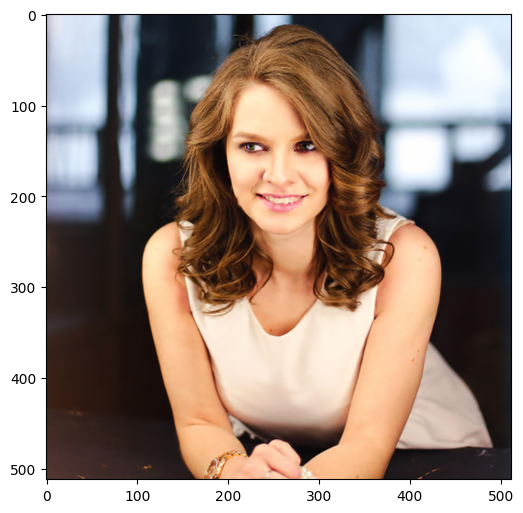

In [12]:
print(i)
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5,  file_name=f"./output/inpaint/inpaint_{i:4d}.jpg");